In [29]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import mlflow
import mlflow.sklearn

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score


import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

import warnings
warnings.filterwarnings('ignore')

In [30]:
#SETUP MLFLOW LOCAL
mlflow.set_tracking_uri(uri="http://localhost:8080")

In [31]:
df = pd.read_csv("../artifacts/Reddit_Data.csv")
df.head()

clean_comment  category
0   family mormon have never tried explain them t...         1
1  buddhism has very much lot compatible with chr...         1
2  seriously don say thing first all they won get...        -1
3  what you have learned yours and only yours wha...         0
4  for your own benefit you may want read living ...         1

In [32]:
def clening_data(df):
    df.dropna(inplace=True)
    df.drop_duplicates(inplace=True)
    df = df[~(df["clean_comment"].str.strip() == '')]
    df["clean_comment"] = df["clean_comment"].str.lower()
    df["clean_comment"] = df["clean_comment"].str.strip()

    # identify comment containing URLs
    url_pattern = r'http[s]>://(:[a-zA-Z]|[0-9]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    df = df[~(df['clean_comment'].str.contains(url_pattern,regex=True))]
    df["clean_comment"] = df["clean_comment"].str.replace("\n",' ',regex=True)

    #remove non-alphanumeric characters
    df['clean_comment'] = df['clean_comment'].apply(lambda x : re.sub(r'[^A-Za-z0-9\s?/,]','',x))

    #remove stop words
    stop_words = set(stopwords.words('english')) - {'not','but','however','no','yet'}
    df["clean_comment"] = df['clean_comment'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
    df['clean_comment'] = df['clean_comment'].apply(lambda x :' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
    return df



df = clening_data(df)
df.head()

clean_comment  category
0  family mormon never tried explain still stare ...         1
1  buddhism much lot compatible christianity espe...         1
2  seriously say thing first get complex explain ...        -1
3  learned want teach different focus goal not wr...         0
4  benefit may want read living buddha living chr...         1

In [33]:
#define vectorize comment using BOG
vectorizer = CountVectorizer(max_features=10000)

In [34]:
X =vectorizer.fit_transform(df['clean_comment']).toarray()
y = df["category"]

In [35]:
mlflow.set_experiment("RF Baseline")

2025/04/22 21:14:40 INFO mlflow.tracking.fluent: Experiment with name 'RF Baseline' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/139069012694398546', creation_time=1745331280848, experiment_id='139069012694398546', last_update_time=1745331280848, lifecycle_stage='active', name='RF Baseline', tags={}>

🏃 View run  RandomForest_Baseline_TrainTestSplit at: http://localhost:8080/#/experiments/139069012694398546/runs/83d4f46ab3a54c94b2cabcdd105ffae9
🧪 View experiment at: http://localhost:8080/#/experiments/139069012694398546


FileNotFoundError: [Errno 2] No such file or directory: '../images/confusion_matrix.png'

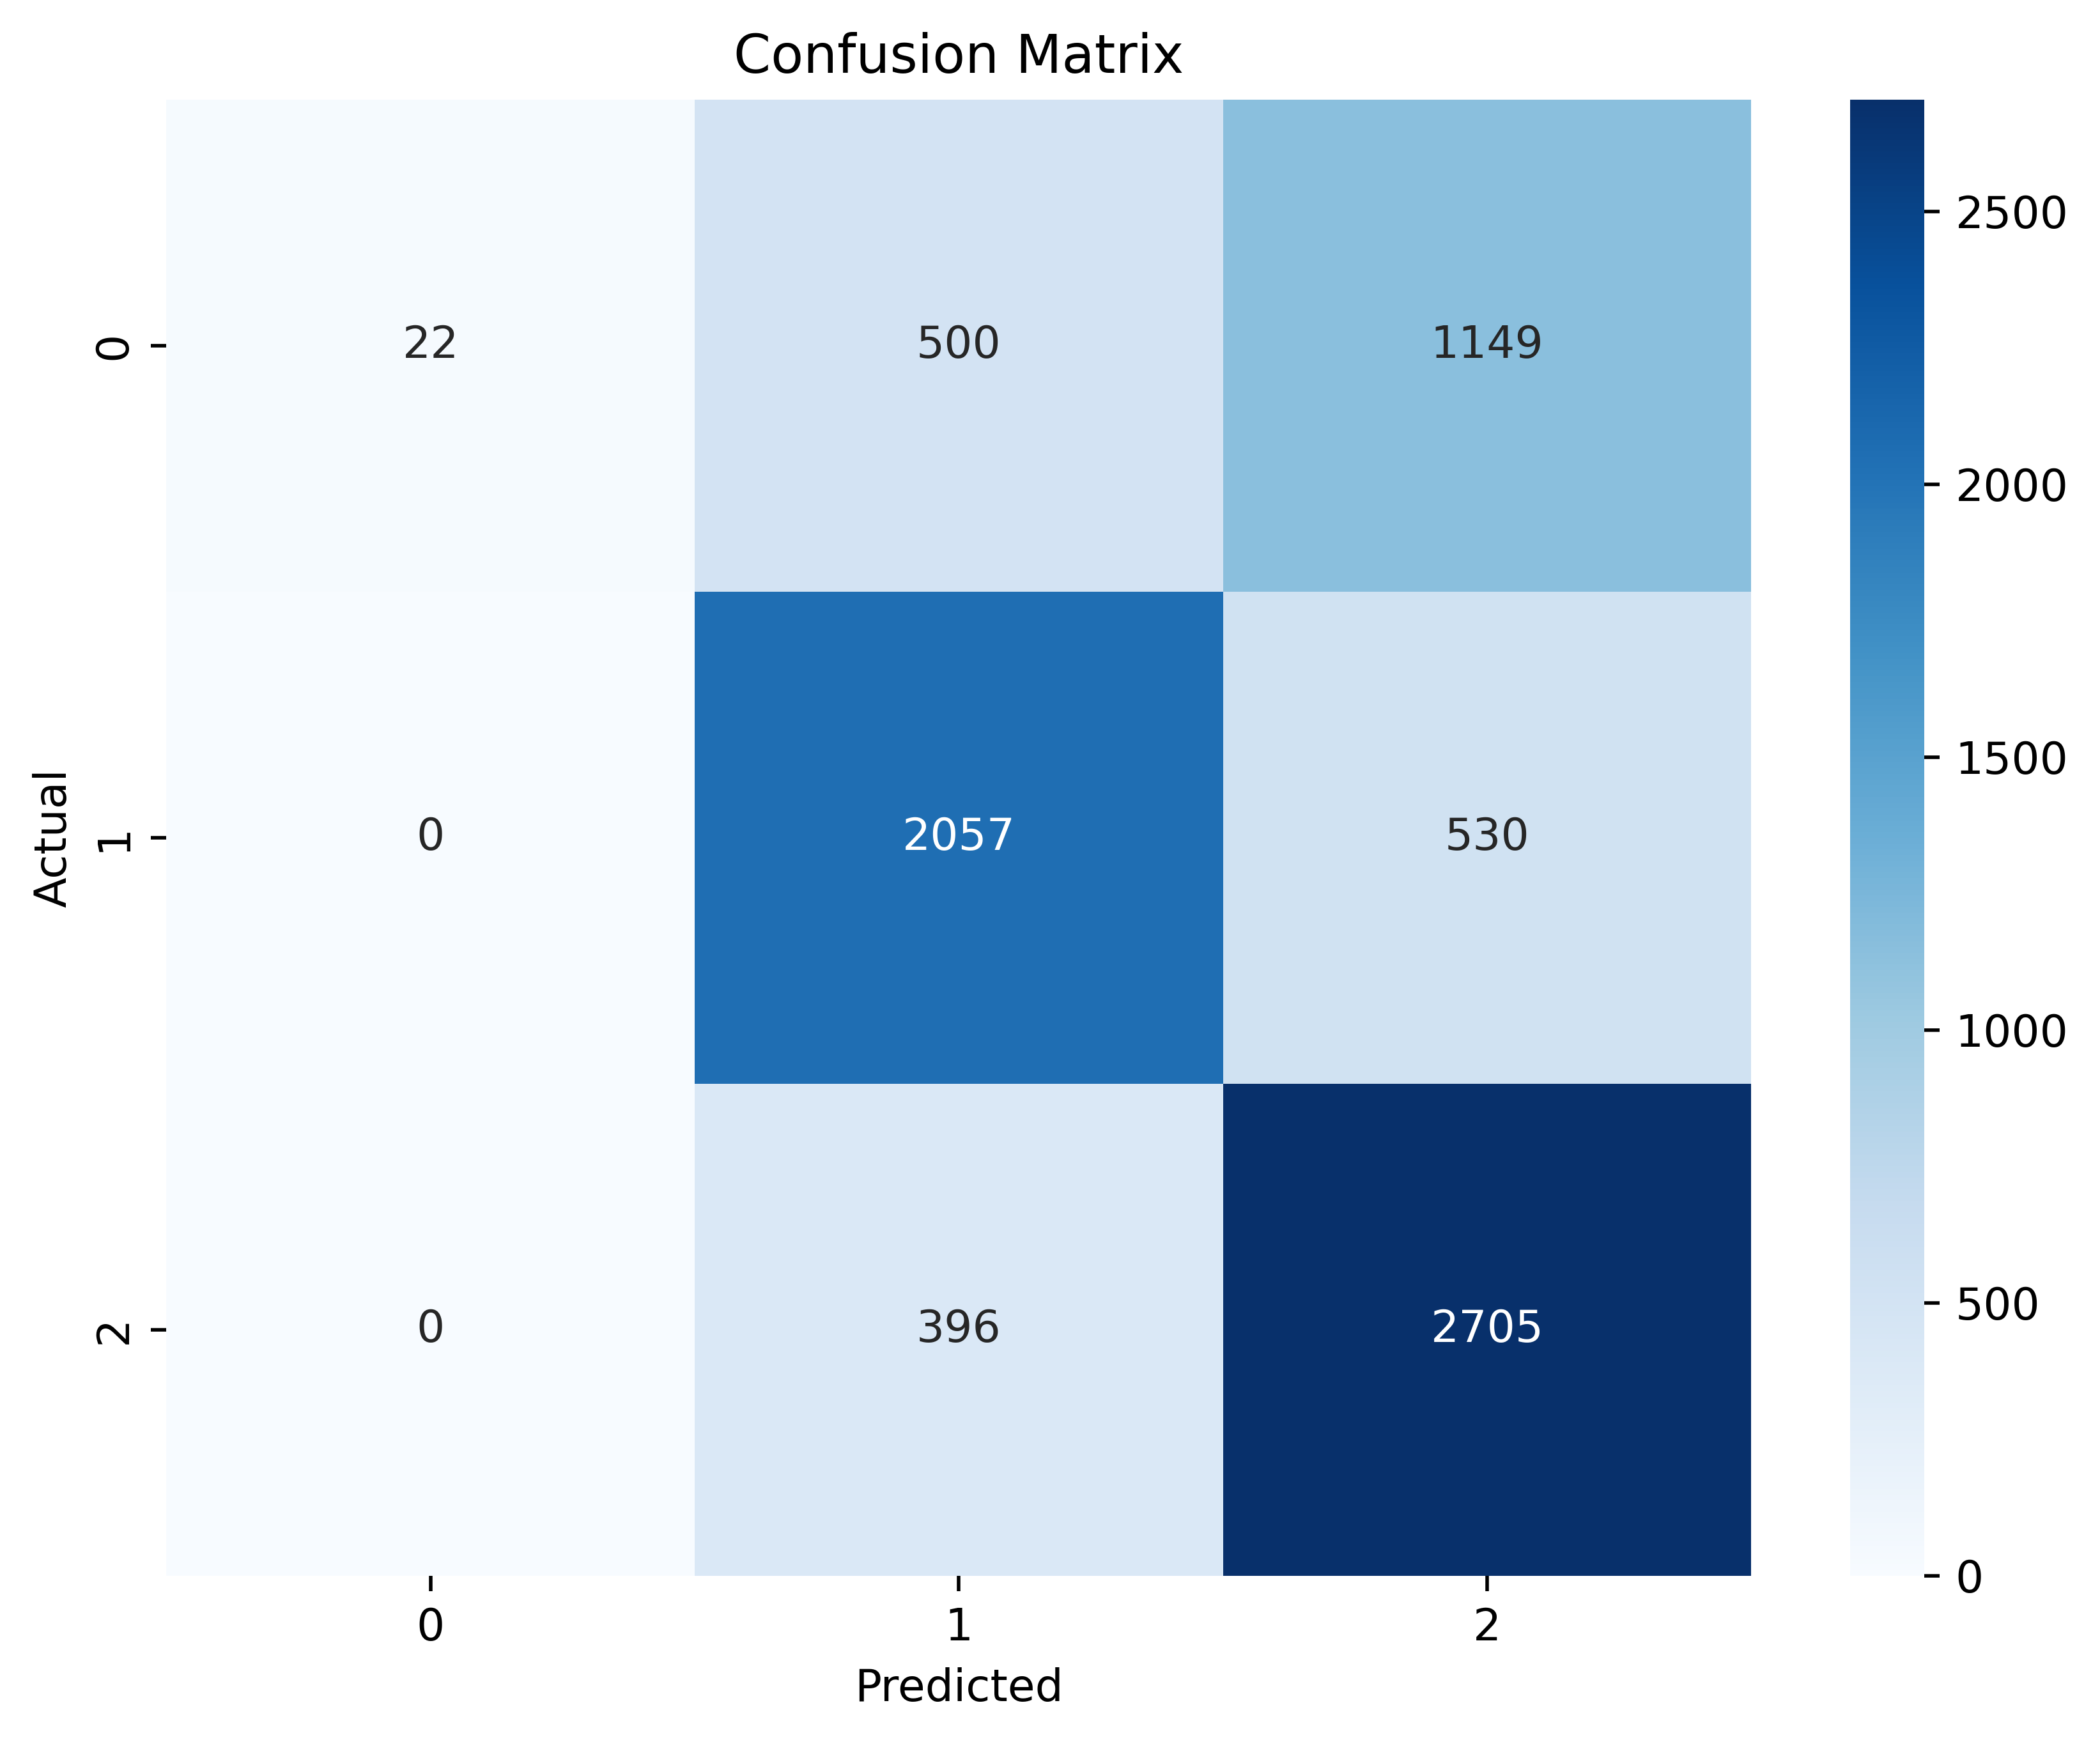

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

with mlflow.start_run() as run:
    mlflow.set_tag('mlflow.runName', ' RandomForest_Baseline_TrainTestSplit')
    mlflow.set_tag('experiment_type','baseline')
    mlflow.set_tag('model_type','RandomForestClassifier')

    mlflow.set_tag('description','Baselin Random Forest model for Sentiment Analysis')

    mlflow.log_param('vectorizer_type','CountVectorizer')
    mlflow.log_param('vectorizer_max_features', vectorizer.max_features)

    n_estimators = 200
    max_depth   = 15

    mlflow.log_param('n_estimator', n_estimators)
    mlflow.log_param('max_depth', max_depth)

    model = RandomForestClassifier(random_state=42, n_estimators=n_estimators, max_depth=max_depth)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    balance_acc = balanced_accuracy_score(y_test, y_pred)
    mlflow.log_metric('Balance Accuracy', balance_acc)

    recal_scr   = recall_score(y_test, y_pred,average="weighted")
    mlflow.log_metric('Recall Score', recal_scr)

    precision_scr = precision_score(y_test, y_pred,average="weighted")
    mlflow.log_metric('Precision Score', precision_scr)

    f1_scr = f1_score(y_test, y_pred,average="weighted")
    mlflow.log_metric('Balance Accuracy', f1_scr)

    roc_score = roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr', average="weighted")
    mlflow.log_metric('ROC-AUC Score', roc_score)

    classification_rep = classification_report(y_test, y_pred, output_dict=True)

    for label, metrics in classification_rep.items():
        if isinstance(metrics, dict):
            for metric, value in metrics.items():
                mlflow.log_metric(f"{label}_{metric}",value)
            
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,6),dpi=500)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')

    plt.savefig('confusion_matrix.png')
    mlflow.log_artifact("confusion_matrix.png")

    #save model
    mlflow.sklearn.load_model(model, 'random_forest_model')

print(f"Balance Accuracy Score {balance_acc}")
print(f"Recall Score {recal_scr}")
print(f"Precision Score {precision_scr}")
print(f"F1 Score {f1_scr}")
print(f"Roc Auc Score {roc_score}")

# TFD - IDF

In [38]:
mlflow.set_experiment('Experiment 2 - TDFidf')

2025/04/22 22:59:28 INFO mlflow.tracking.fluent: Experiment with name 'Experiment 2 - TDFidf' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/978375465382787962', creation_time=1745337568307, experiment_id='978375465382787962', last_update_time=1745337568307, lifecycle_stage='active', name='Experiment 2 - TDFidf', tags={}>

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer

2025/04/22 23:14:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run BoW_(1, 1)_RandomForest at: http://localhost:8080/#/experiments/978375465382787962/runs/d9f353ad58544c048f990cd9de77b9bb
🧪 View experiment at: http://localhost:8080/#/experiments/978375465382787962
ngram range (1, 1)
Balanced Accuracy Score: 0.5590336731811516
Recall Score: 0.6450443921000181
Precision Score: 0.7252815313619924
F1 Score: 0.5669366542631301
ROC AUC Score: 0.8511641934650521
🏃 View run chill-croc-323 at: http://localhost:8080/#/experiments/978375465382787962/runs/b76da2f34bfa433989785dc369a2f964
🧪 View experiment at: http://localhost:8080/#/experiments/978375465382787962


2025/04/22 23:14:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run TF-IDF_(1, 1)_RandomForest at: http://localhost:8080/#/experiments/978375465382787962/runs/6d97d8aa84664e08a574c2be88ead34a
🧪 View experiment at: http://localhost:8080/#/experiments/978375465382787962
ngram range (1, 1)
Balanced Accuracy Score: 0.5571036572817848
Recall Score: 0.643141873527813
Precision Score: 0.7238793640712332
F1 Score: 0.5655331333986575
ROC AUC Score: 0.8530055367274713


2025/04/22 23:14:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run BoW_(1, 2)_RandomForest at: http://localhost:8080/#/experiments/978375465382787962/runs/86c6e5de8b1843e3ada6945fa1d971aa
🧪 View experiment at: http://localhost:8080/#/experiments/978375465382787962
ngram range (1, 2)
Balanced Accuracy Score: 0.5649753472746705
Recall Score: 0.6494836021018301
Precision Score: 0.714643180540126
F1 Score: 0.5761206010427293
ROC AUC Score: 0.8524649683395731


2025/04/22 23:14:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run TF-IDF_(1, 2)_RandomForest at: http://localhost:8080/#/experiments/978375465382787962/runs/de6a2c0463e34c8280f12e4fda55306d
🧪 View experiment at: http://localhost:8080/#/experiments/978375465382787962
ngram range (1, 2)
Balanced Accuracy Score: 0.5677589131350902
Recall Score: 0.6514767167965211
Precision Score: 0.7155848024796474
F1 Score: 0.5796334262668033
ROC AUC Score: 0.8543992071028005


2025/04/22 23:14:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run BoW_(1, 3)_RandomForest at: http://localhost:8080/#/experiments/978375465382787962/runs/d631be7b996b4185b4d022cde6d1cb04
🧪 View experiment at: http://localhost:8080/#/experiments/978375465382787962
ngram range (1, 3)
Balanced Accuracy Score: 0.5639410395897907
Recall Score: 0.6504801594491756
Precision Score: 0.7243521161009017
F1 Score: 0.572371578605245
ROC AUC Score: 0.8488716696405968


2025/04/22 23:14:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run TF-IDF_(1, 3)_RandomForest at: http://localhost:8080/#/experiments/978375465382787962/runs/b9c1773c0cb44104ac8726a8007ac3da
🧪 View experiment at: http://localhost:8080/#/experiments/978375465382787962
ngram range (1, 3)
Balanced Accuracy Score: 0.5659032148965907
Recall Score: 0.6513861206740351
Precision Score: 0.722773544062041
F1 Score: 0.5756654992167936
ROC AUC Score: 0.8508484381942605


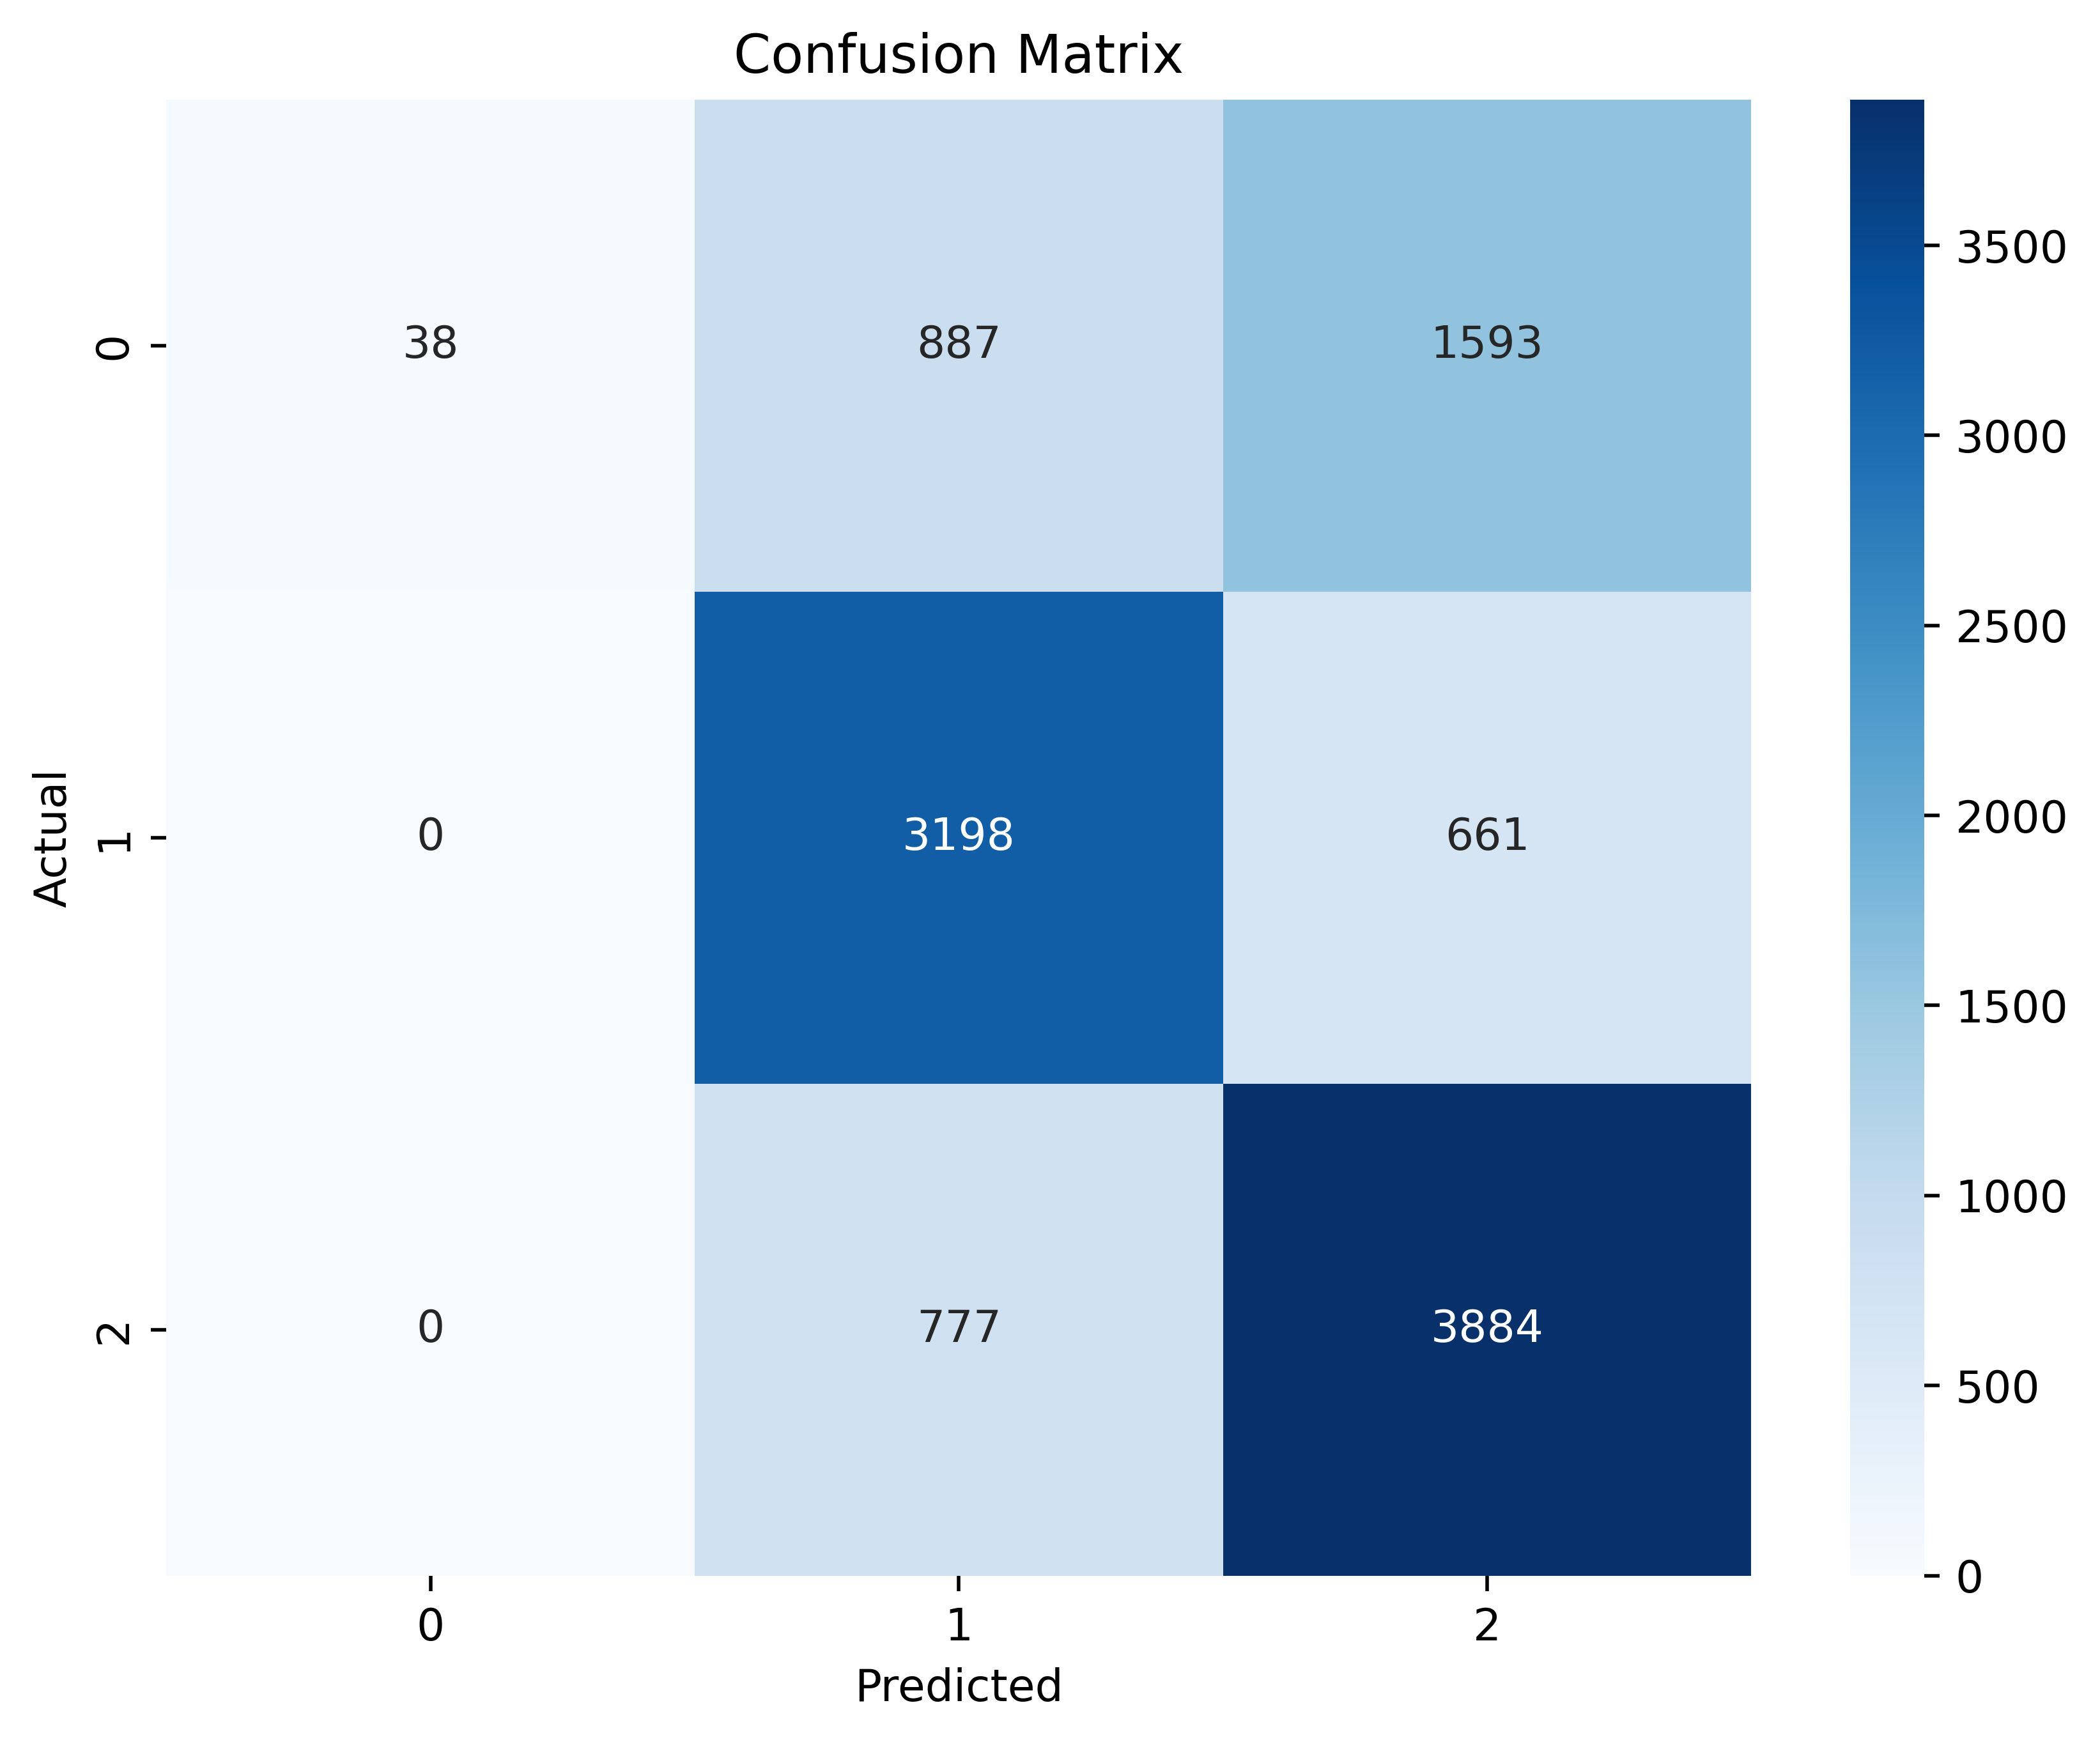

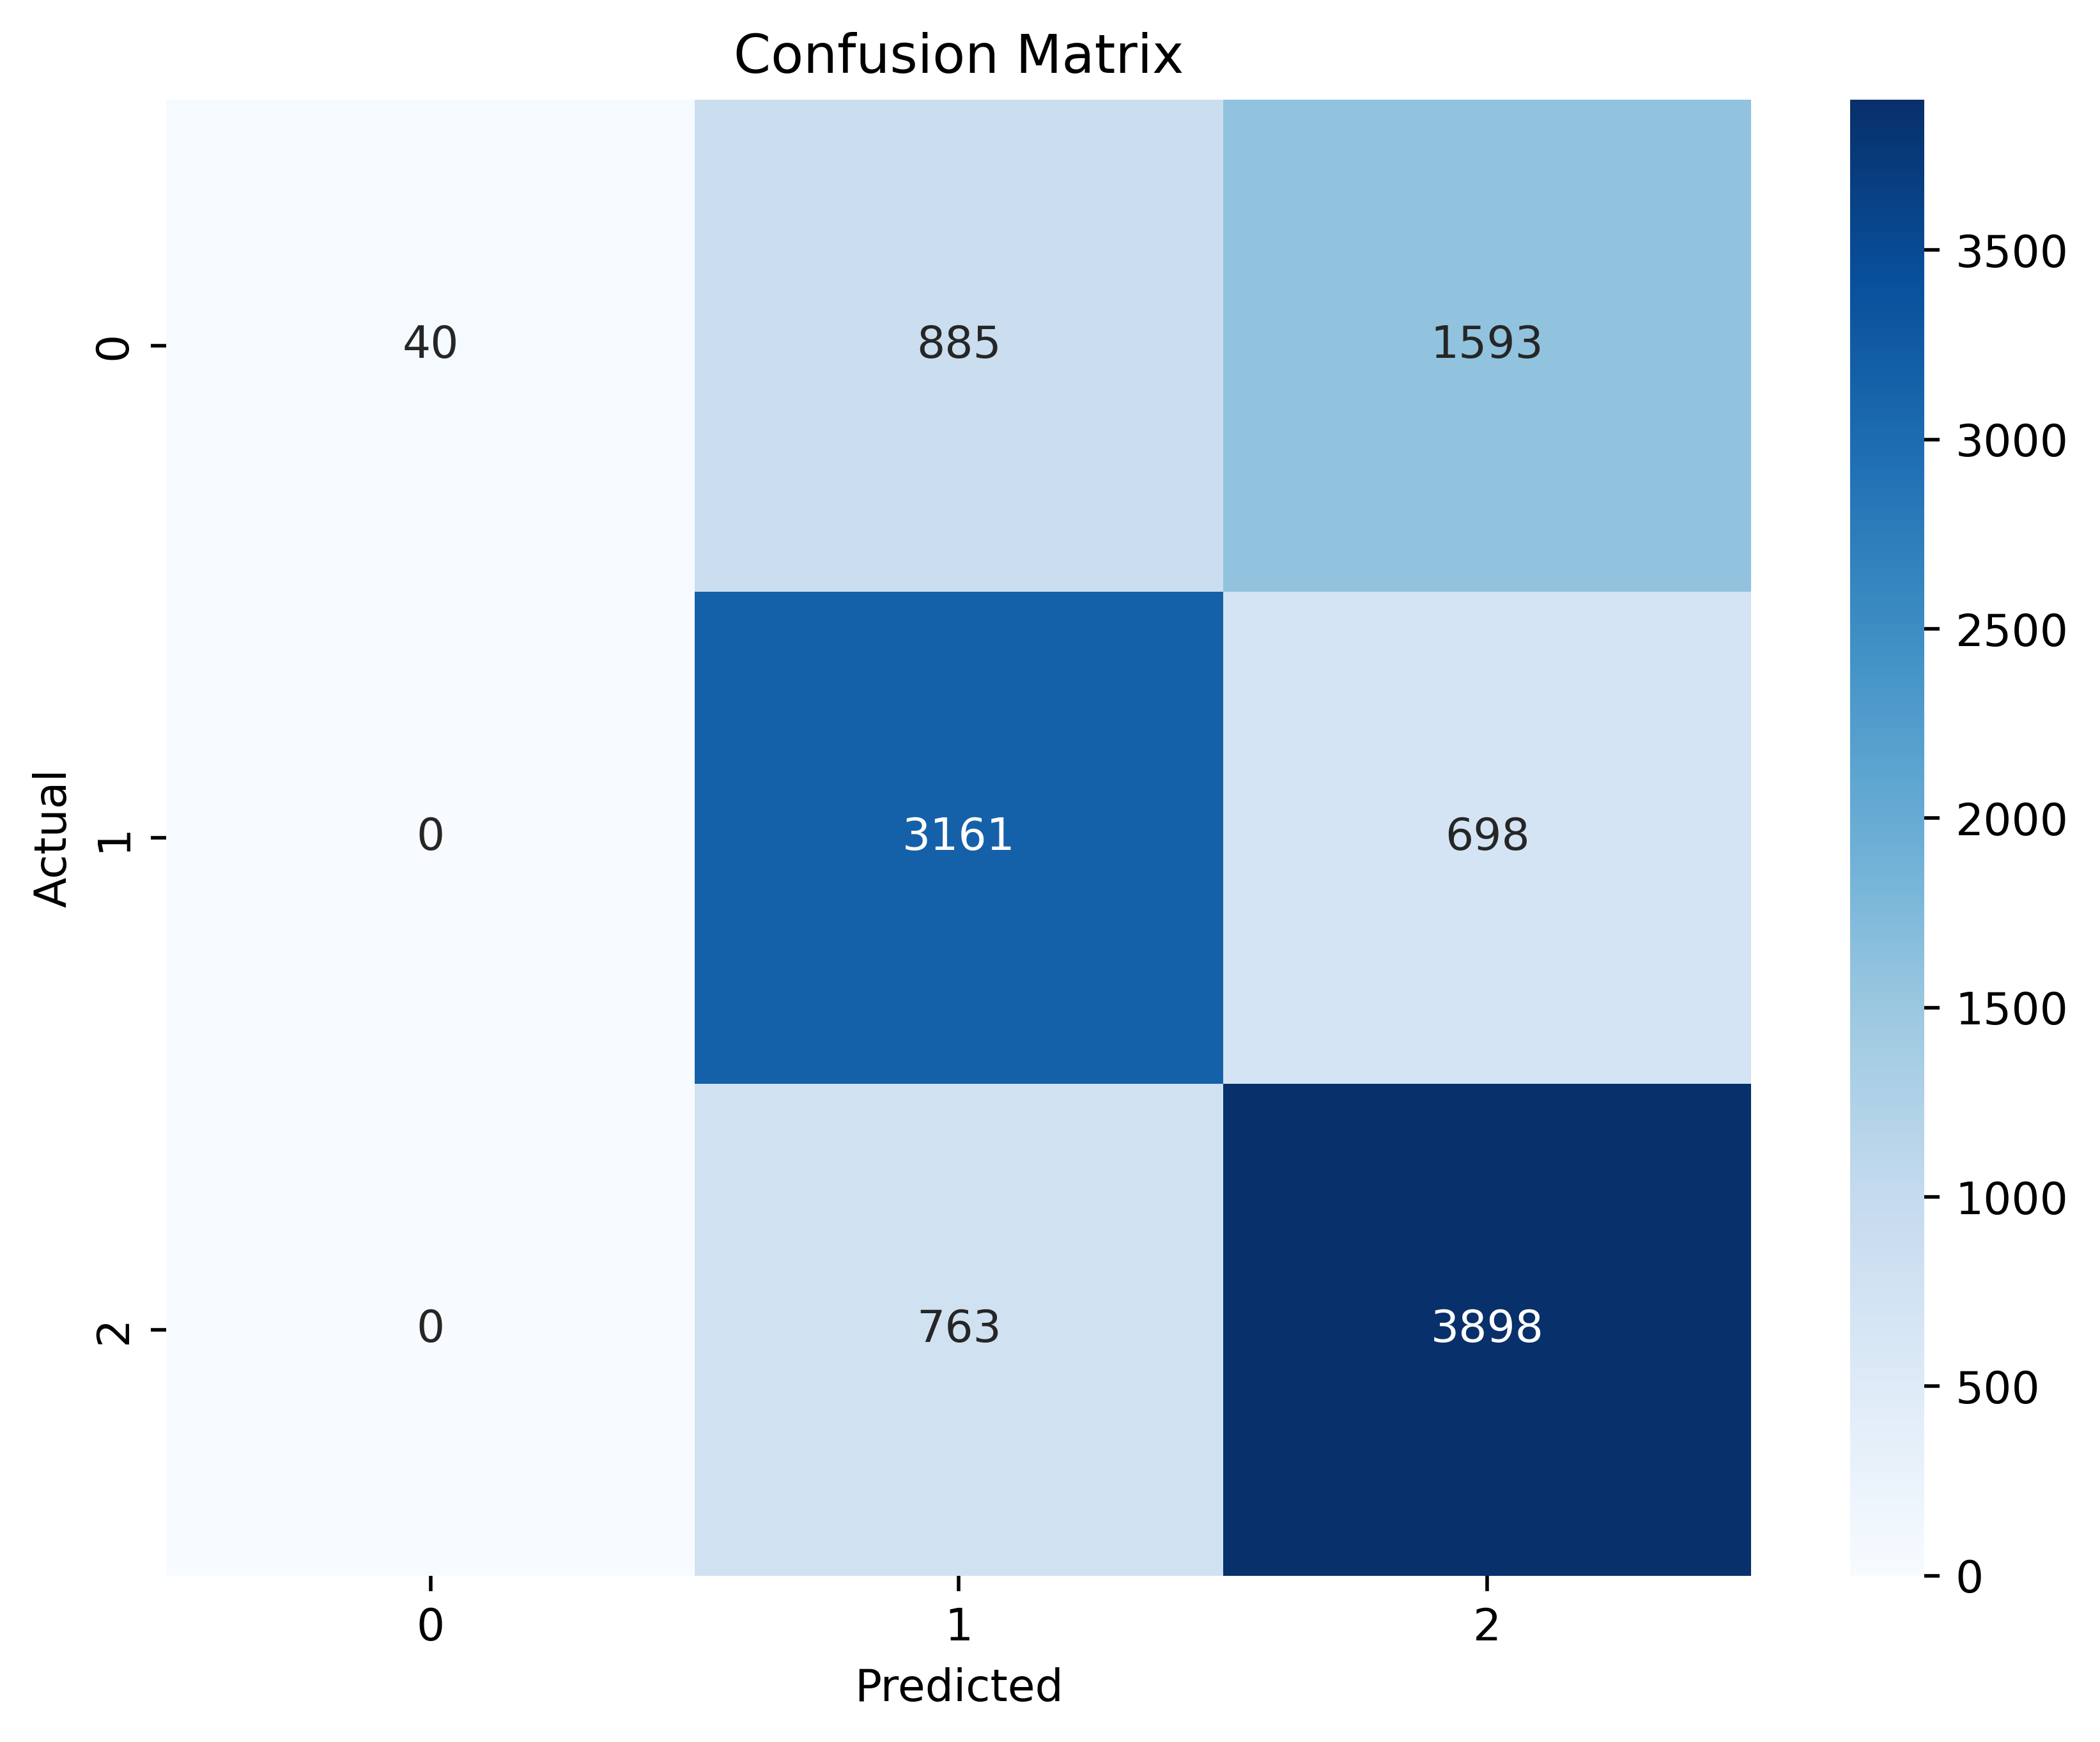

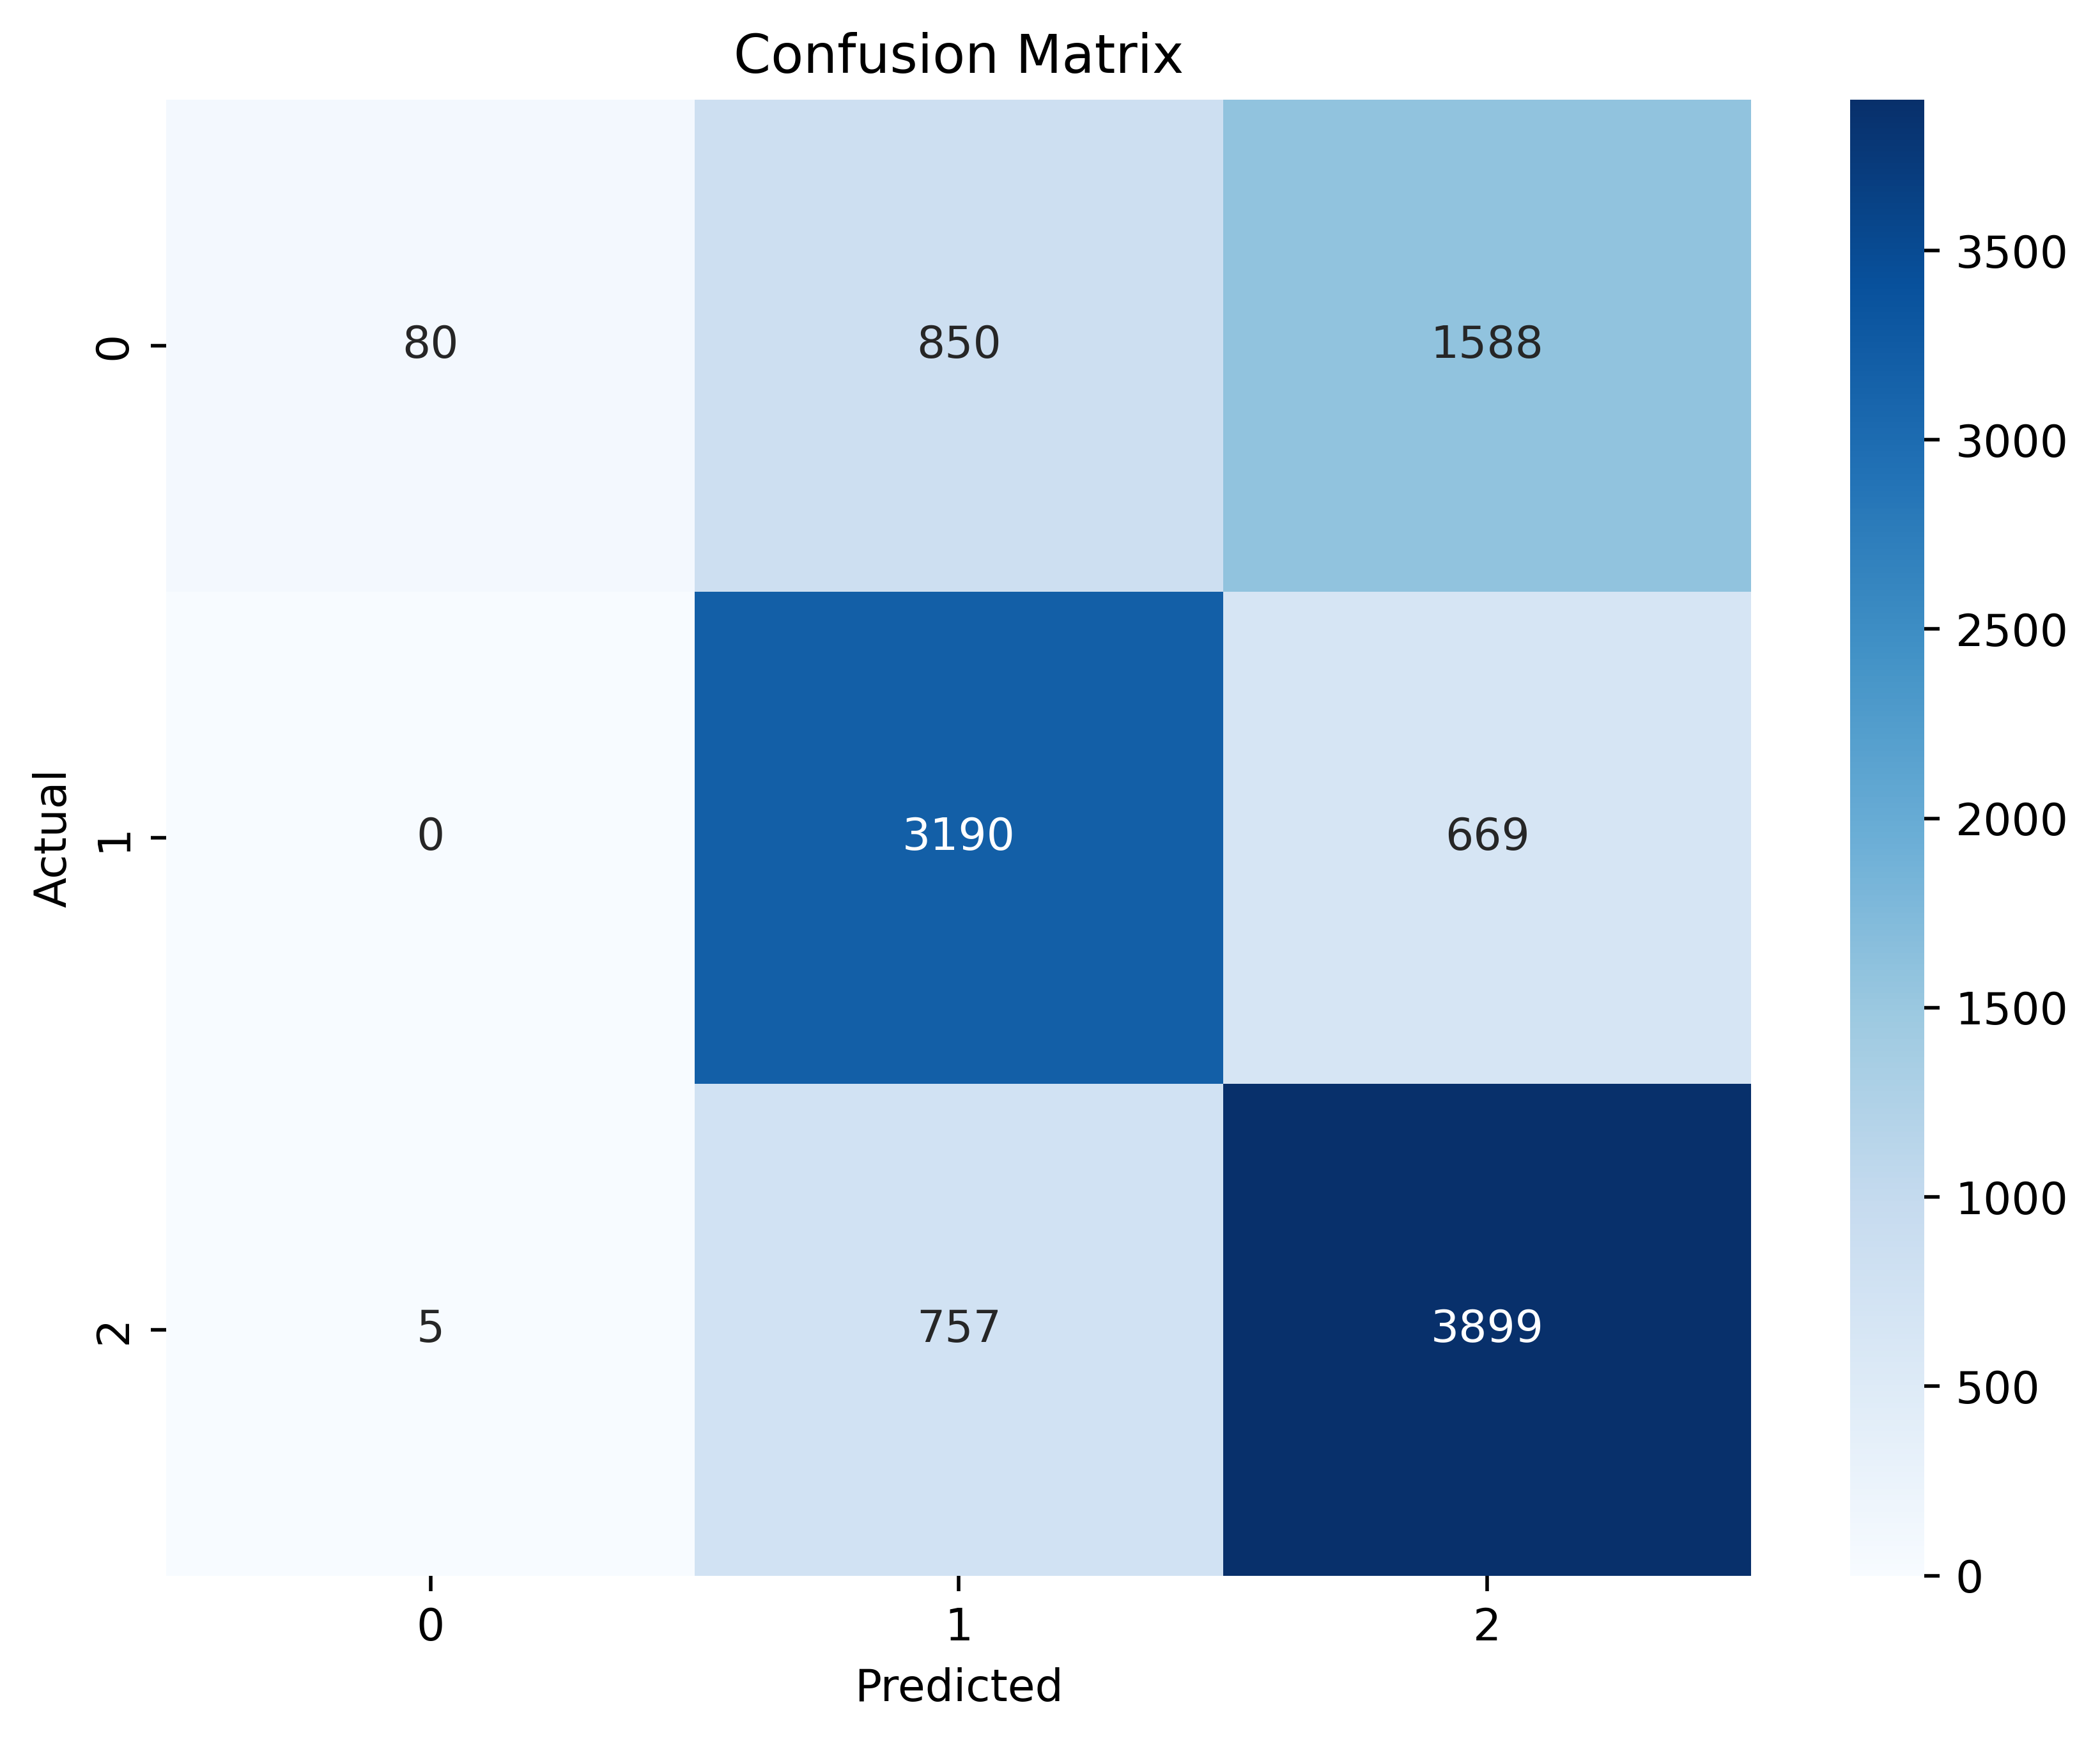

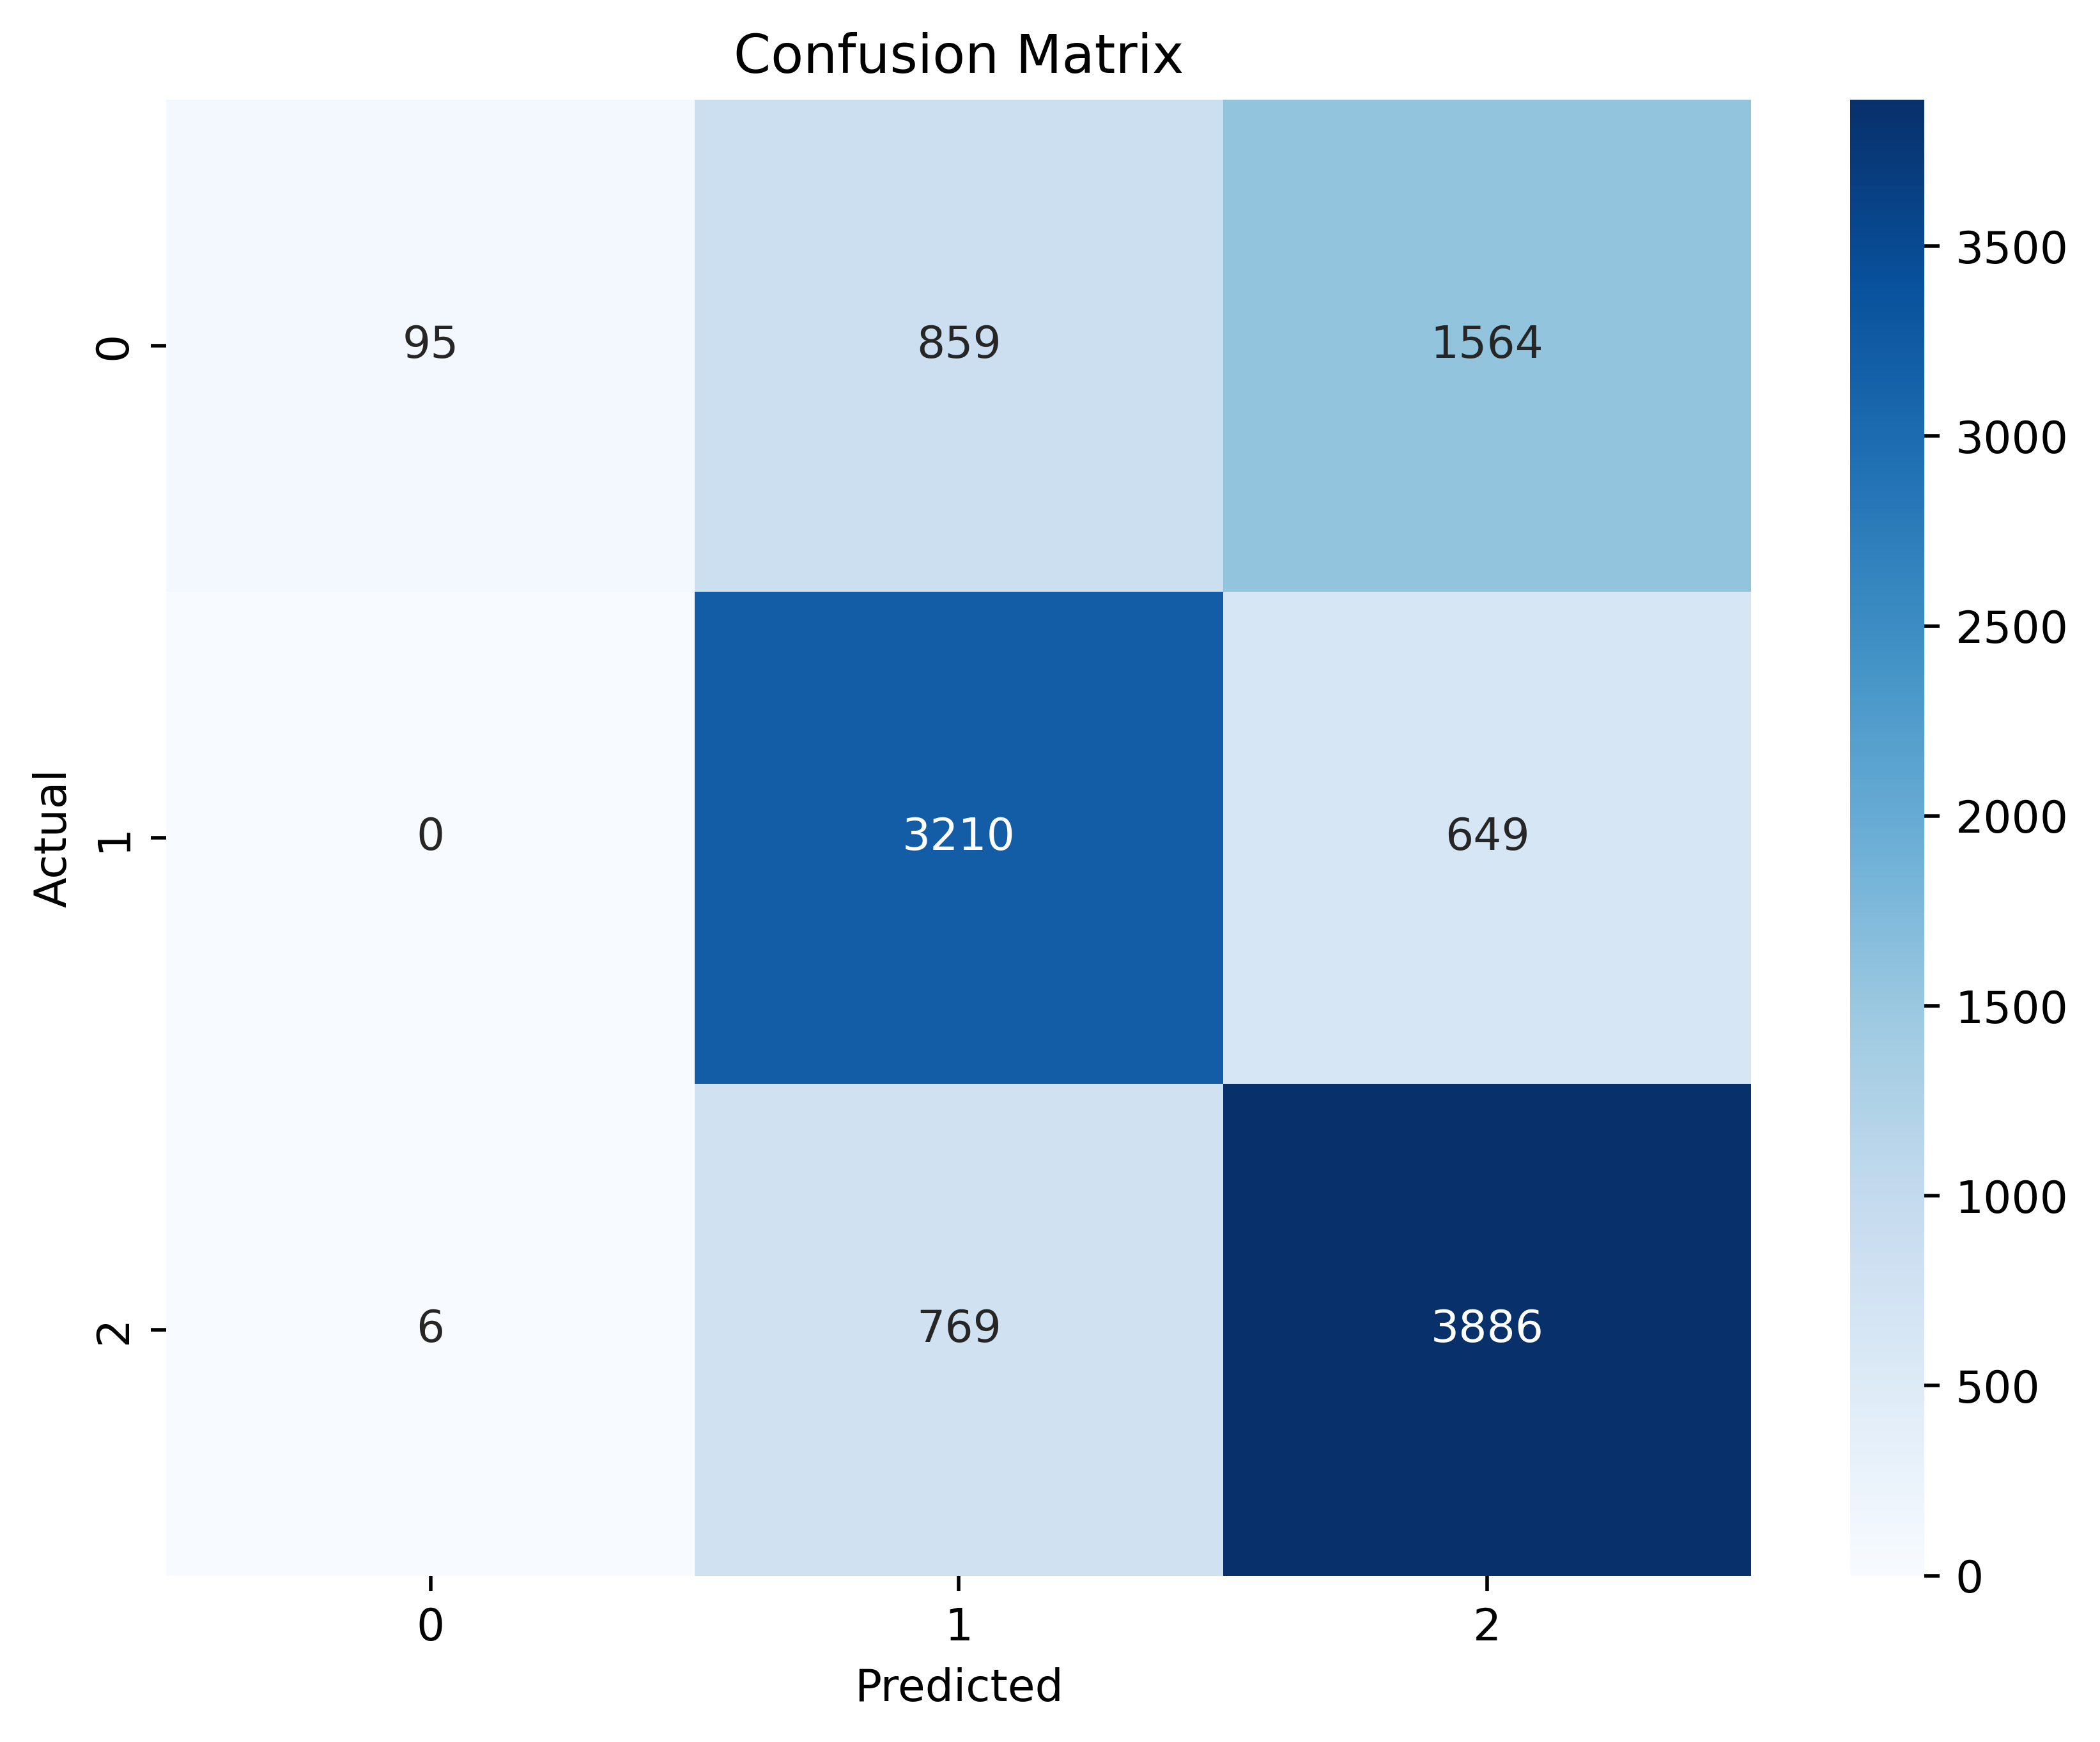

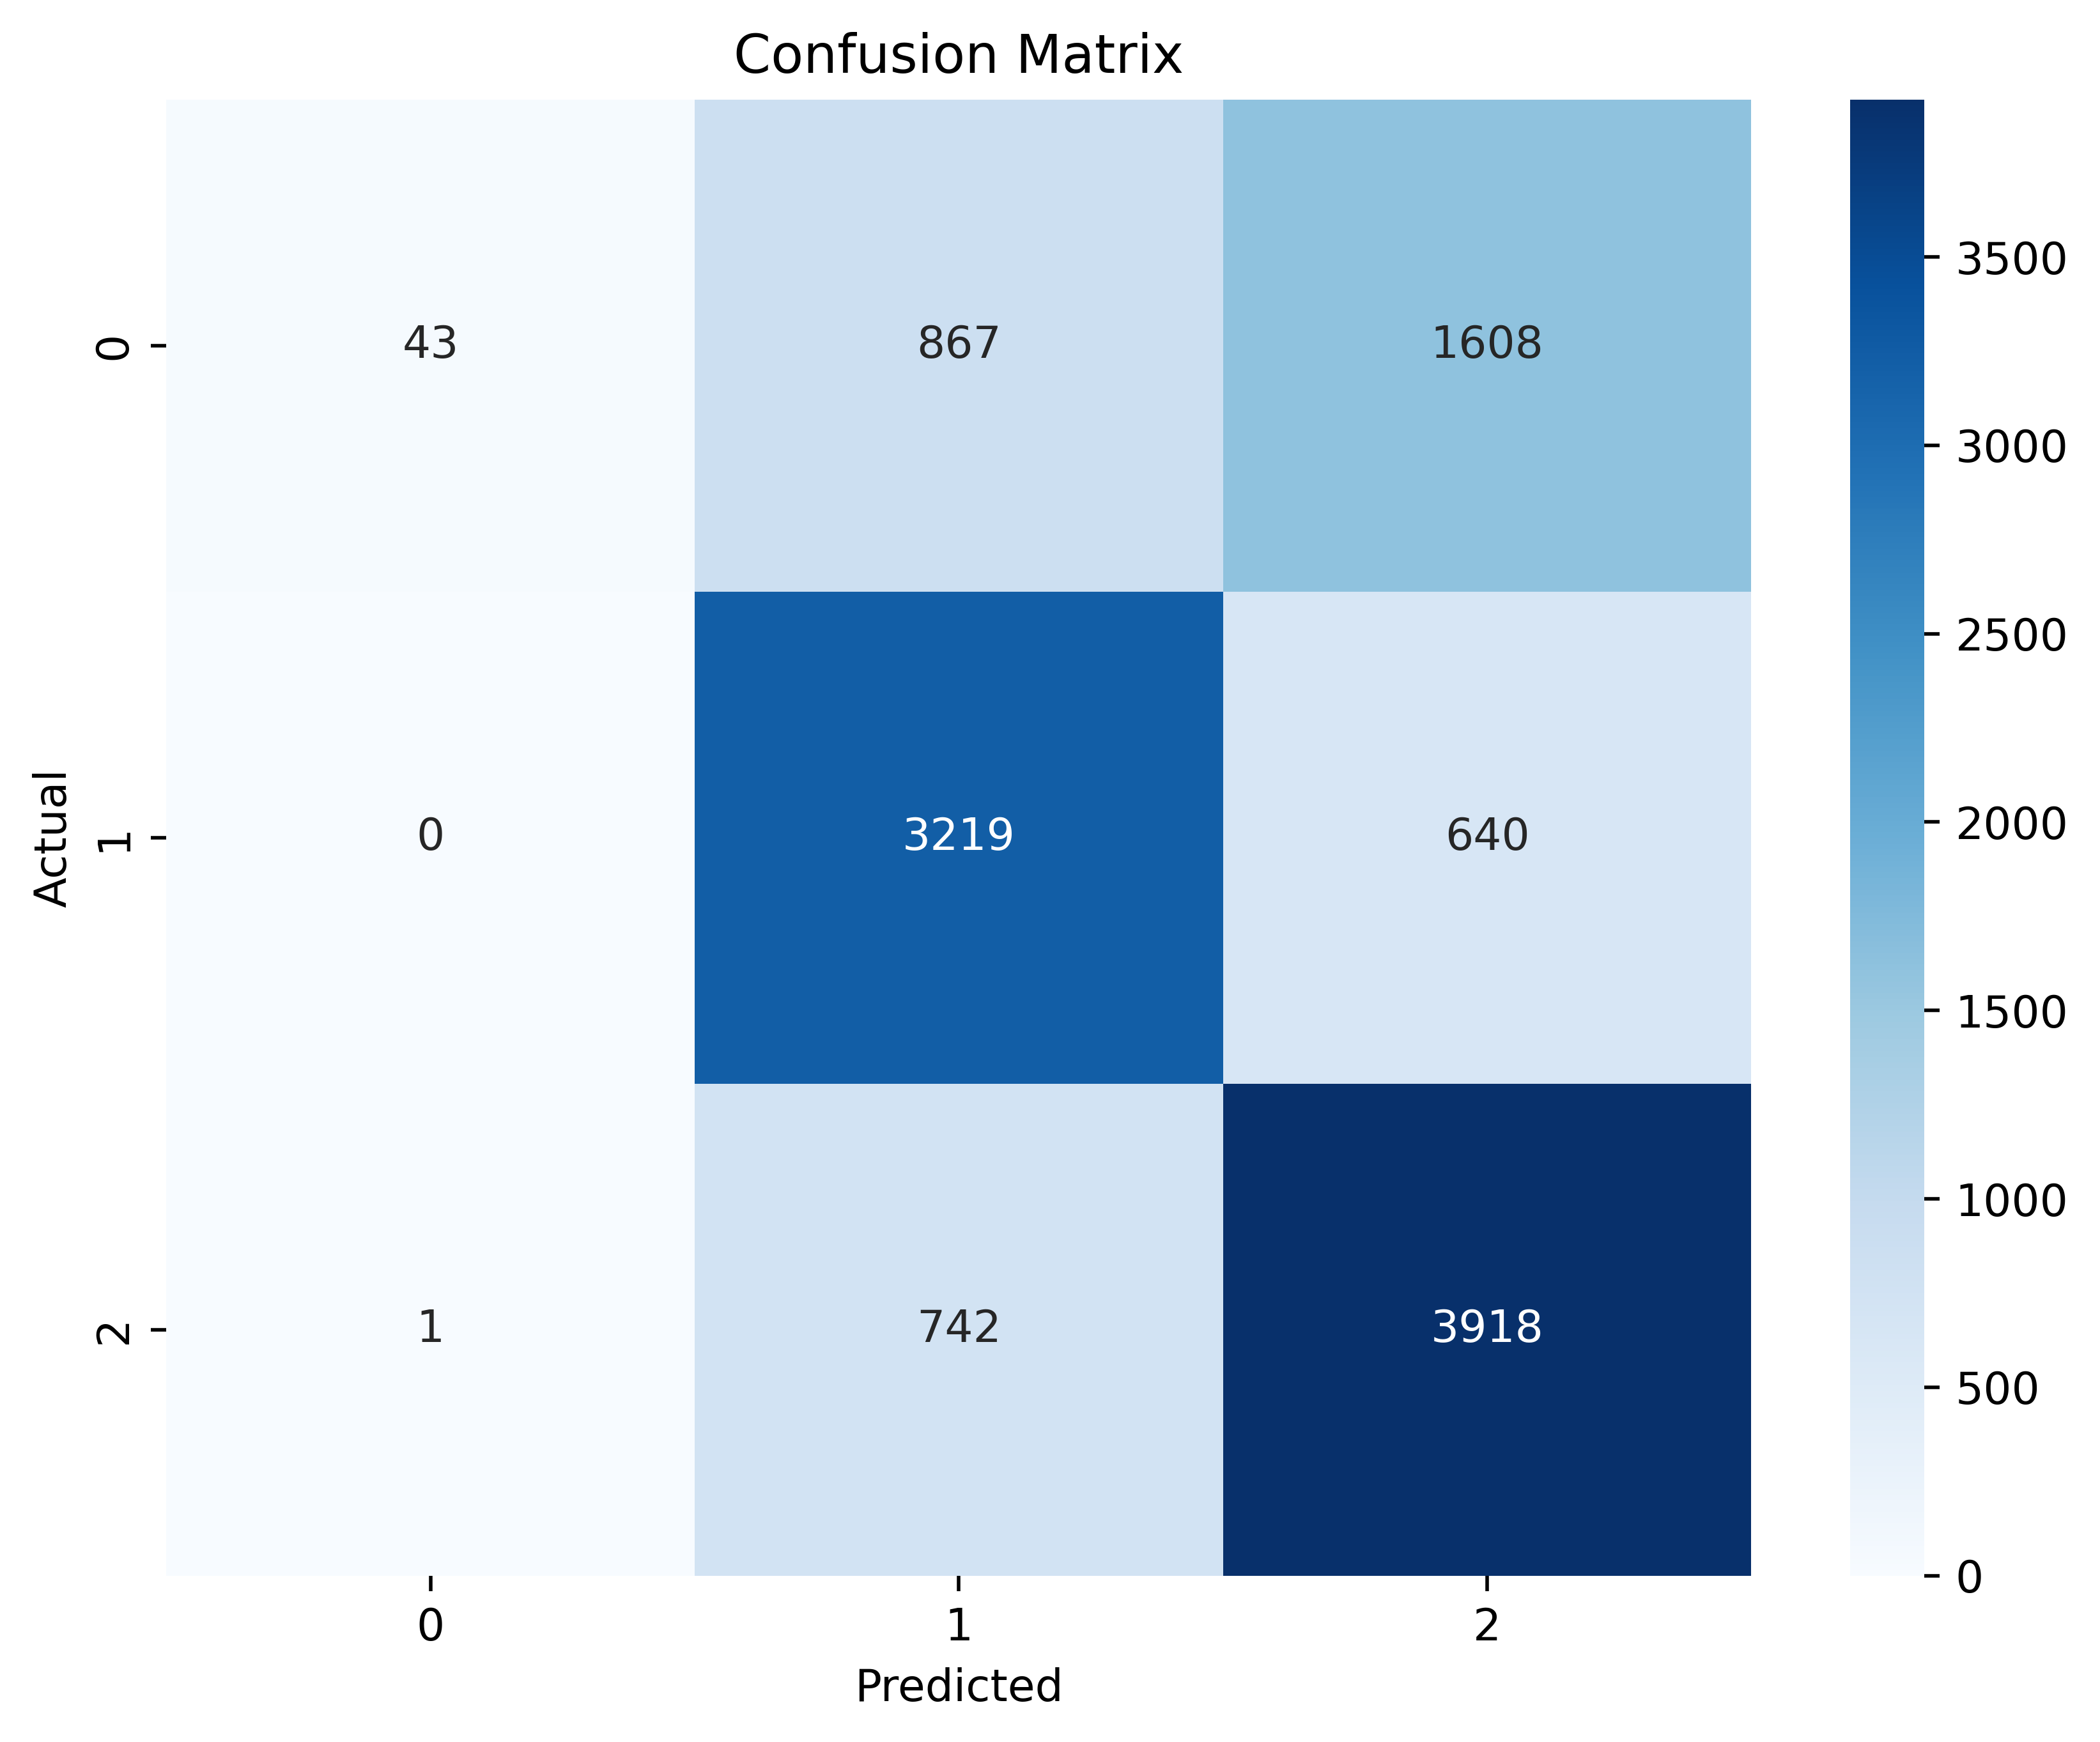

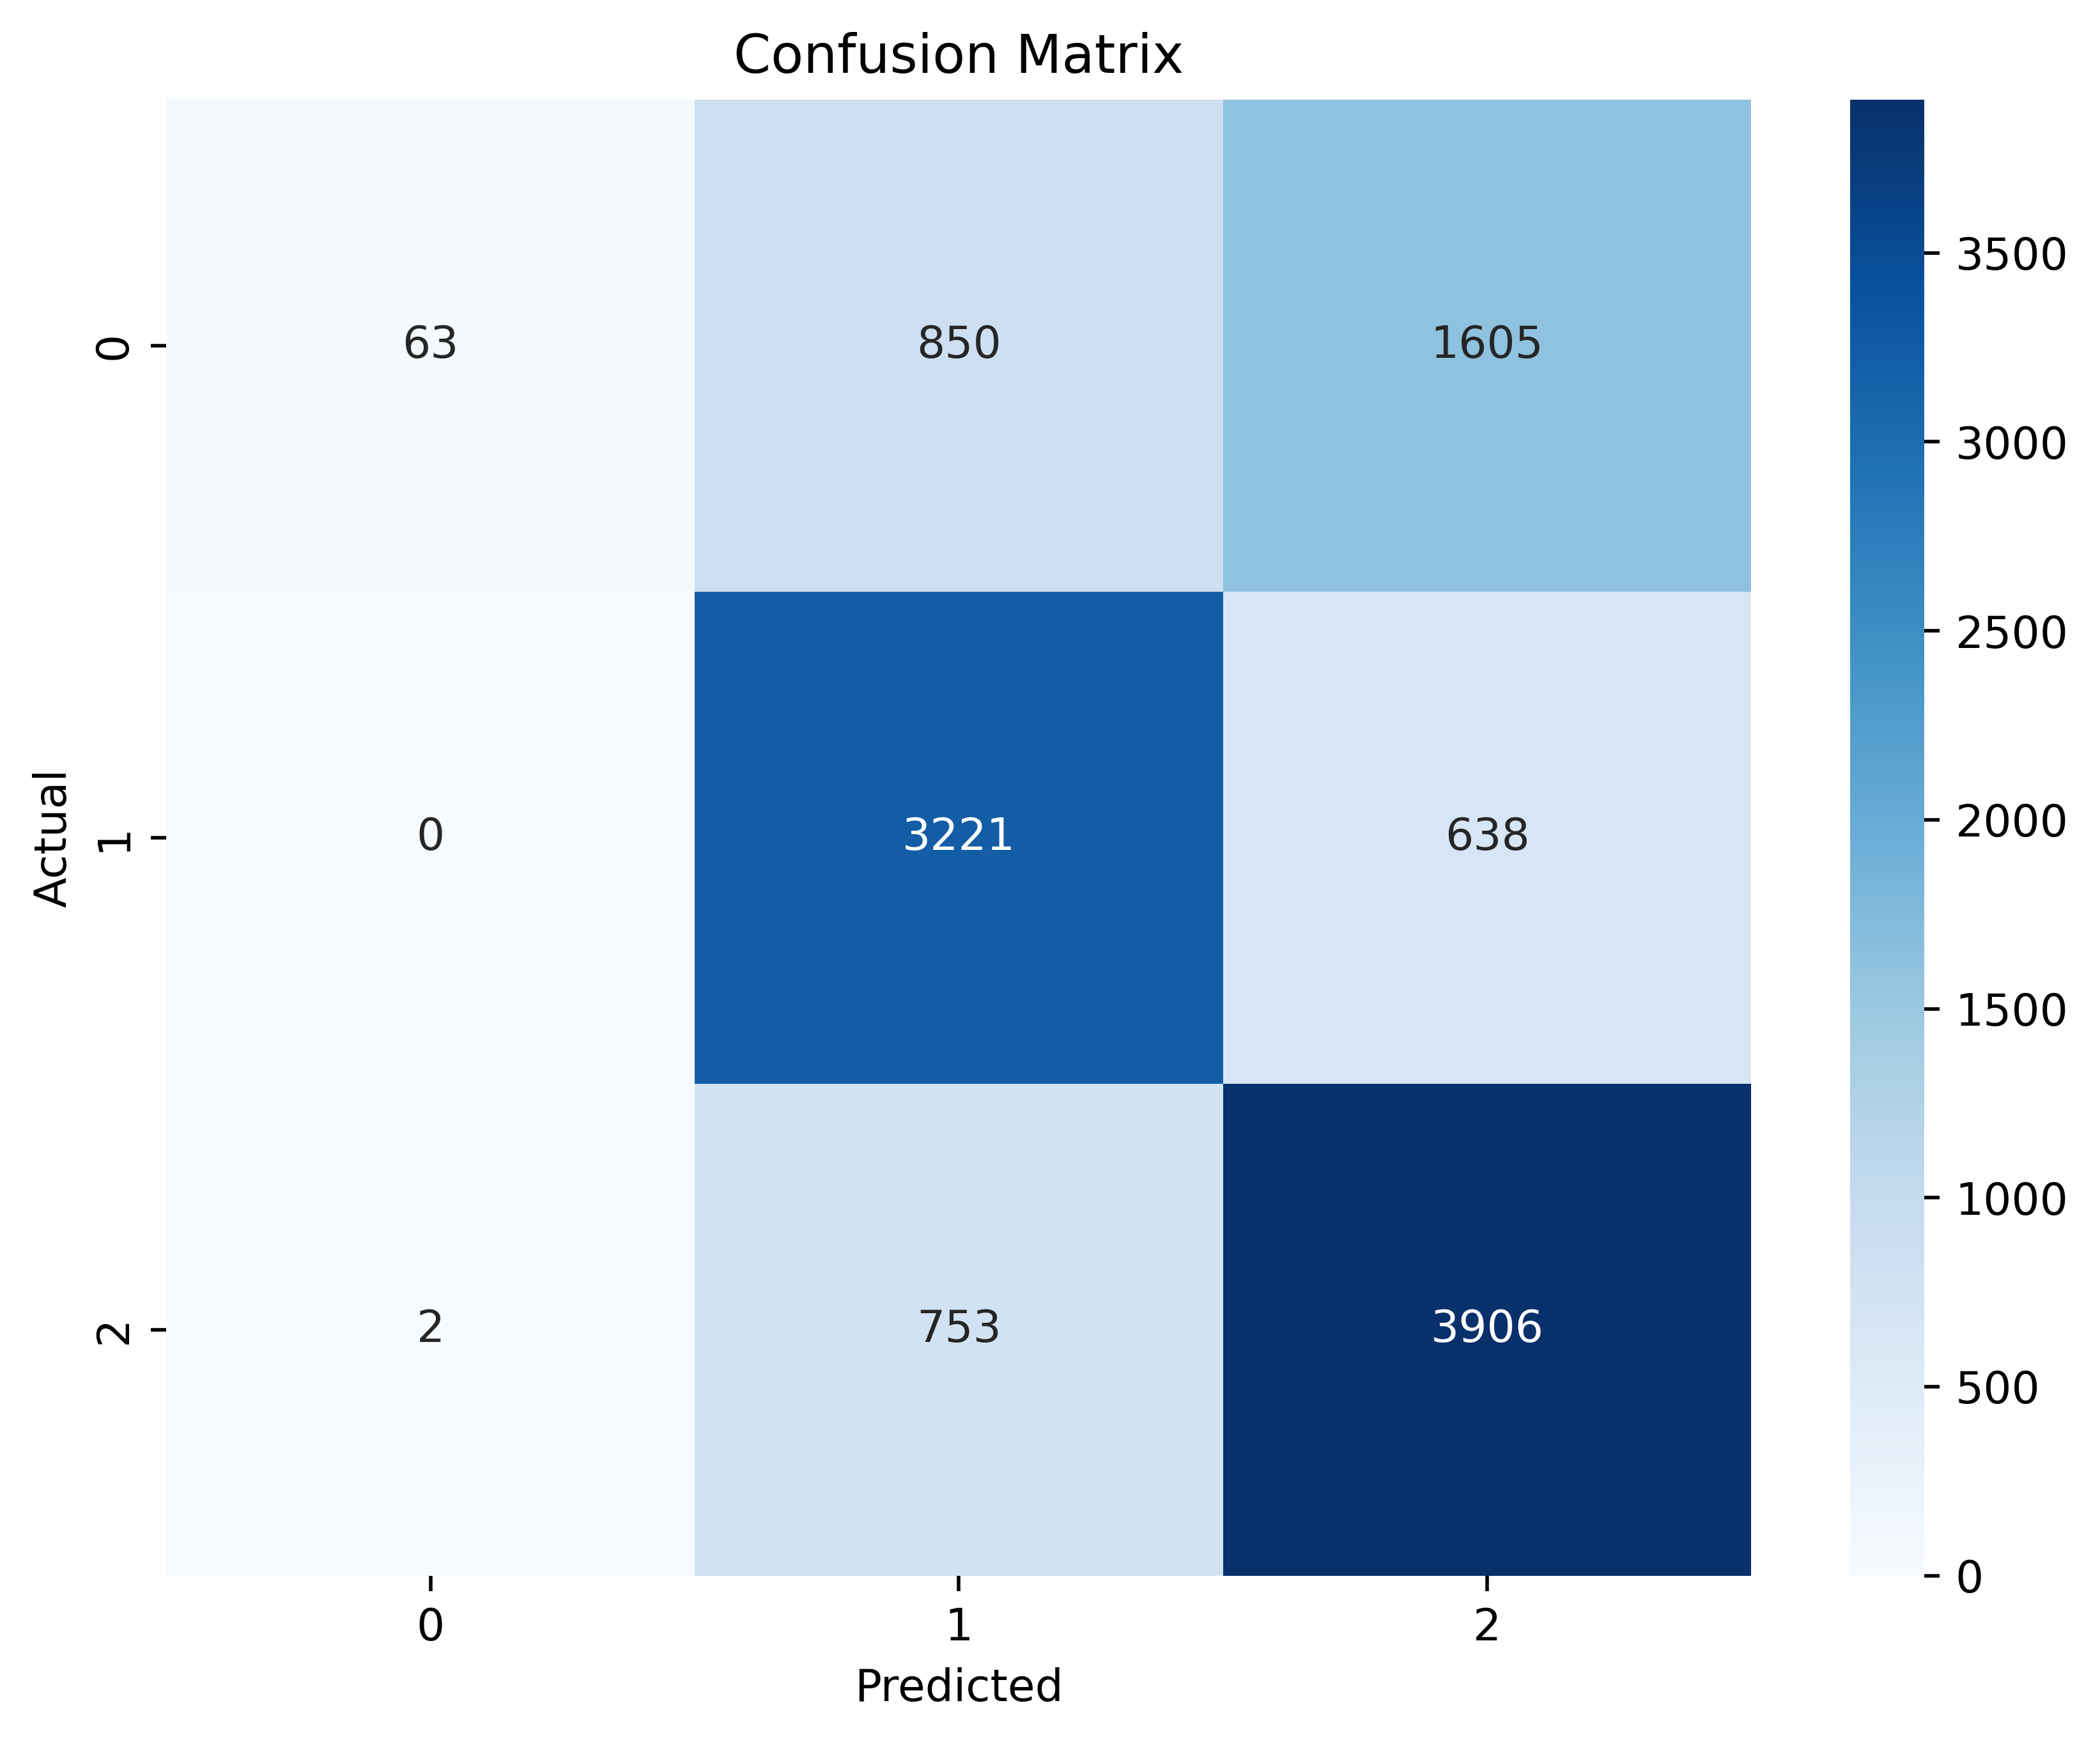

In [42]:
def run_experiment(vectorize_type, ngram_range, vectorizer_max_features, vectorizer_name):
    if vectorize_type=='BoW':
        vectorizer = CountVectorizer(ngram_range=ngram_range, max_features=vectorizer_max_features)
    else:
        vectorizer = TfidfVectorizer(ngram_range=ngram_range, max_features=vectorizer_max_features)

    X_train, X_test, y_train, y_test = train_test_split(df['clean_comment'], df['category'], test_size=0.3, random_state=42)

    X_train = vectorizer.fit_transform(X_train)
    X_test  = vectorizer.transform(X_test)

    with mlflow.start_run(nested=True) as run:
        mlflow.set_tag('mlflow.runName', f'{vectorizer_name}_{ngram_range}_RandomForest')
        mlflow.set_tag('experiment_type','feature_engineering')
        mlflow.set_tag('model_type','RandomForestClassifier')

        # Fixed f-string formatting
        mlflow.set_tag('description', f'RandomForest With {vectorizer_name}, n_gram = {ngram_range}, max_features = {vectorizer_max_features}')

        mlflow.log_param('vectorize_type', vectorize_type)
        mlflow.log_param('ngram_range', ngram_range)
        mlflow.log_param('vectorizer_max_features', vectorizer.max_features)

        n_estimators = 200
        max_depth   = 15

        mlflow.log_param('max_depth', max_depth)
        mlflow.log_param('n_estimator', n_estimators)

        model = RandomForestClassifier(random_state=42, n_estimators=n_estimators, max_depth=max_depth)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        balance_acc = balanced_accuracy_score(y_test, y_pred)
        mlflow.log_metric('Balanced Accuracy', balance_acc)

        recal_scr = recall_score(y_test, y_pred, average="weighted")
        mlflow.log_metric('Recall Score', recal_scr)

        precision_scr = precision_score(y_test, y_pred, average="weighted")
        mlflow.log_metric('Precision Score', precision_scr)

        f1_scr = f1_score(y_test, y_pred, average="weighted")
        mlflow.log_metric('F1 Score', f1_scr)  # Fixed metric name

        roc_score = roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr', average="weighted")
        mlflow.log_metric('ROC-AUC Score', roc_score)

        # Moved inside mlflow.start_run() context
        classification_rep = classification_report(y_test, y_pred, output_dict=True)

        for label, metrics in classification_rep.items():
            if isinstance(metrics, dict):
                for metric, value in metrics.items():
                    mlflow.log_metric(f"{label}_{metric}", value)
                
        conf_matrix = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6), dpi=500)
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')

        plt.savefig('confusion_matrix.png')
        mlflow.log_artifact("confusion_matrix.png")

        # Fixed model saving - use log_model instead of load_model
        # Fixed f-string formatting in the model name
        mlflow.sklearn.log_model(model, f"random_forest_model_{vectorizer_name}_{ngram_range}")
        
        # Return metrics to be used outside the function
        return balance_acc, recal_scr, precision_scr, f1_scr, roc_score

# ============ unigram, bigram, trigram
ngram_ranges = [(1,1), (1,2), (1,3)]
max_features = 5000

for ngram_range in ngram_ranges:
    # Capture returned metrics
    balance_acc, recal_scr, precision_scr, f1_scr, roc_score = run_experiment('BoW', ngram_range, max_features, vectorizer_name='BoW')
    print(f"ngram range {ngram_range}")
    print(f"Balanced Accuracy Score: {balance_acc}")
    print(f"Recall Score: {recal_scr}")
    print(f"Precision Score: {precision_scr}")
    print(f"F1 Score: {f1_scr}")
    print(f"ROC AUC Score: {roc_score}")
    mlflow.end_run()
    # Capture returned metrics
    balance_acc, recal_scr, precision_scr, f1_scr, roc_score = run_experiment('TF-IDF', ngram_range, max_features, vectorizer_name='TF-IDF')
    print(f"ngram range {ngram_range}")
    print(f"Balanced Accuracy Score: {balance_acc}")
    print(f"Recall Score: {recal_scr}")
    print(f"Precision Score: {precision_scr}")
    print(f"F1 Score: {f1_scr}")
    print(f"ROC AUC Score: {roc_score}")
    mlflow.end_run()

# Improve by Max Features

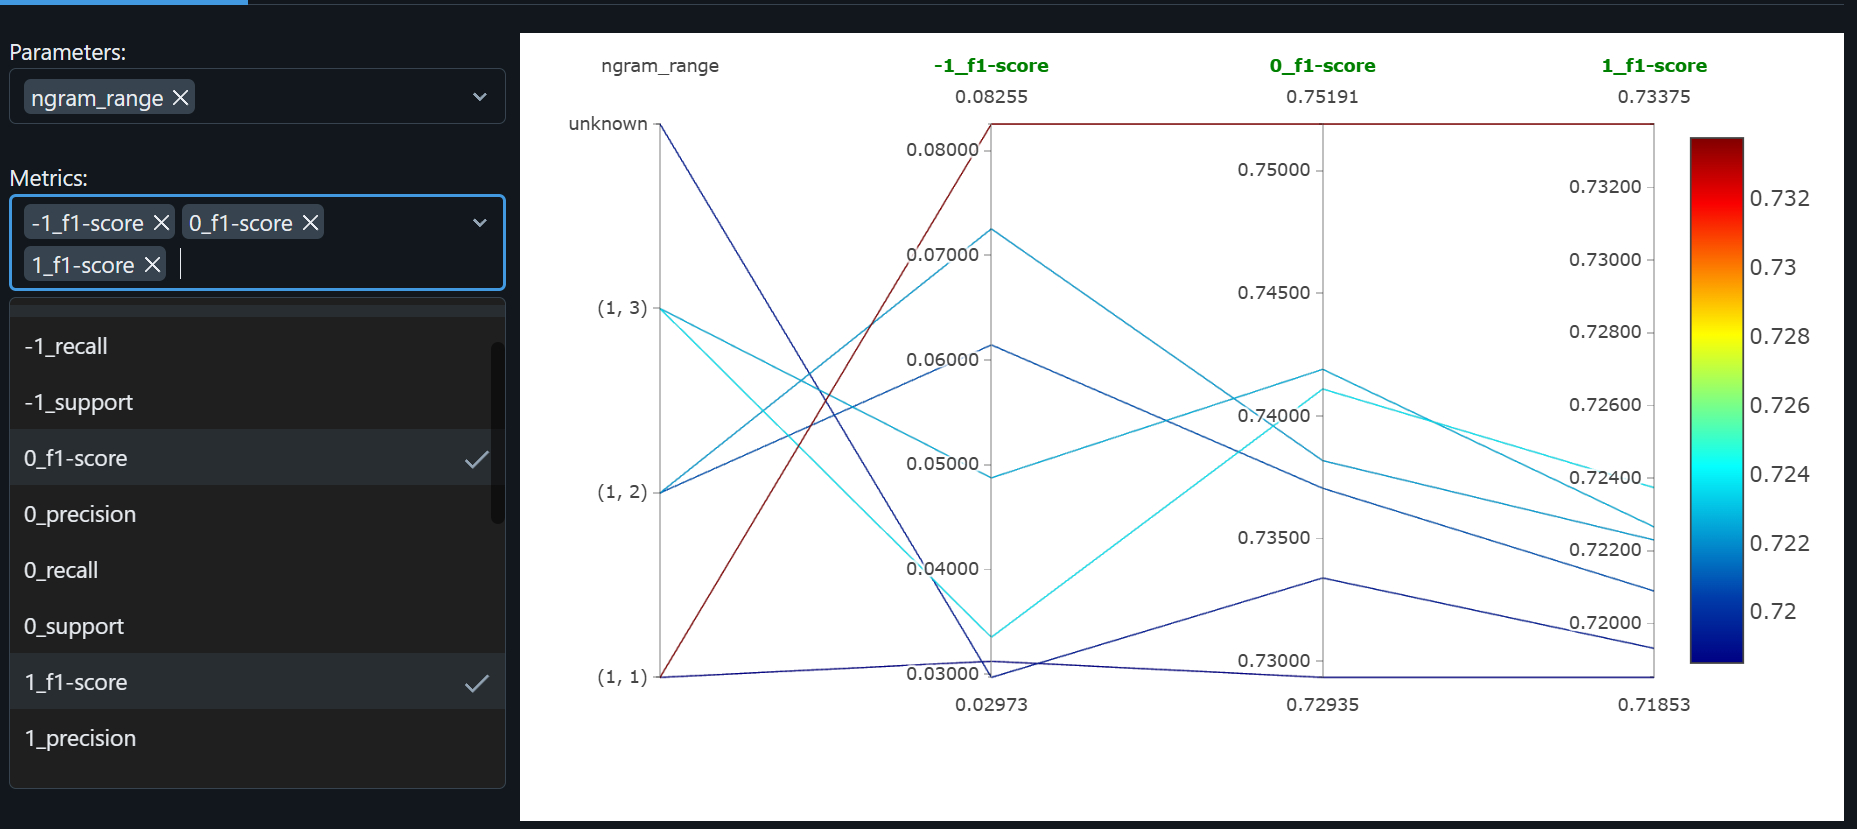

In [43]:
mlflow.set_experiment('Experiment 3 - BoW Bigram max features')

2025/04/22 23:25:42 INFO mlflow.tracking.fluent: Experiment with name 'Experiment 3 - BoW Bigram max features' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/891386377409268422', creation_time=1745339142002, experiment_id='891386377409268422', last_update_time=1745339142002, lifecycle_stage='active', name='Experiment 3 - BoW Bigram max features', tags={}>

2025/04/22 23:35:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run TFIDF_Unigram_max_features_1000 at: http://localhost:8080/#/experiments/891386377409268422/runs/63519c5fd6fc42989c9e733ac15ad25d
🧪 View experiment at: http://localhost:8080/#/experiments/891386377409268422


2025/04/22 23:35:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run TFIDF_Unigram_max_features_2000 at: http://localhost:8080/#/experiments/891386377409268422/runs/2dbd6eddcedf4931b49677d5cfee5fd3
🧪 View experiment at: http://localhost:8080/#/experiments/891386377409268422


2025/04/22 23:35:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run TFIDF_Unigram_max_features_3000 at: http://localhost:8080/#/experiments/891386377409268422/runs/0363caecfdc048deac8fe3f9e7490b44
🧪 View experiment at: http://localhost:8080/#/experiments/891386377409268422


2025/04/22 23:35:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run TFIDF_Unigram_max_features_4000 at: http://localhost:8080/#/experiments/891386377409268422/runs/f7837581c1d94c7eaf76b4d74450653c
🧪 View experiment at: http://localhost:8080/#/experiments/891386377409268422


2025/04/22 23:35:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run TFIDF_Unigram_max_features_5000 at: http://localhost:8080/#/experiments/891386377409268422/runs/6ec53e3814b04235b11a2bd029b8dc4b
🧪 View experiment at: http://localhost:8080/#/experiments/891386377409268422


2025/04/22 23:35:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run TFIDF_Unigram_max_features_6000 at: http://localhost:8080/#/experiments/891386377409268422/runs/b419946f42564a40801cfe20ecefce08
🧪 View experiment at: http://localhost:8080/#/experiments/891386377409268422


2025/04/22 23:36:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run TFIDF_Unigram_max_features_7000 at: http://localhost:8080/#/experiments/891386377409268422/runs/ee8e0da91b7546d6944b5a4d42ed1880
🧪 View experiment at: http://localhost:8080/#/experiments/891386377409268422


2025/04/22 23:36:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run TFIDF_Unigram_max_features_8000 at: http://localhost:8080/#/experiments/891386377409268422/runs/ec34c5eae9fd4170a4faba9193fbd5a3
🧪 View experiment at: http://localhost:8080/#/experiments/891386377409268422


2025/04/22 23:36:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run TFIDF_Unigram_max_features_9000 at: http://localhost:8080/#/experiments/891386377409268422/runs/27eebb13175347449f12e2aa0b5cb93b
🧪 View experiment at: http://localhost:8080/#/experiments/891386377409268422


2025/04/22 23:36:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run TFIDF_Unigram_max_features_10000 at: http://localhost:8080/#/experiments/891386377409268422/runs/2c32913eb939469fb263d4e67ec1bc07
🧪 View experiment at: http://localhost:8080/#/experiments/891386377409268422


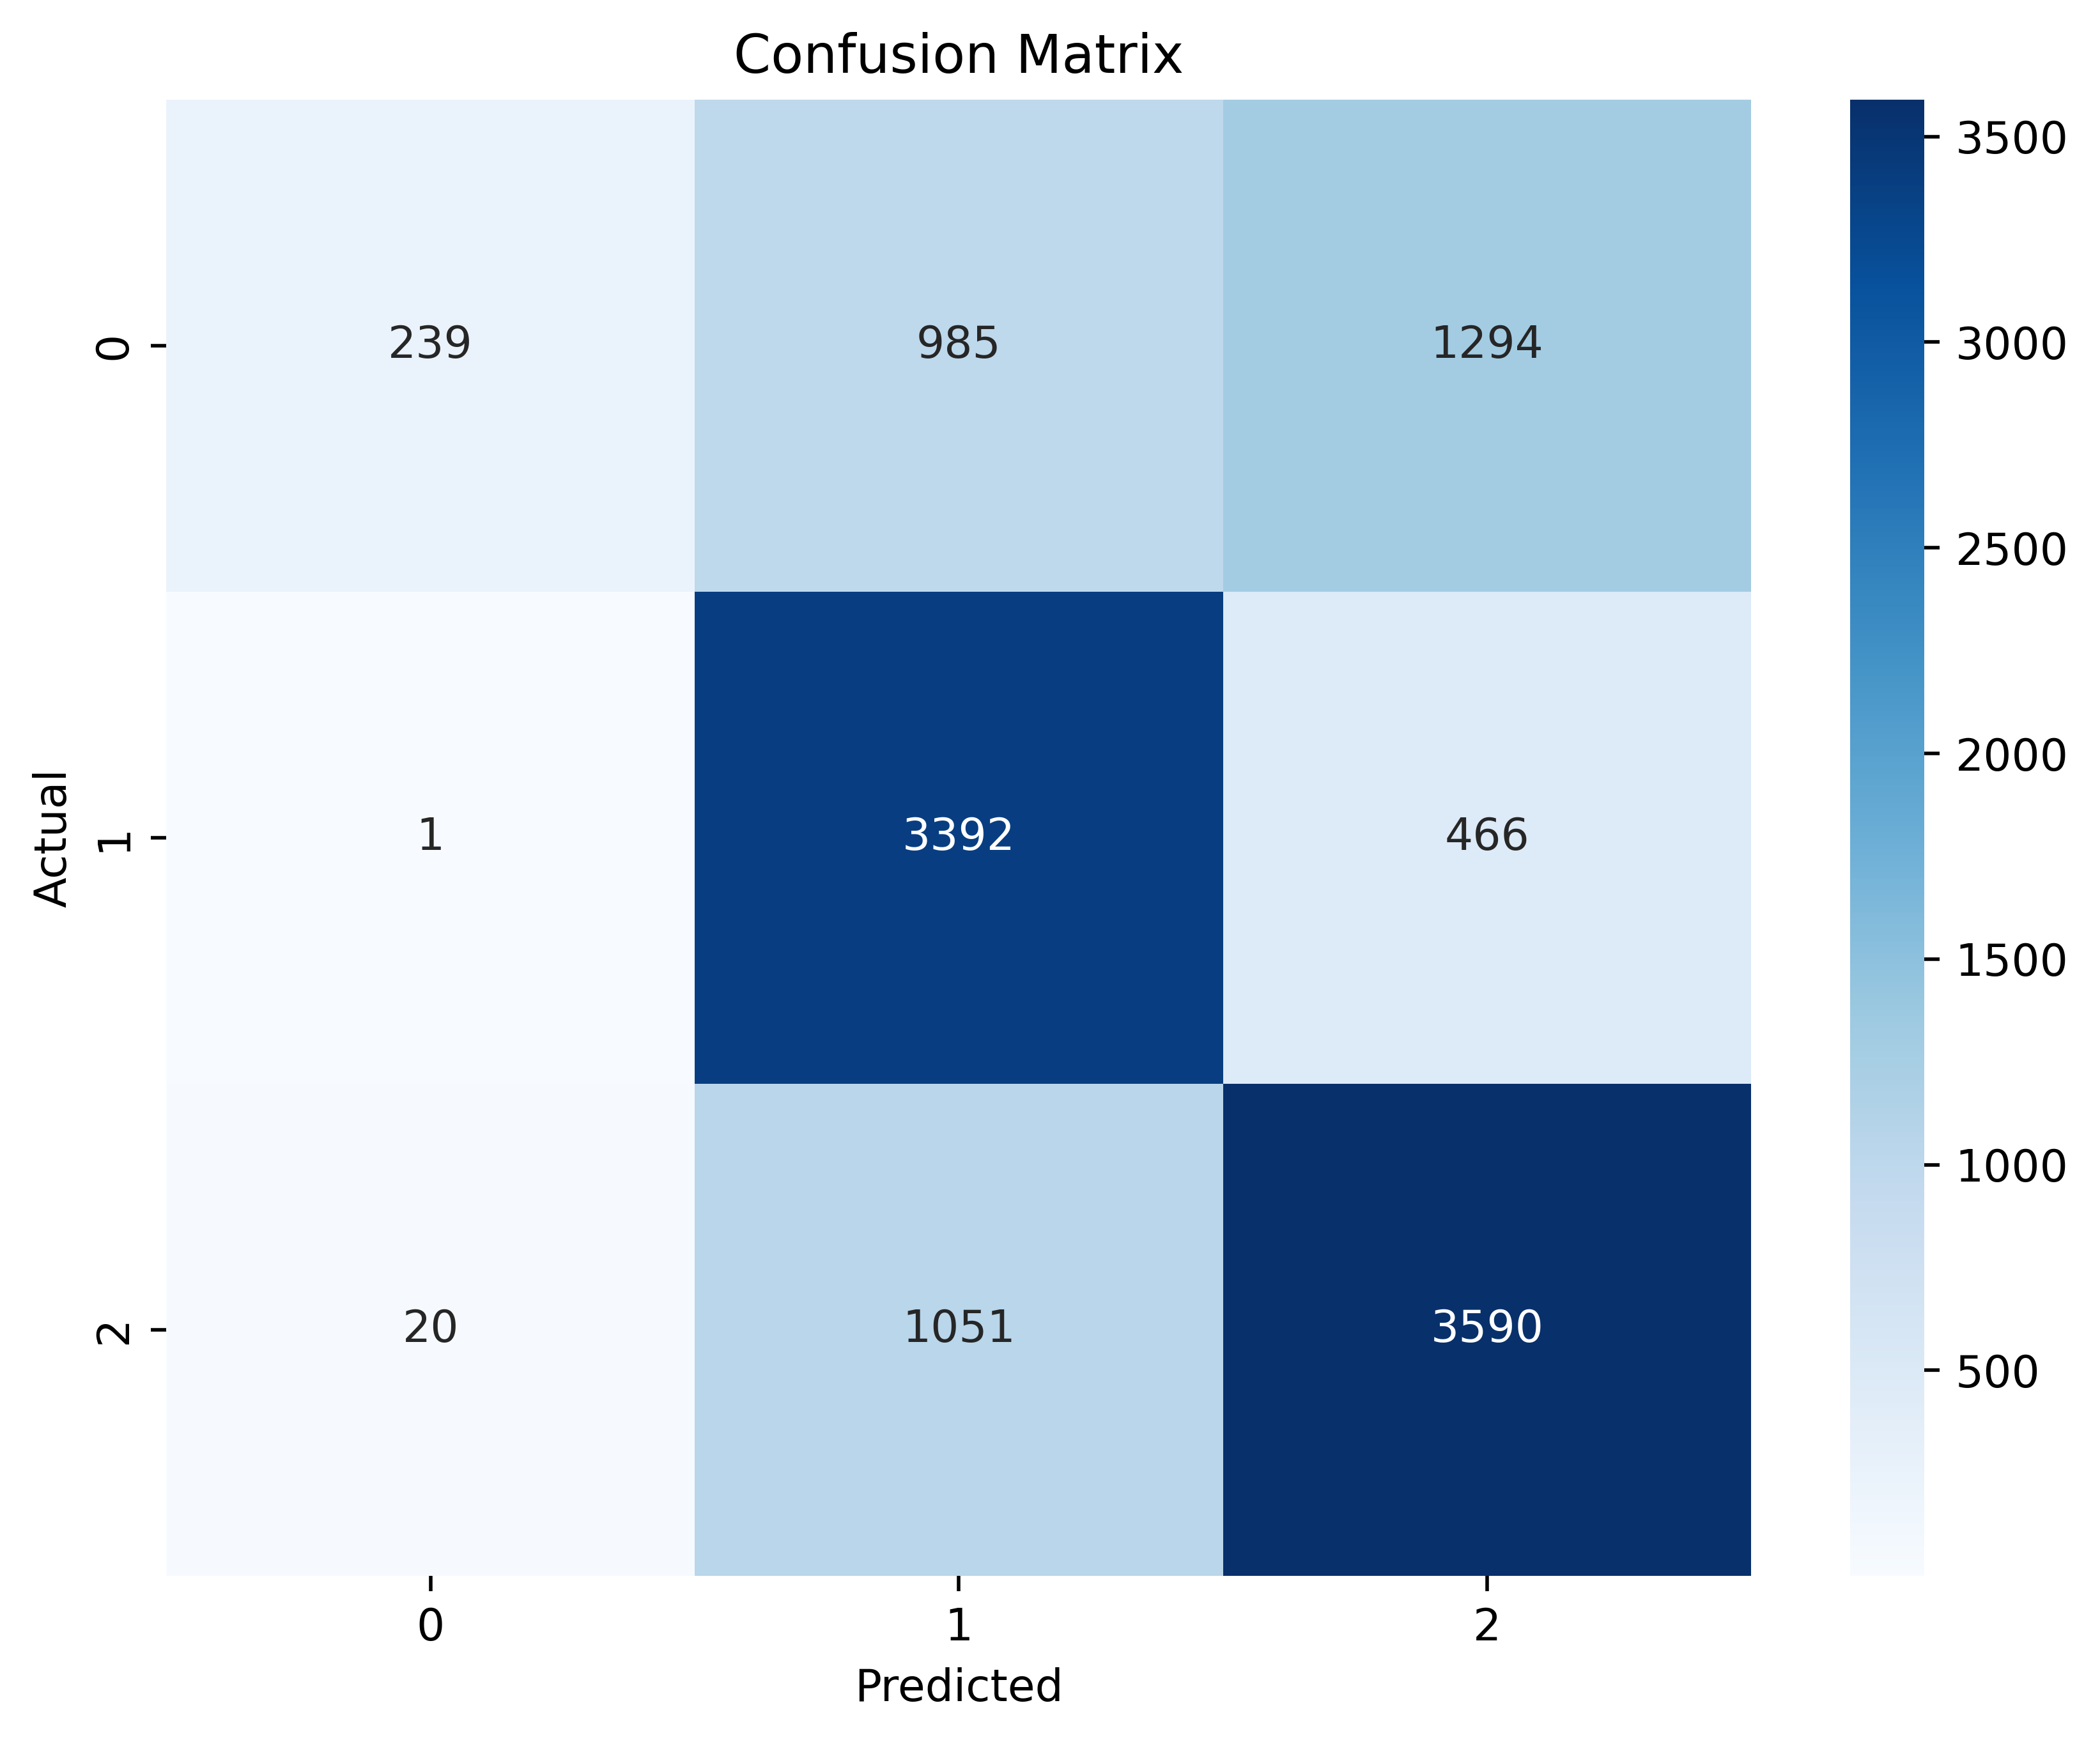

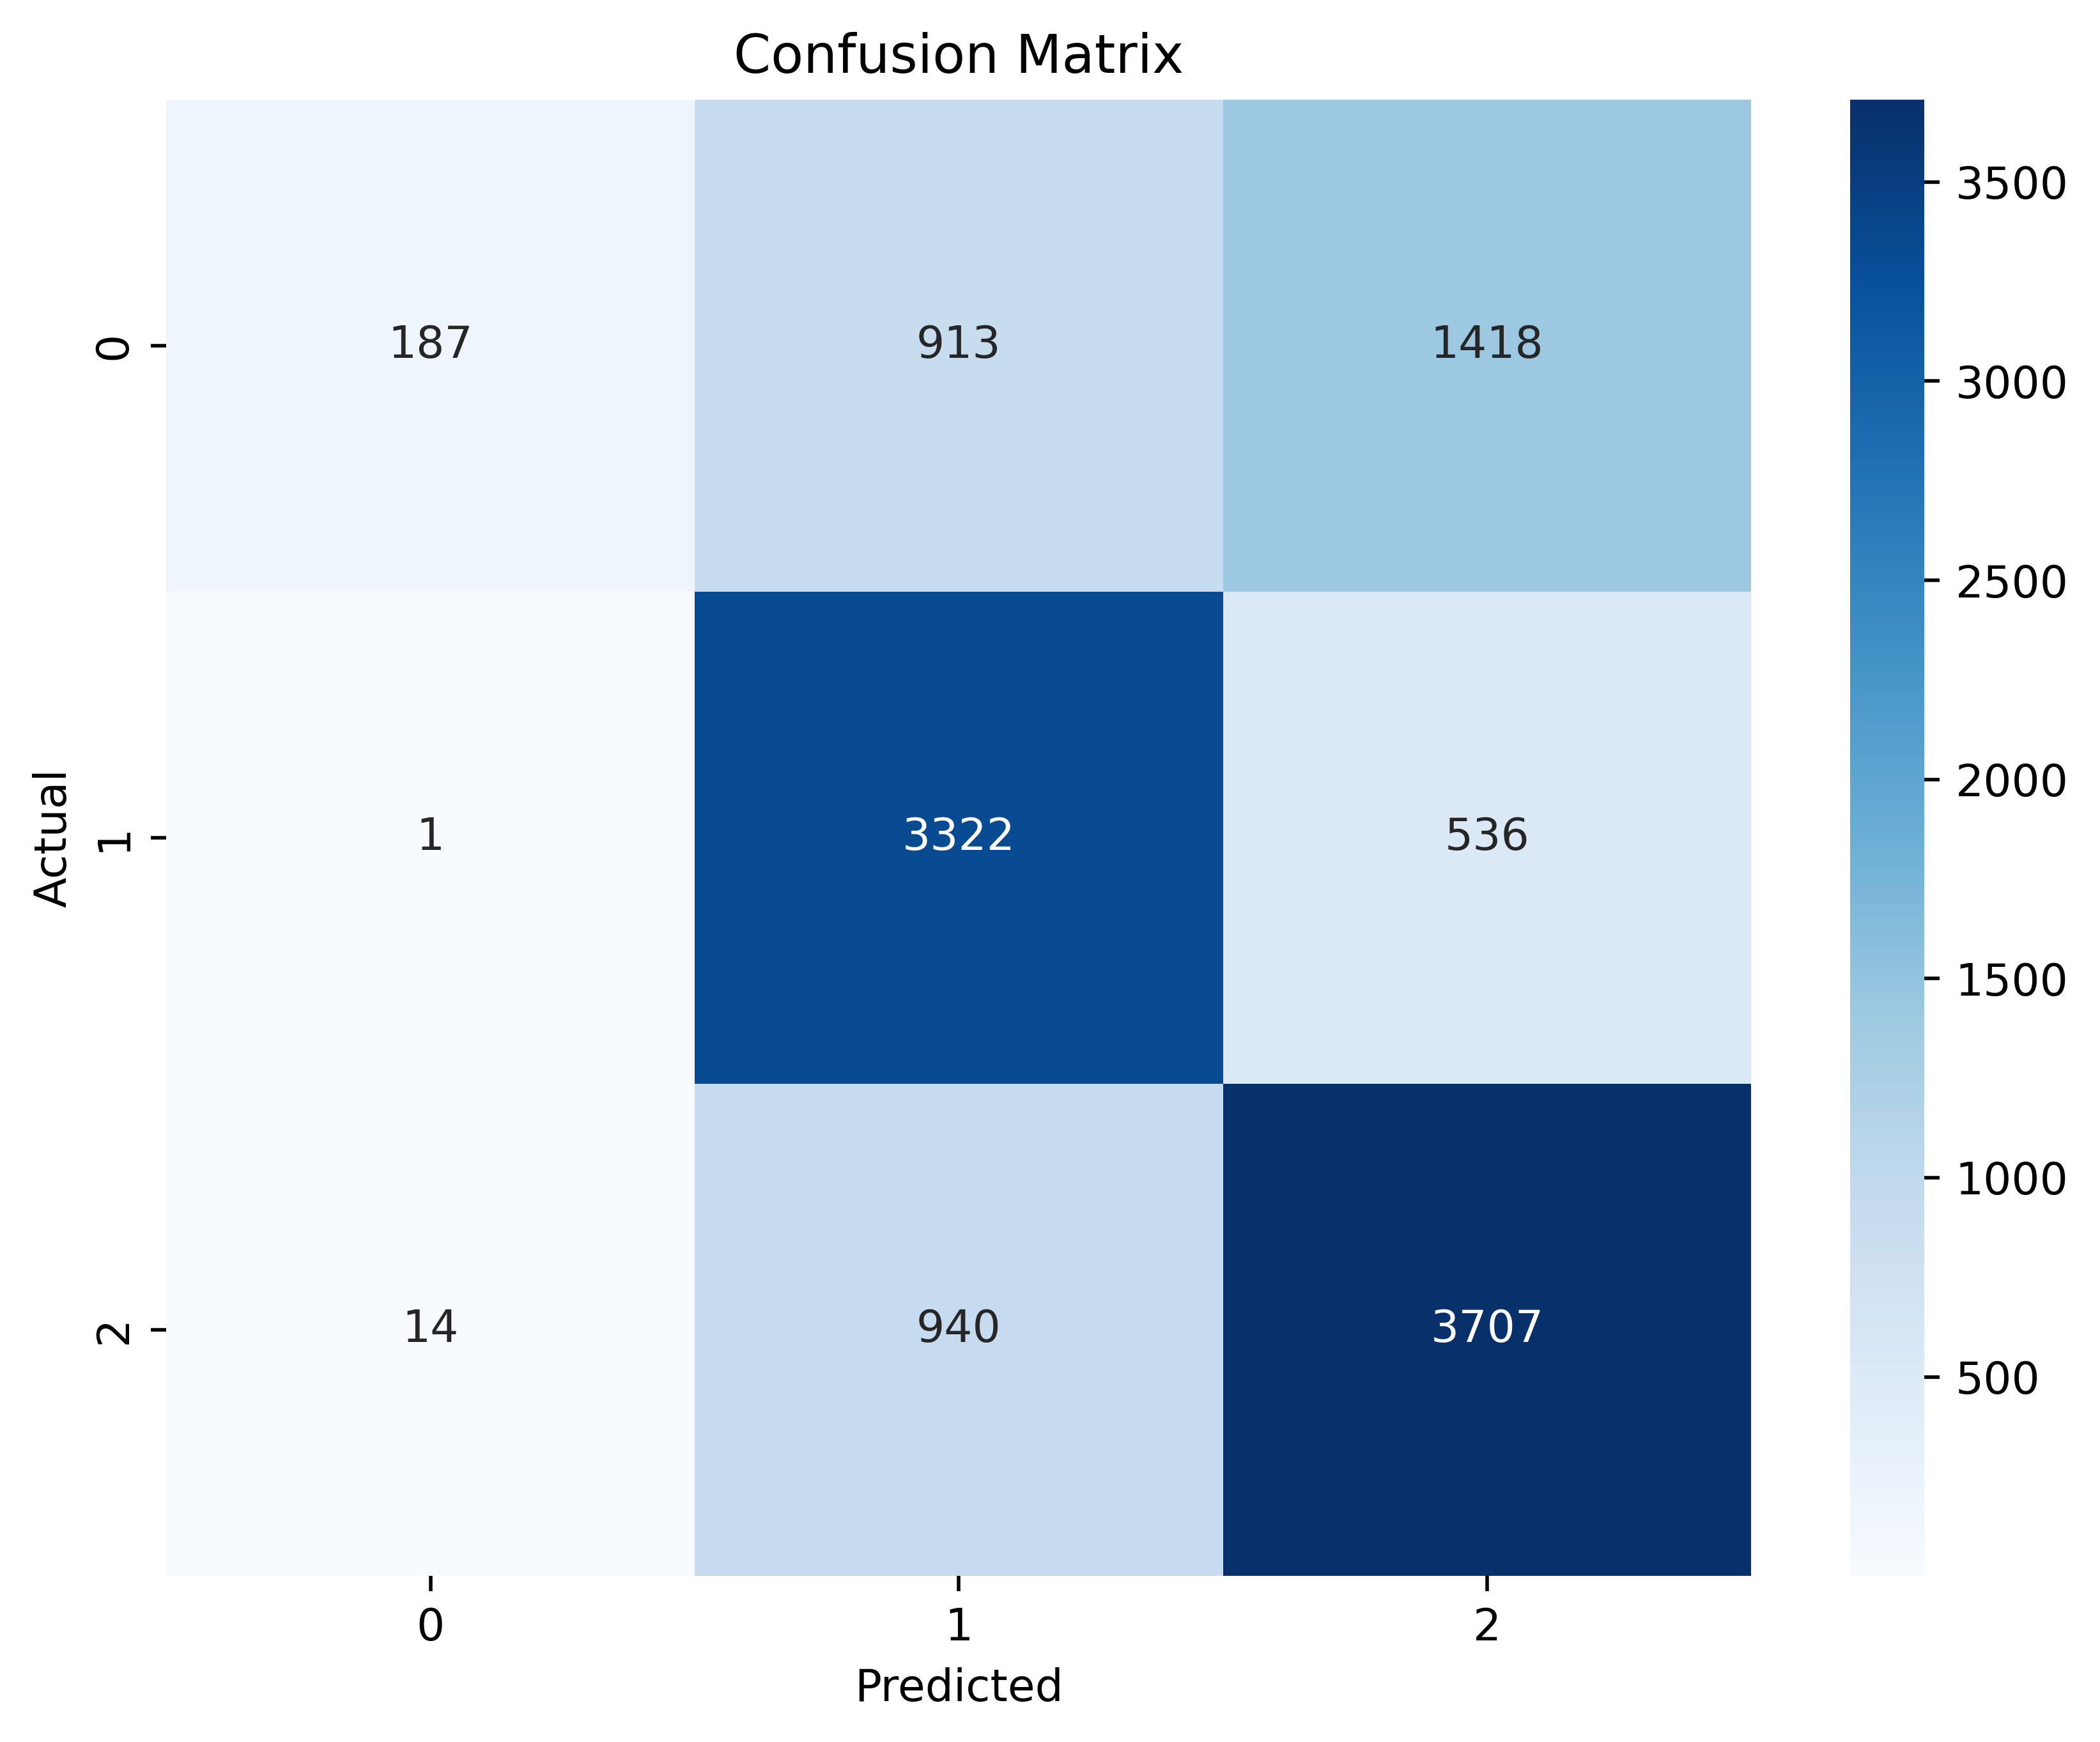

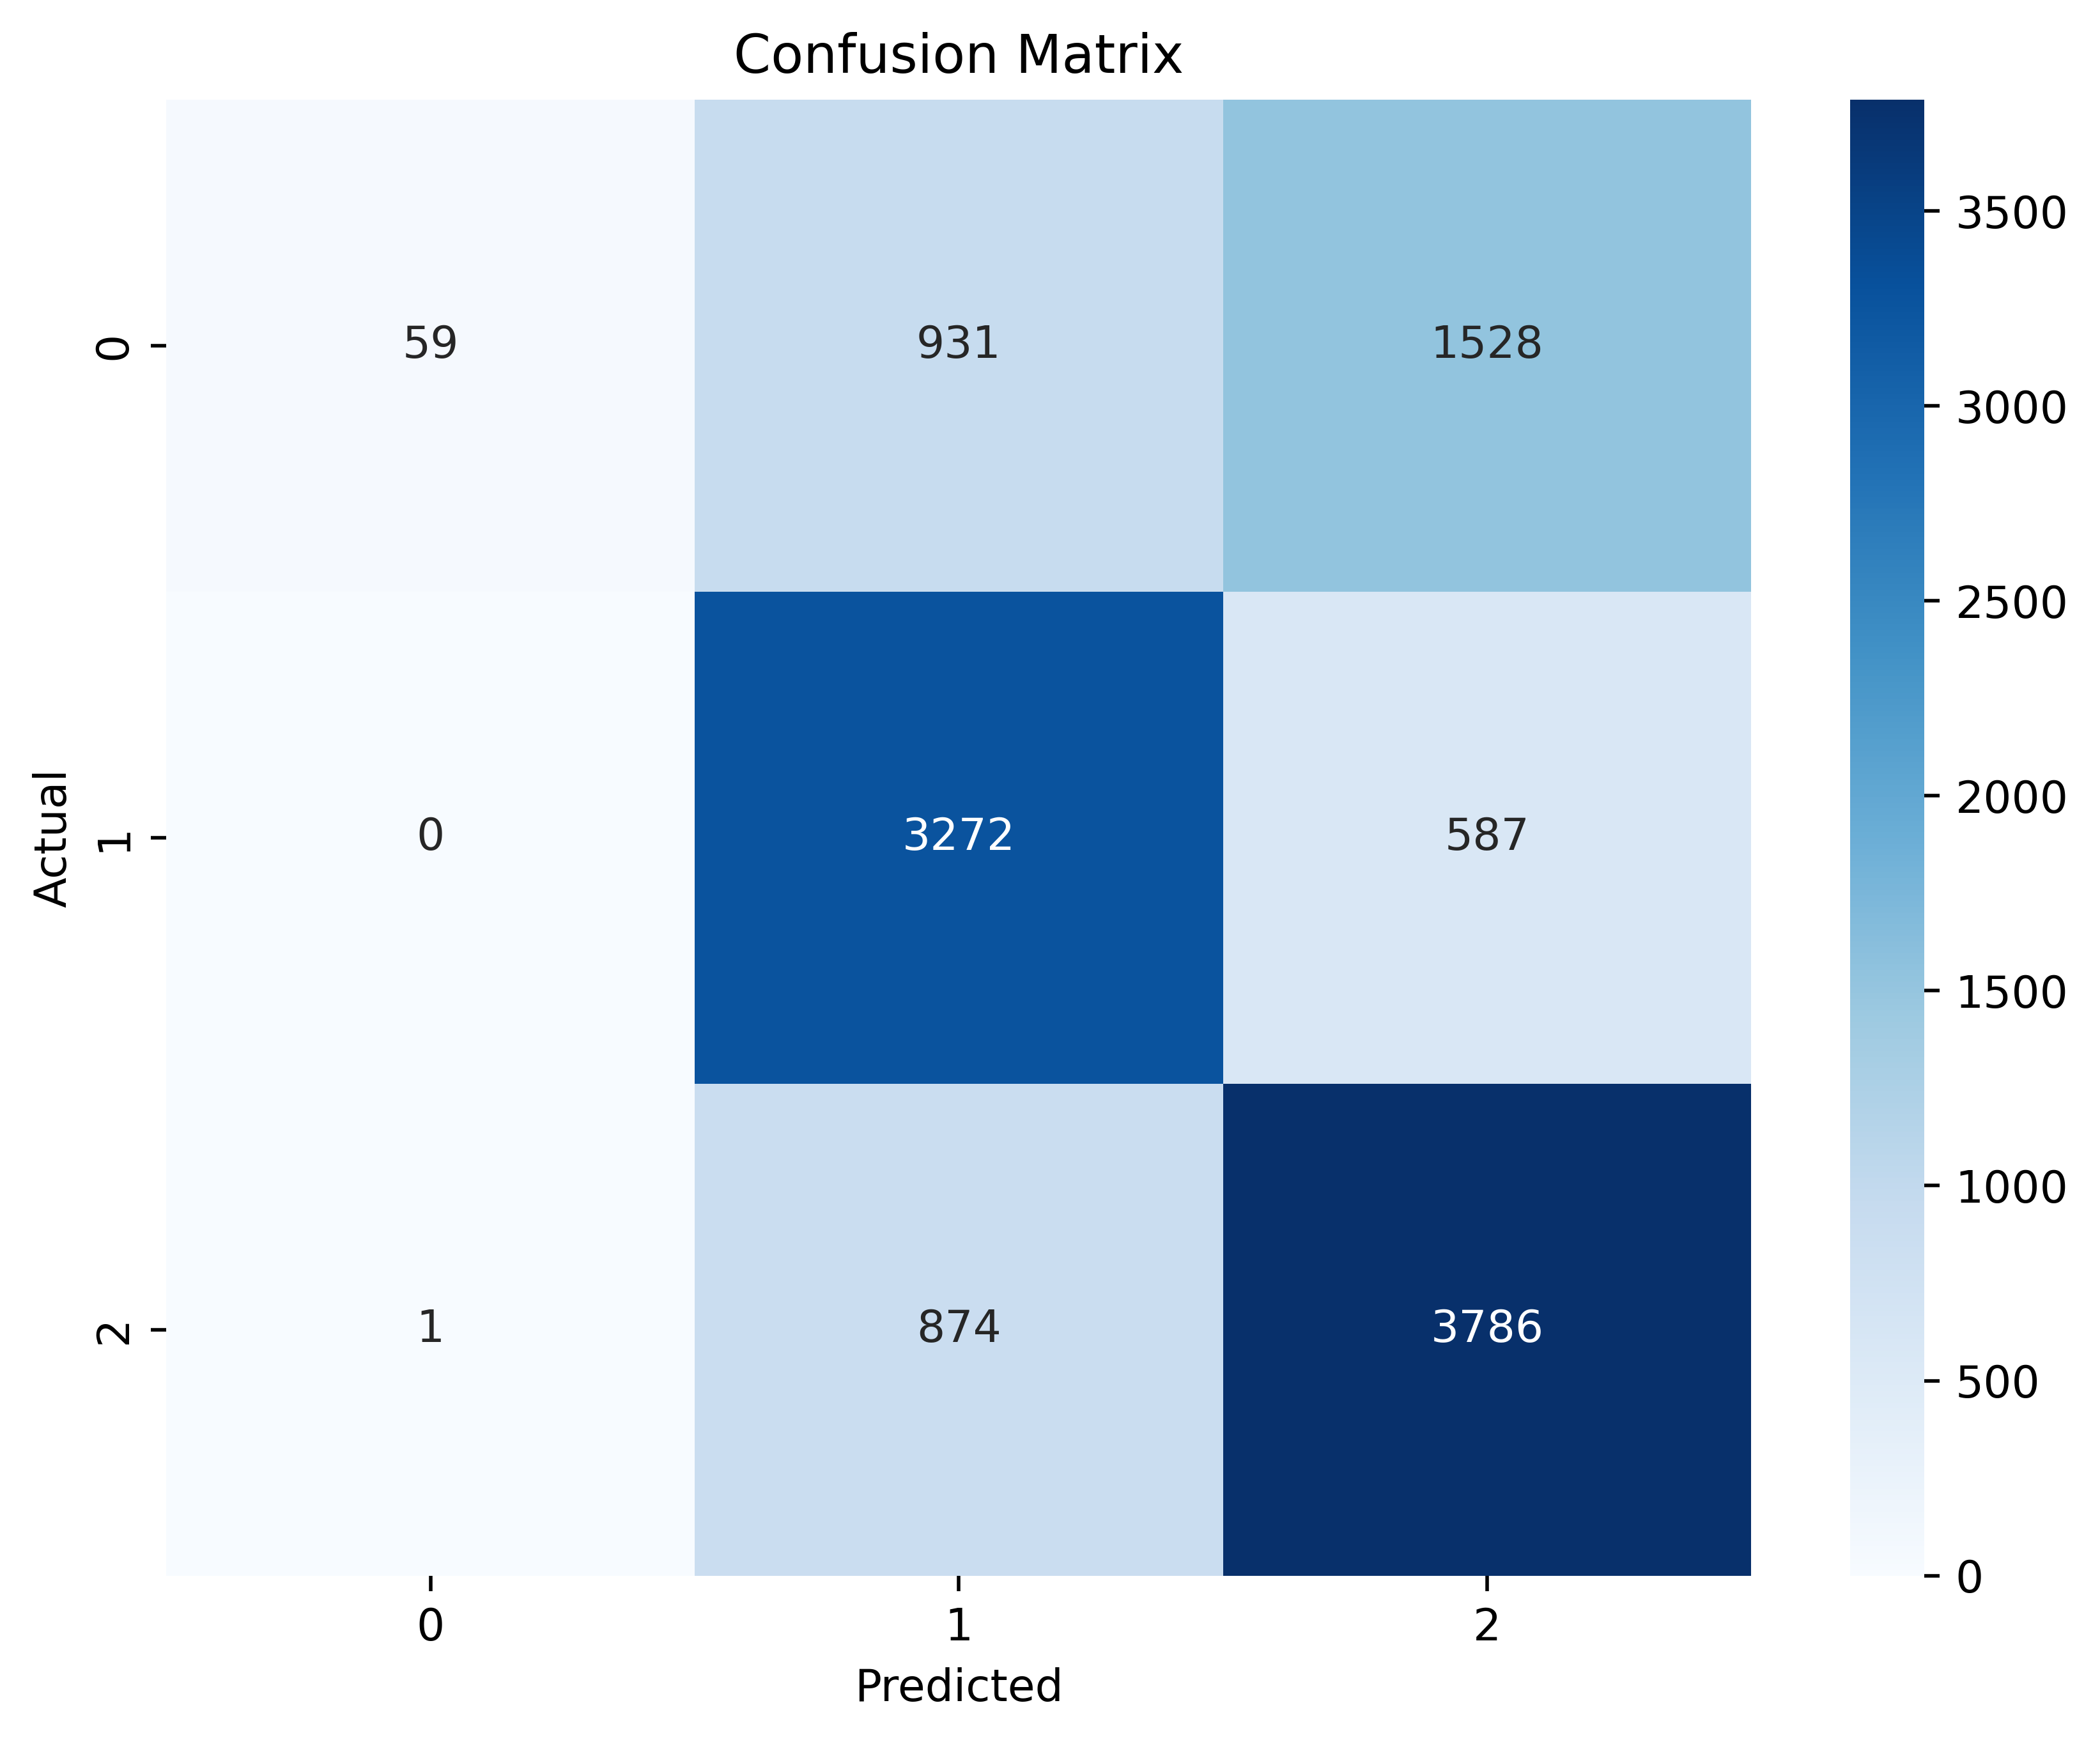

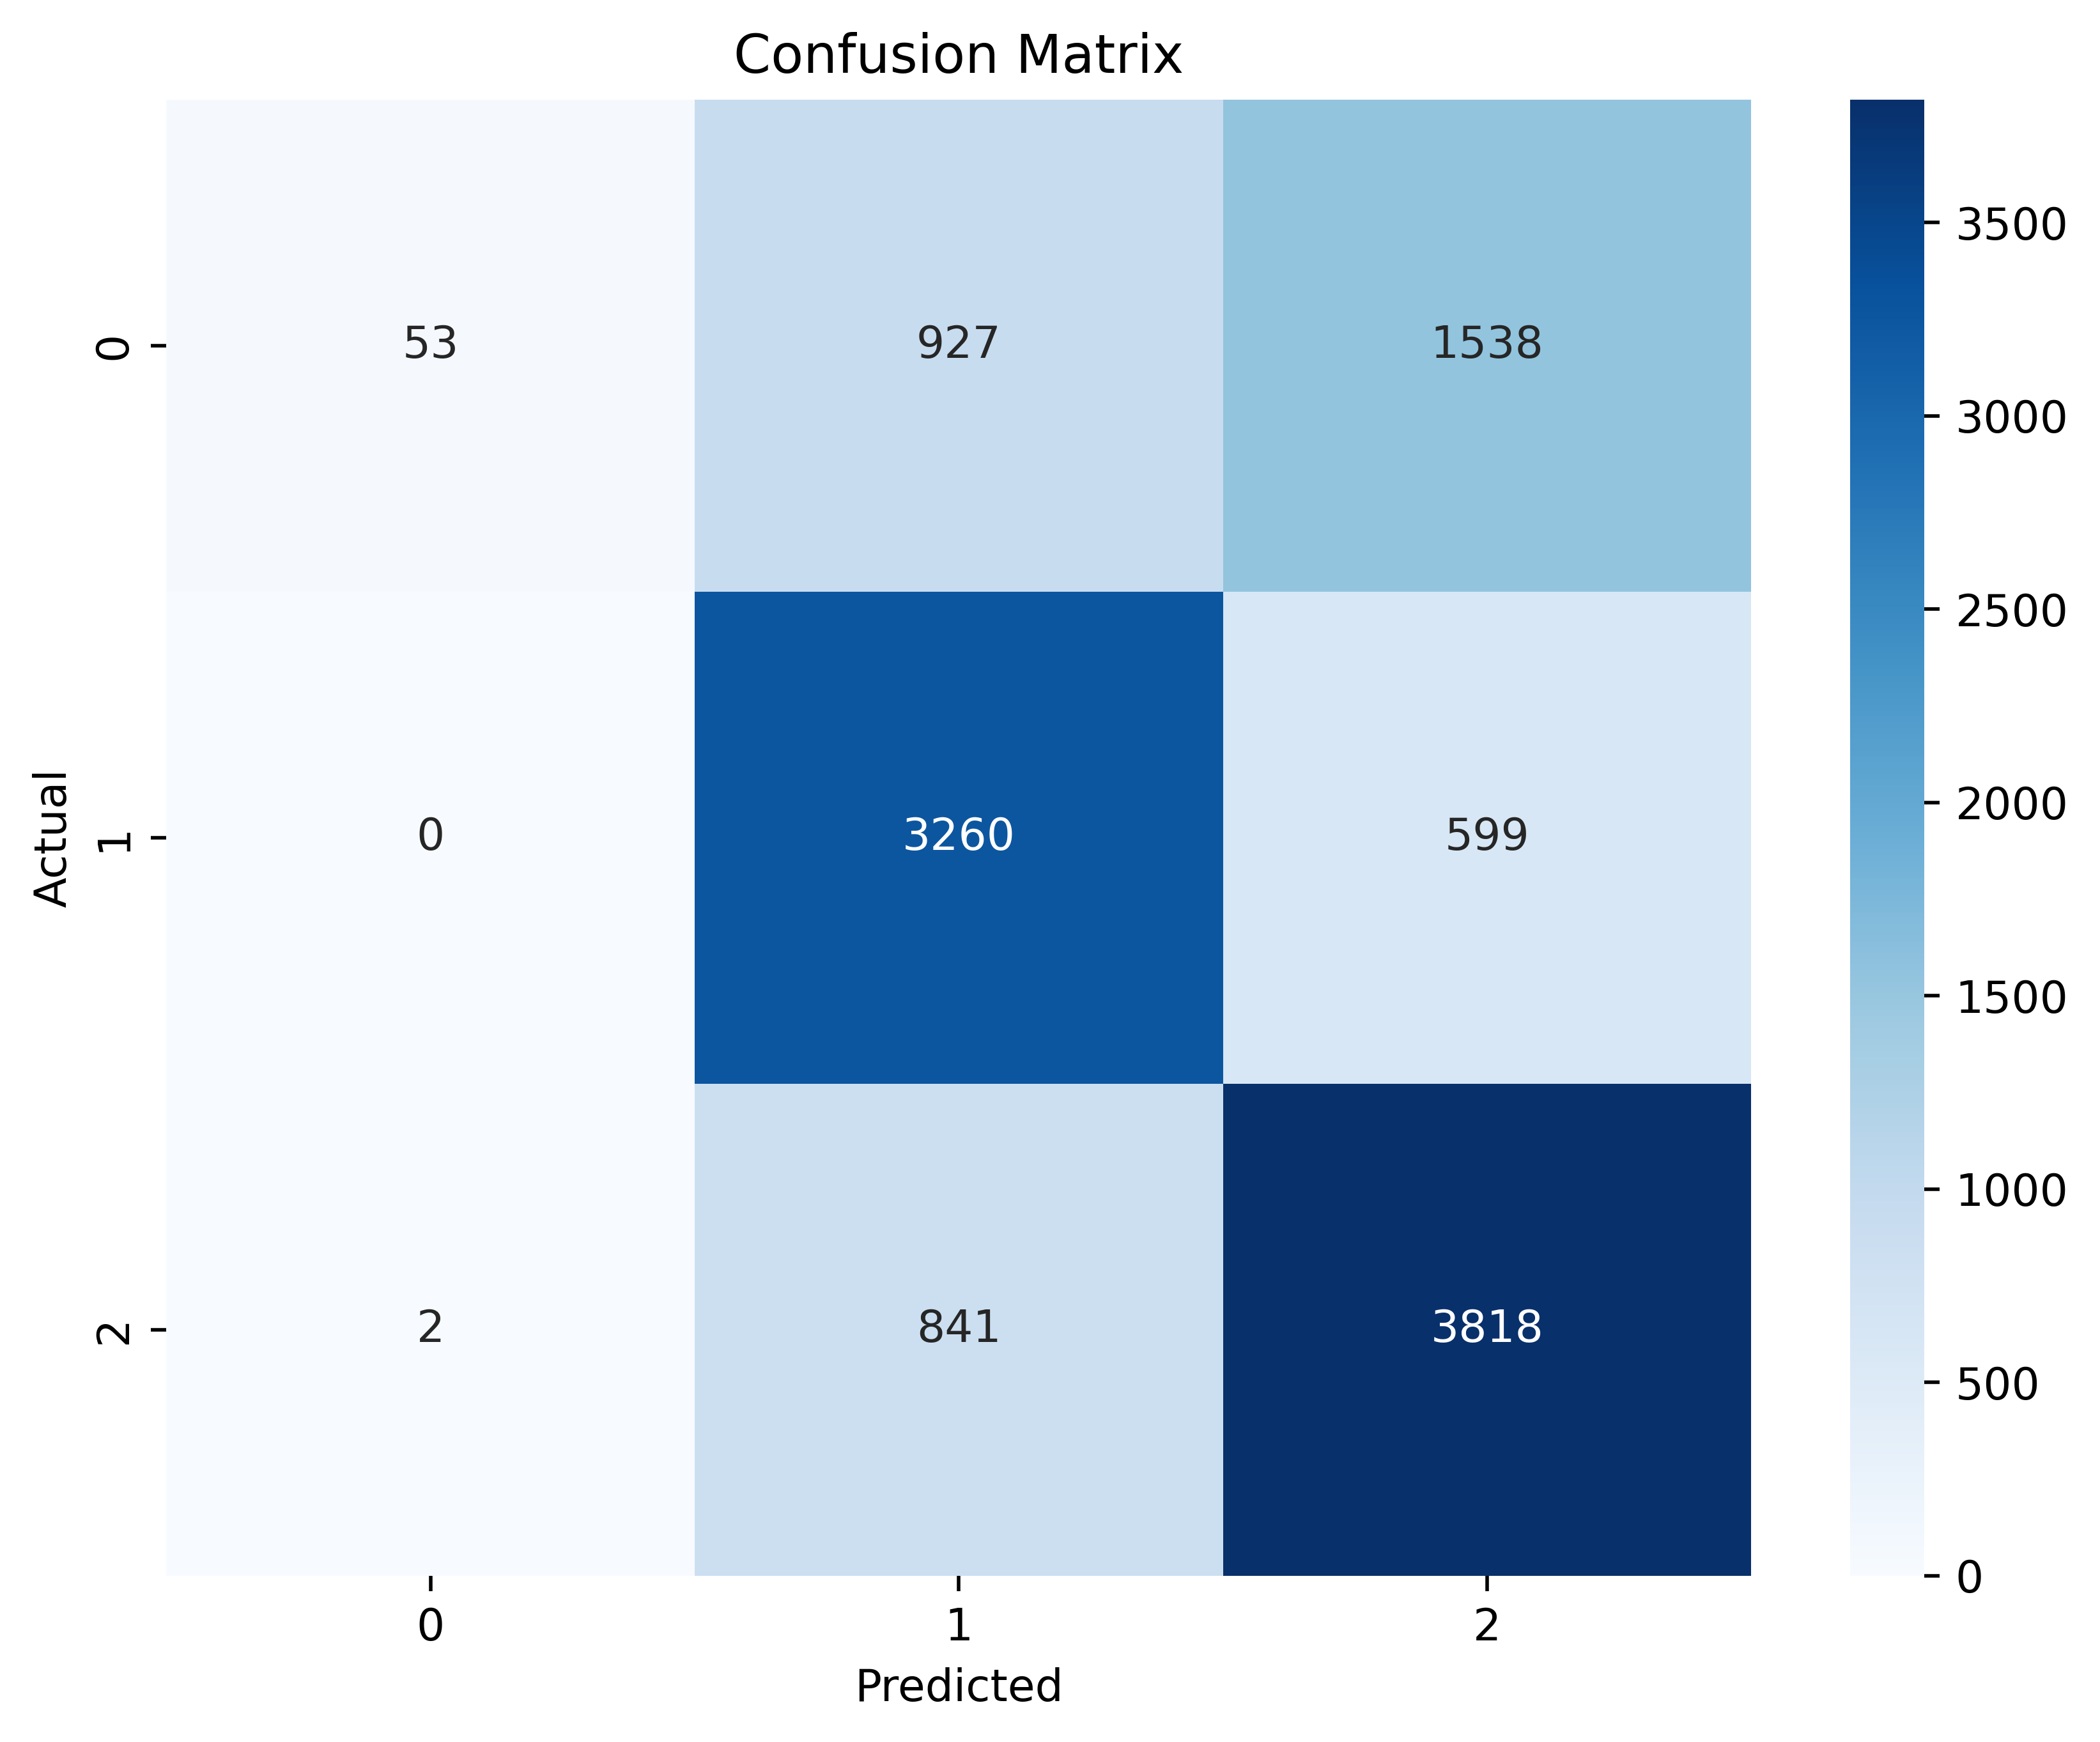

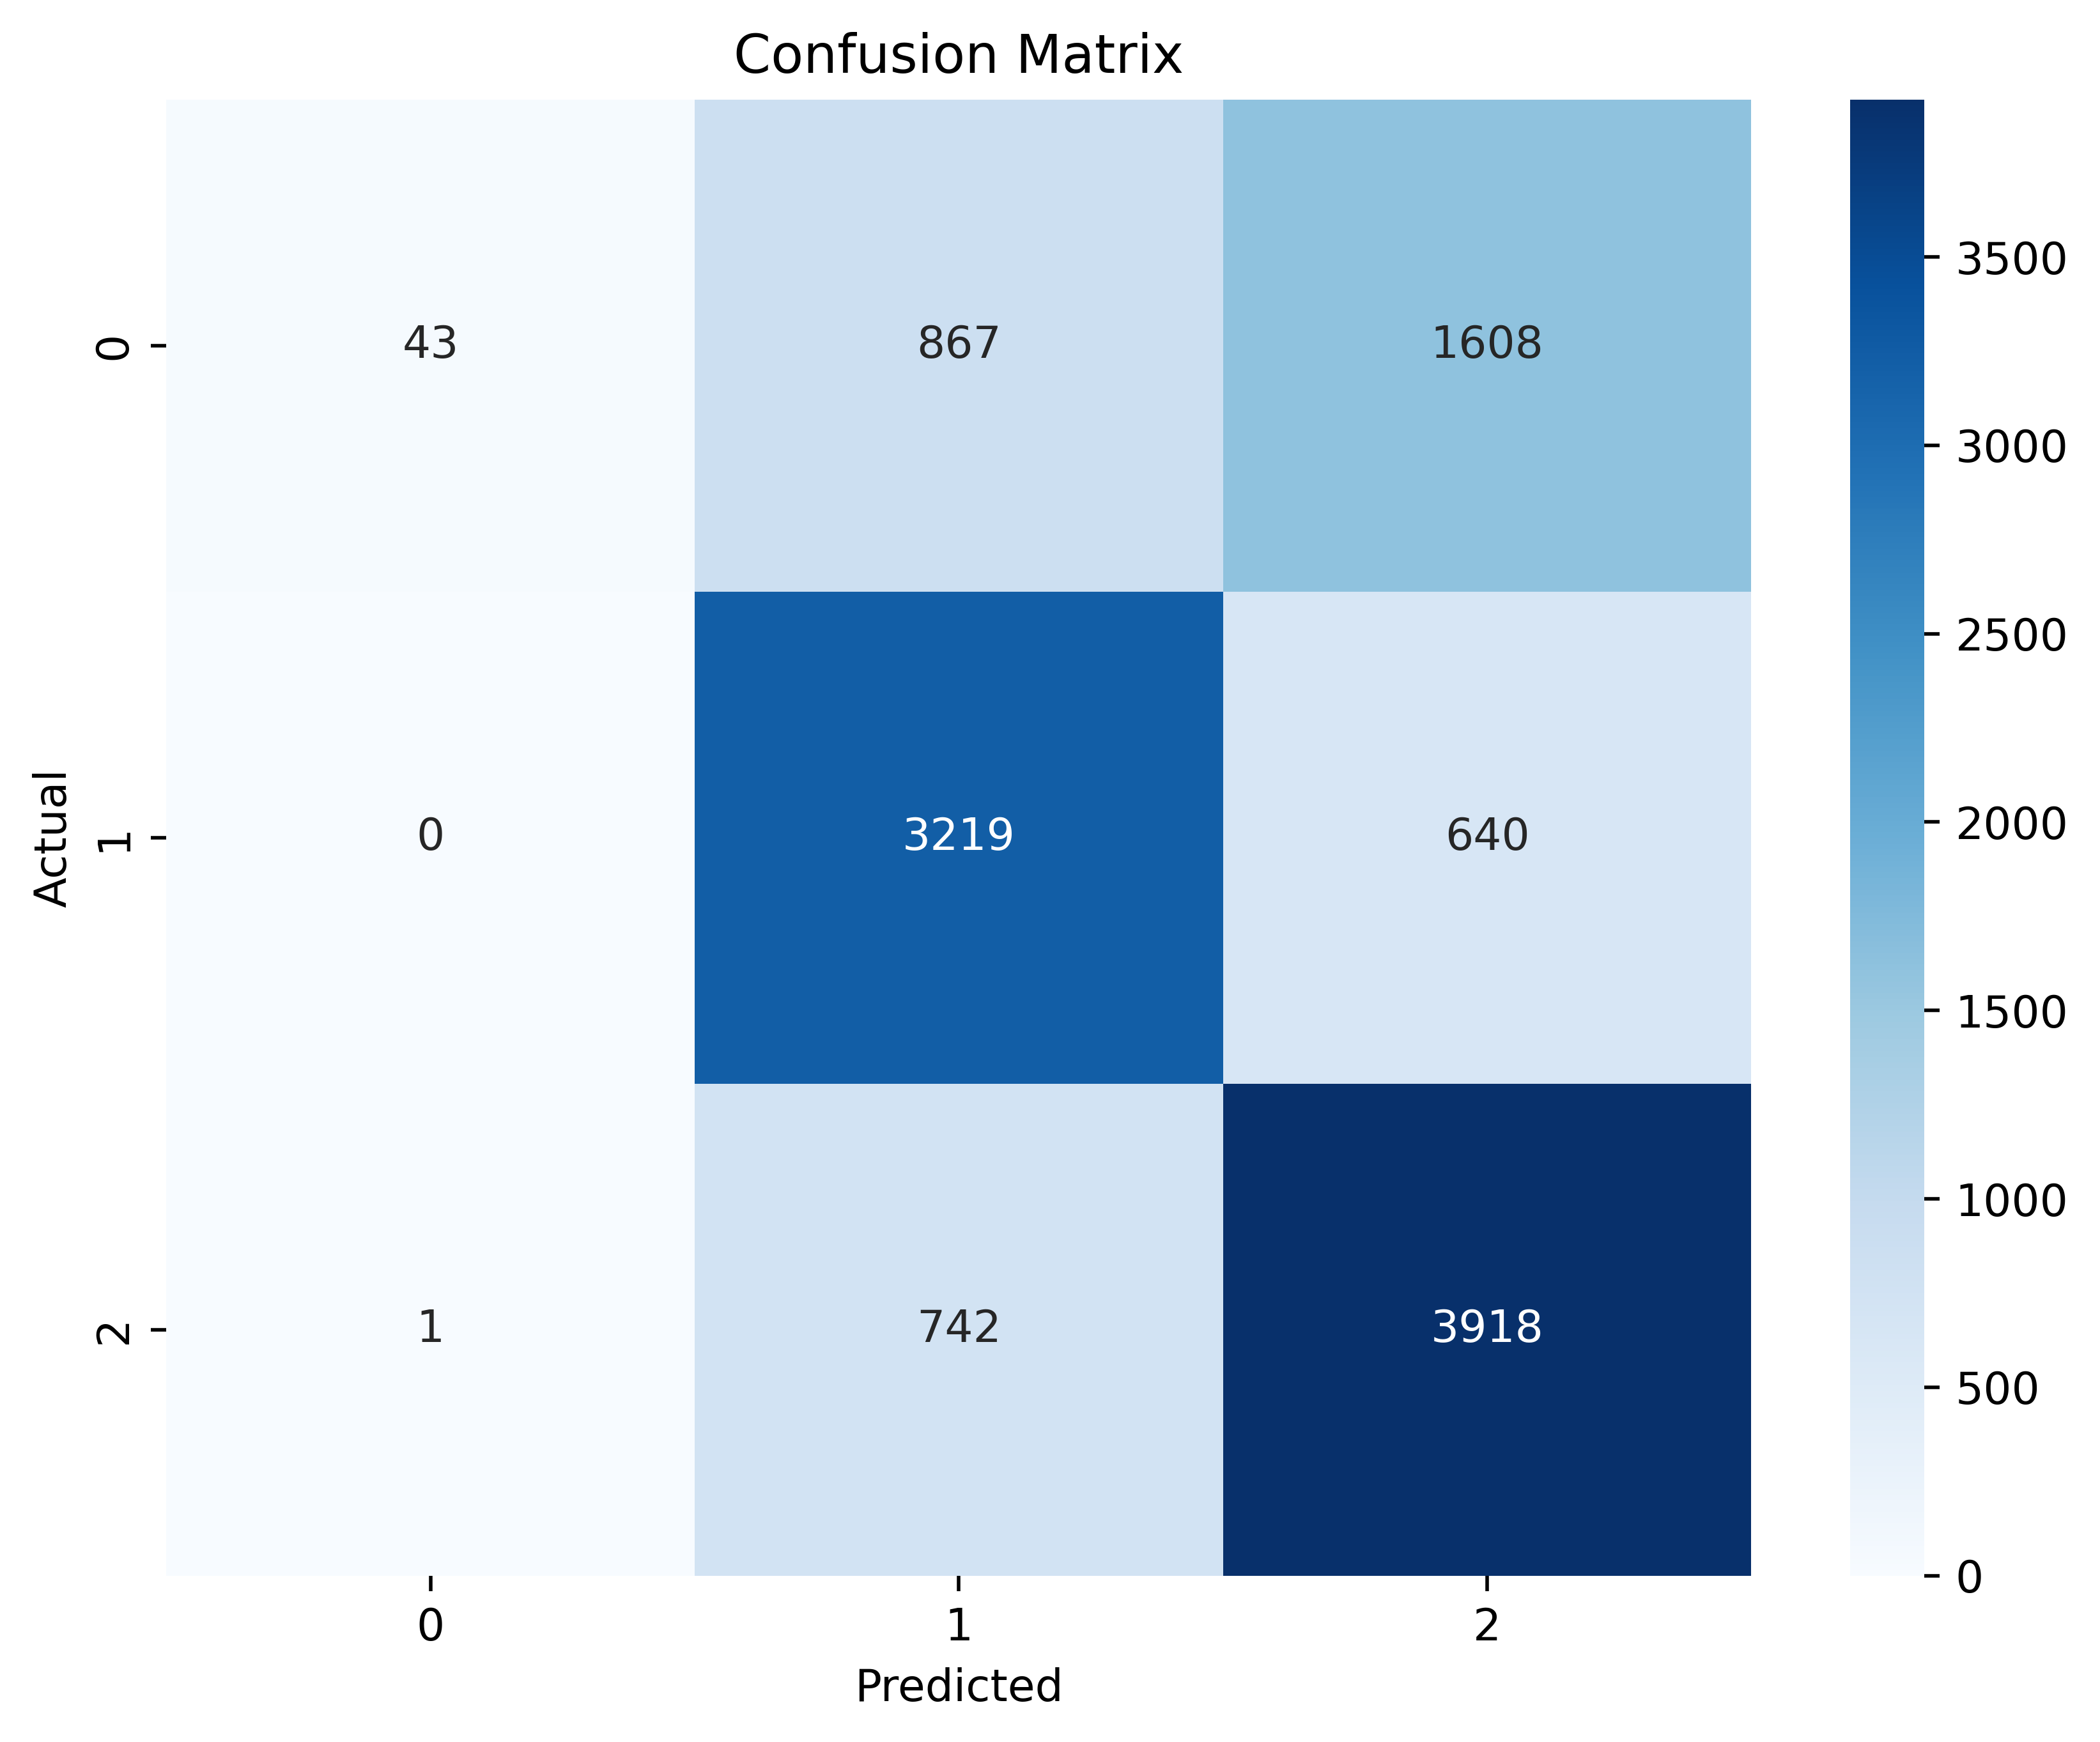

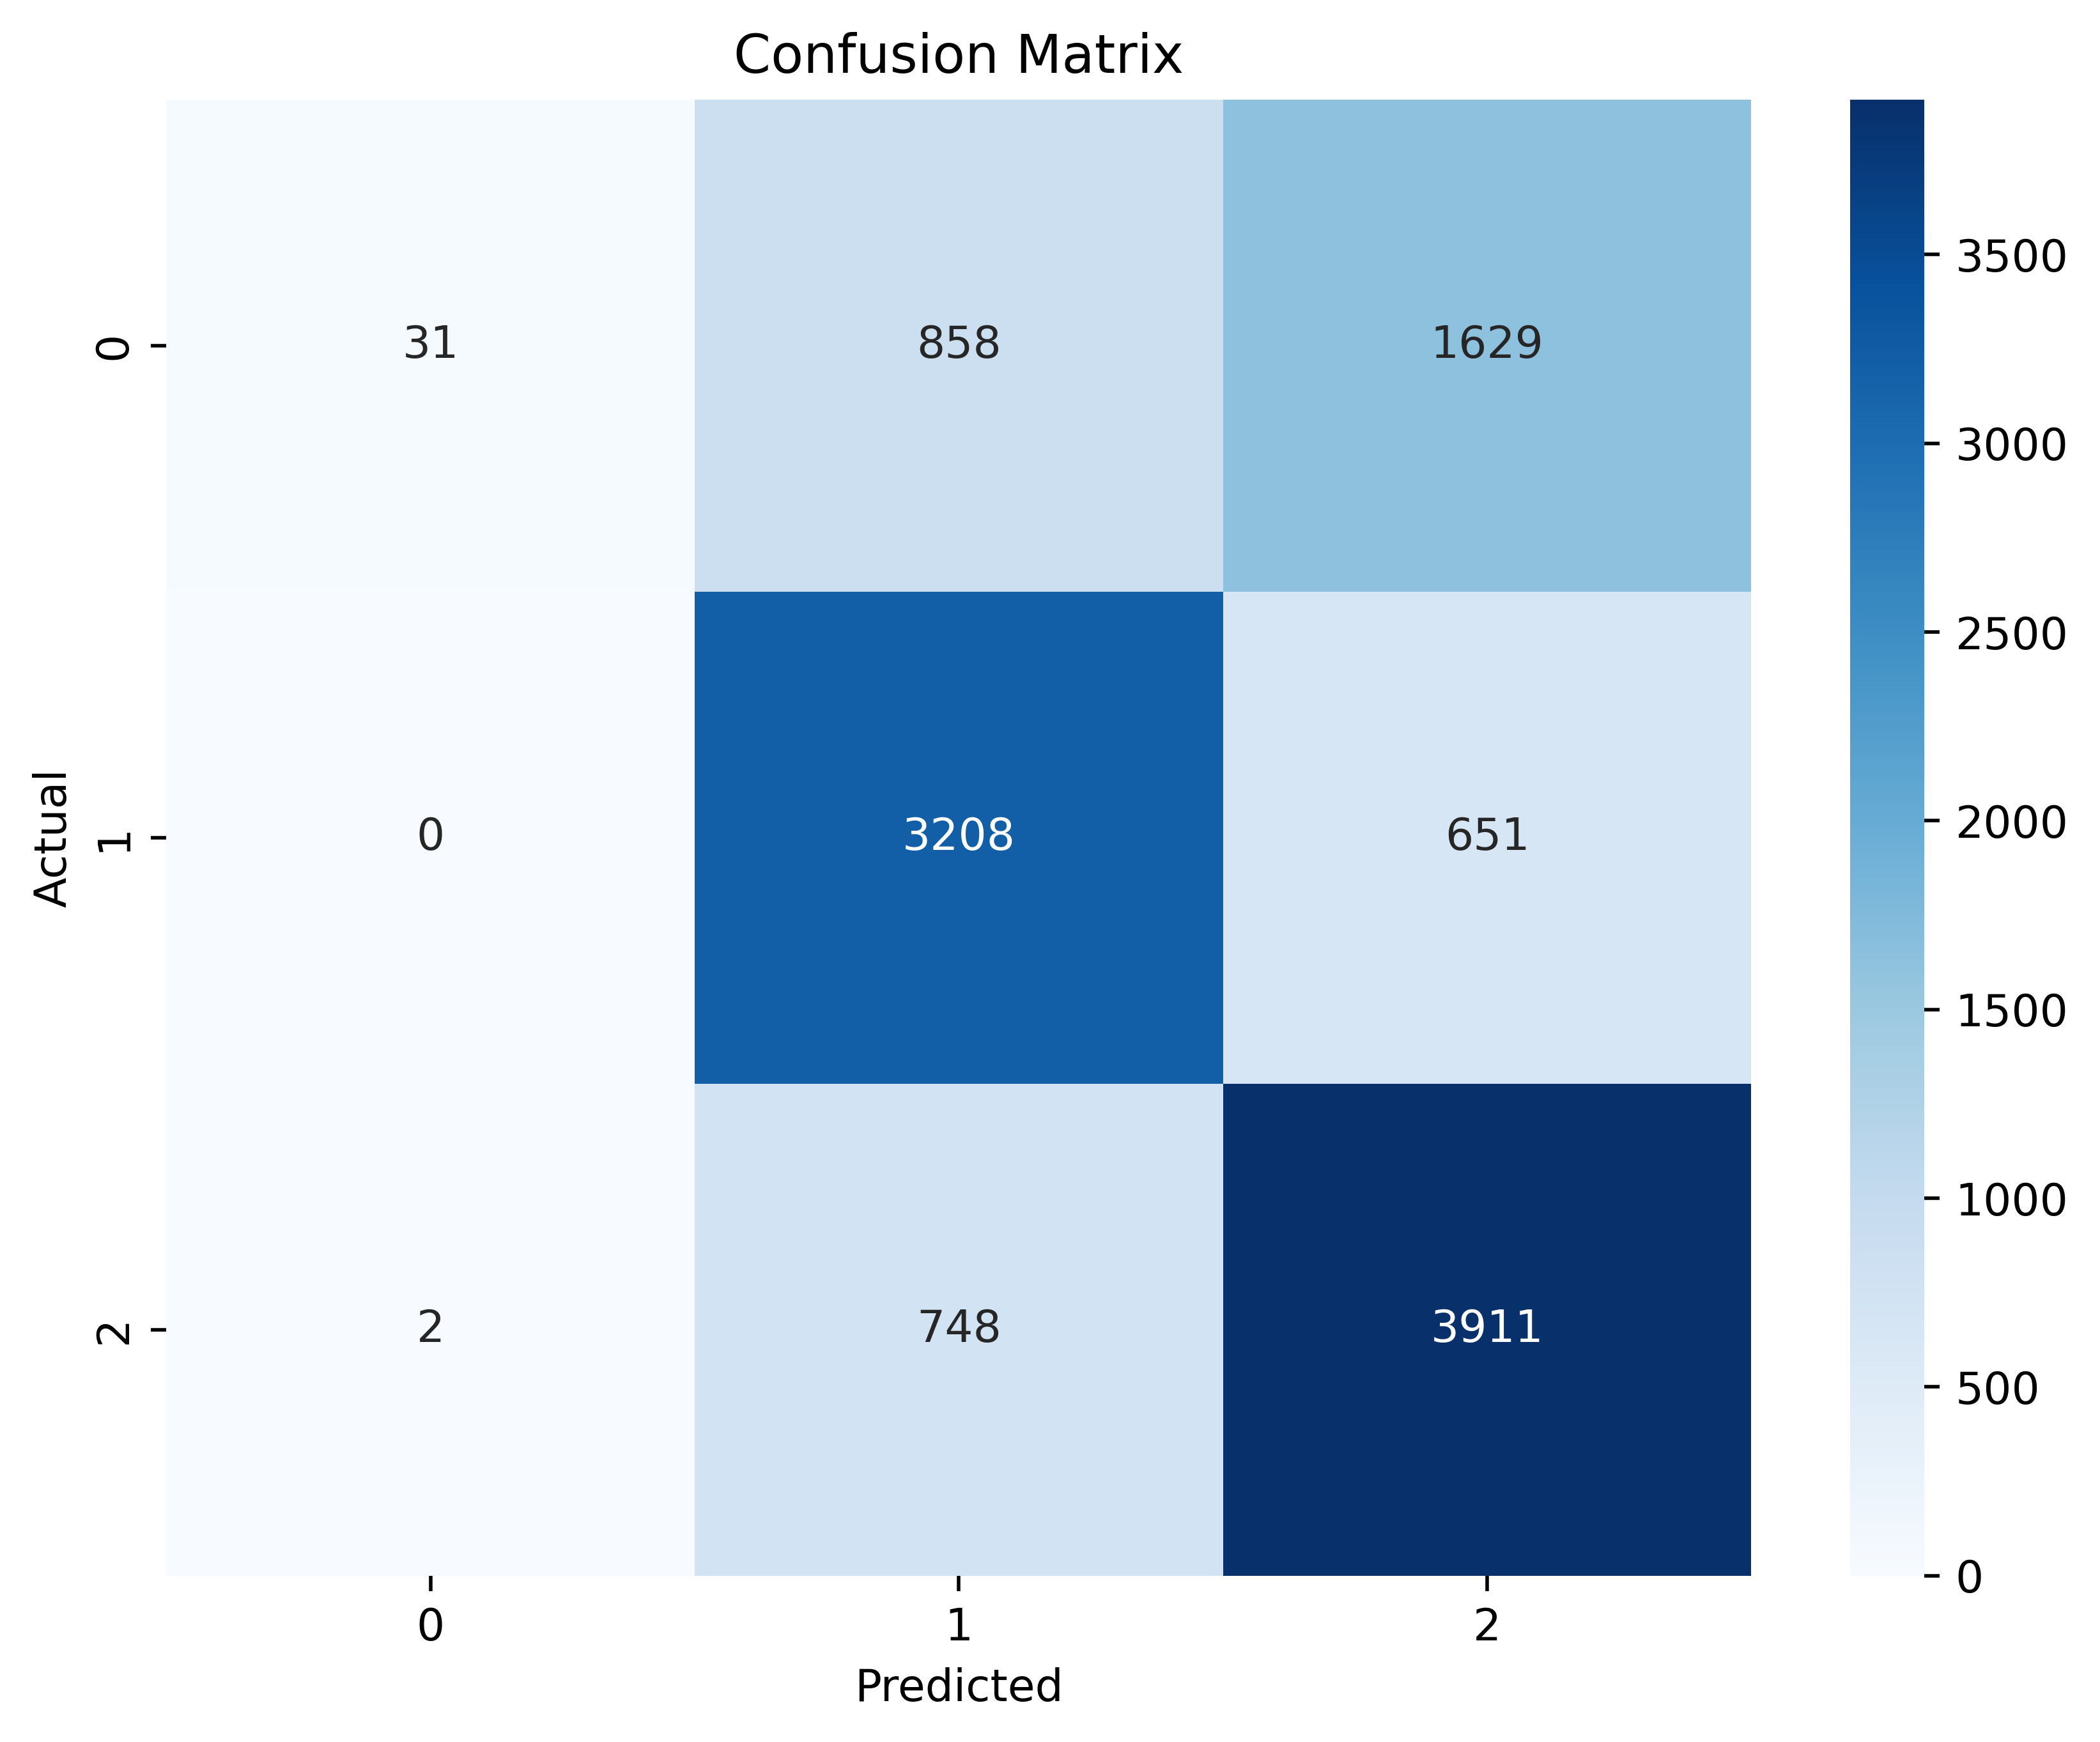

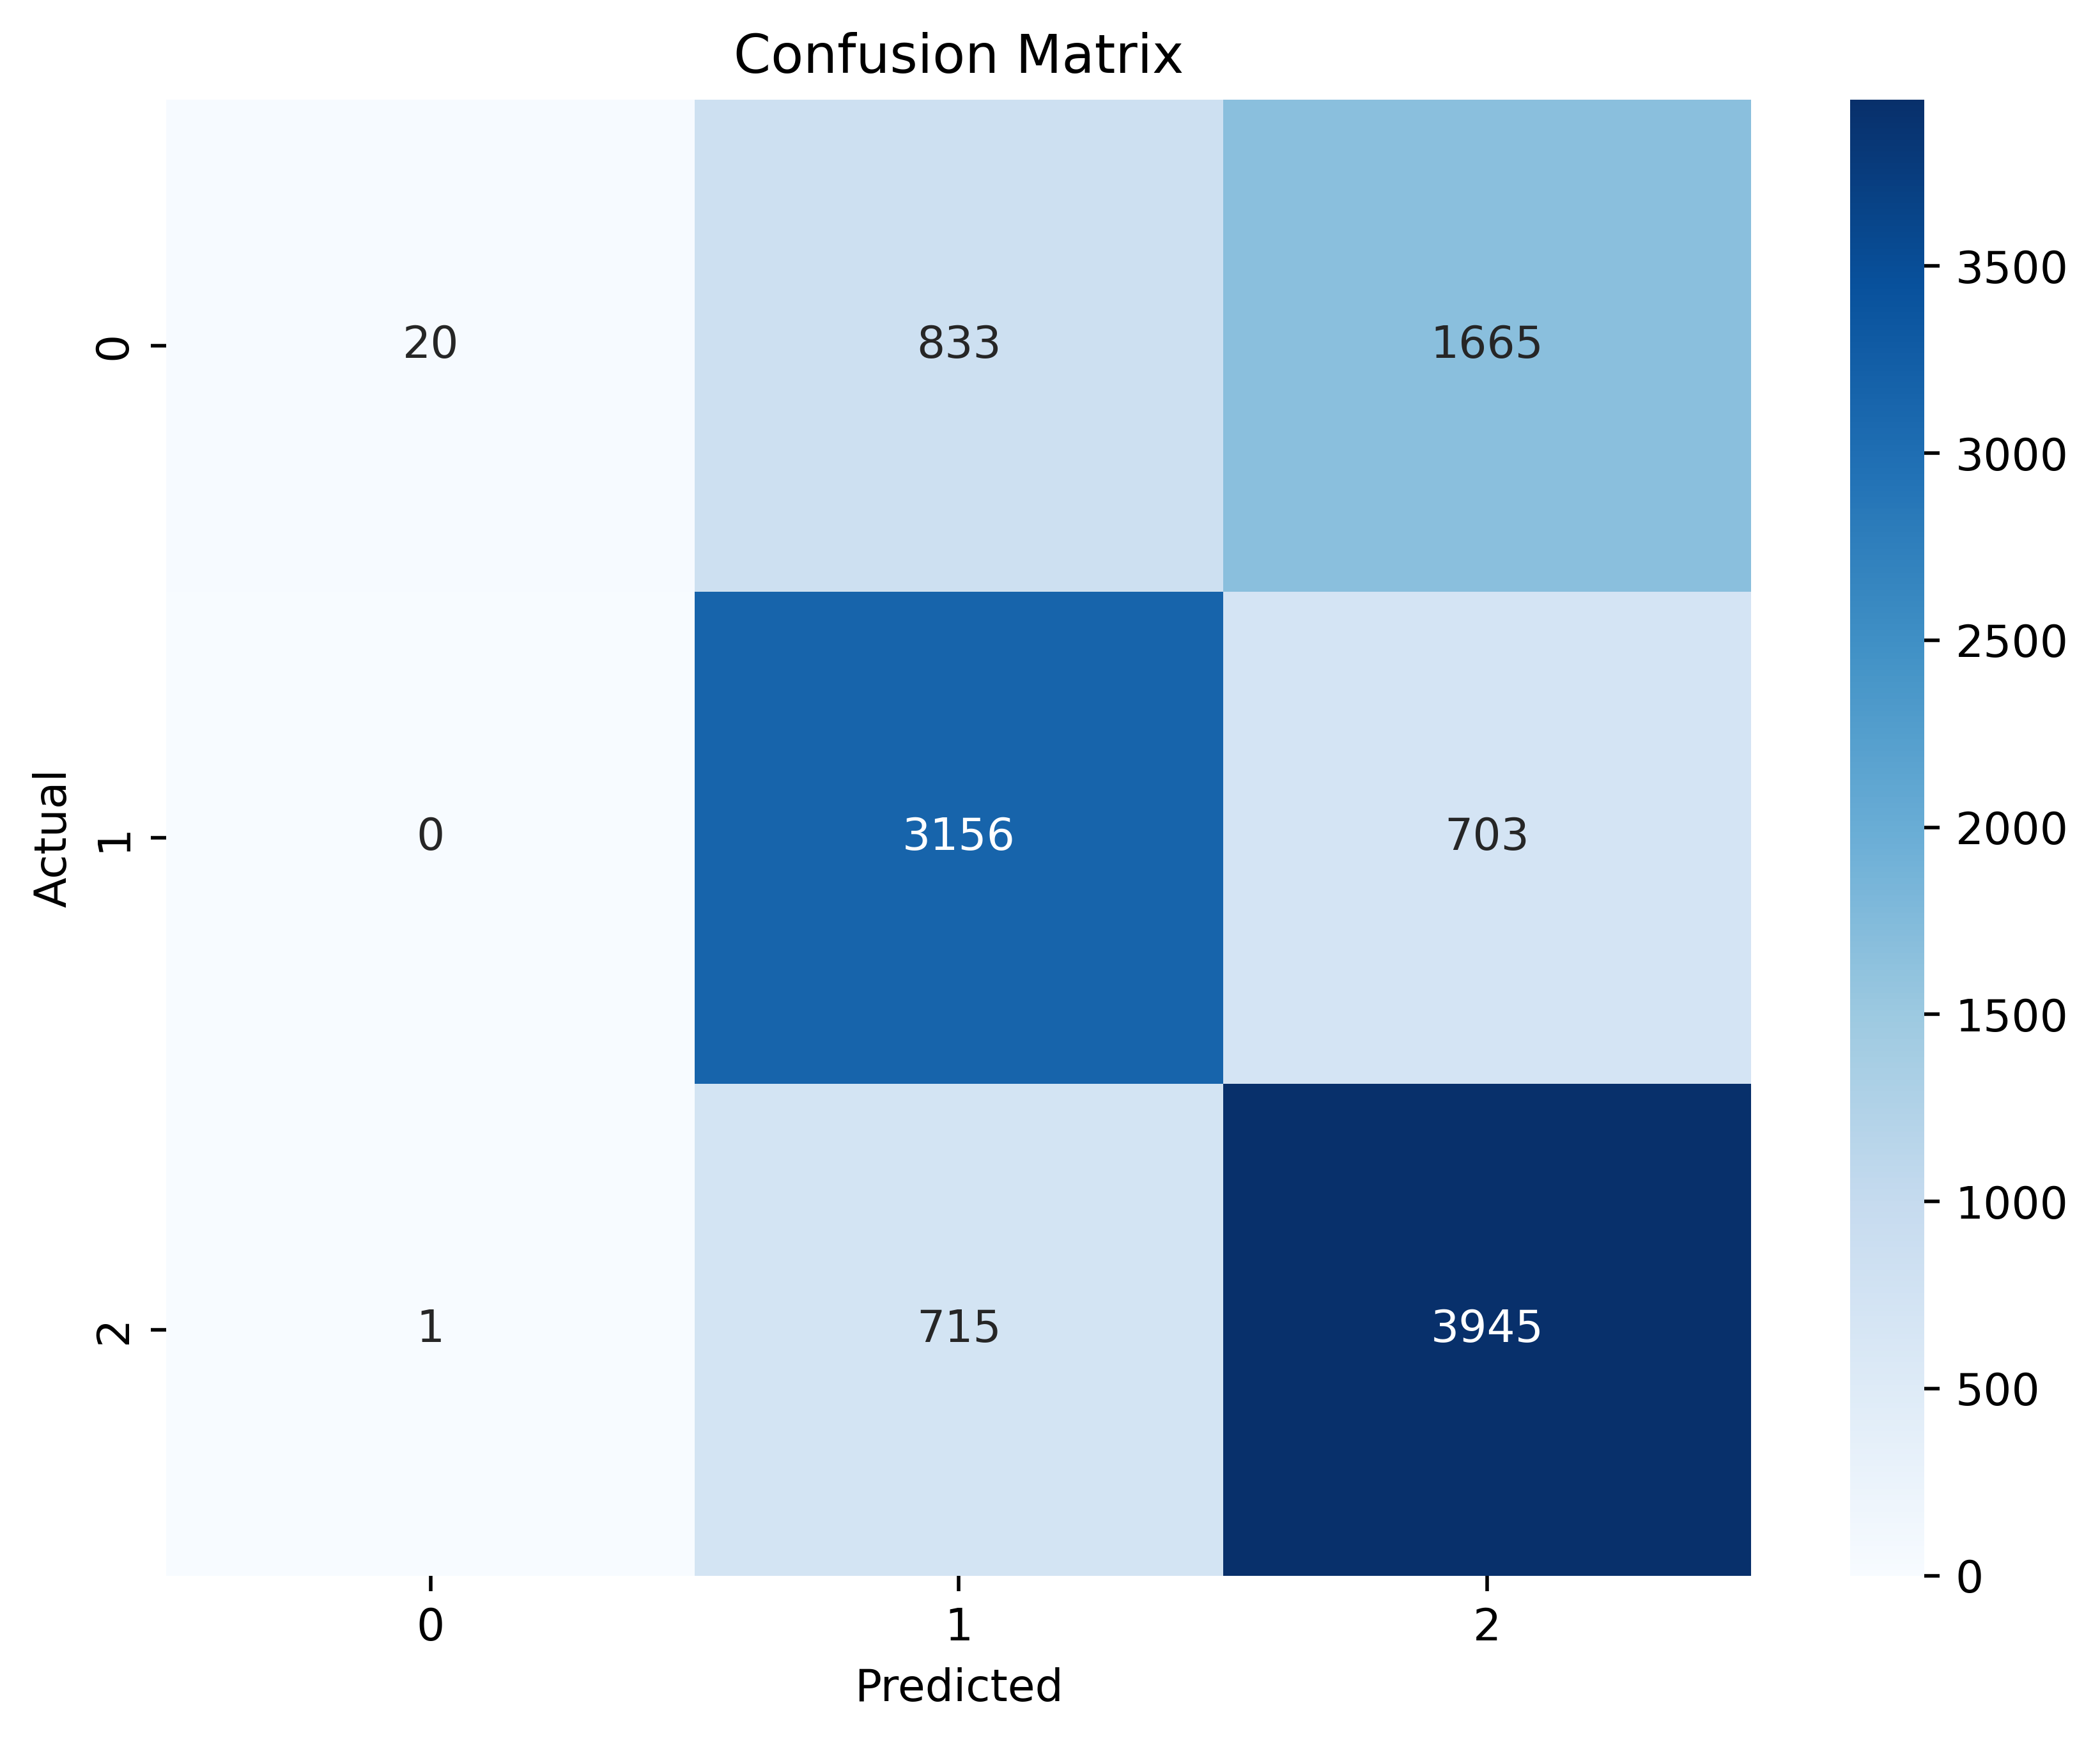

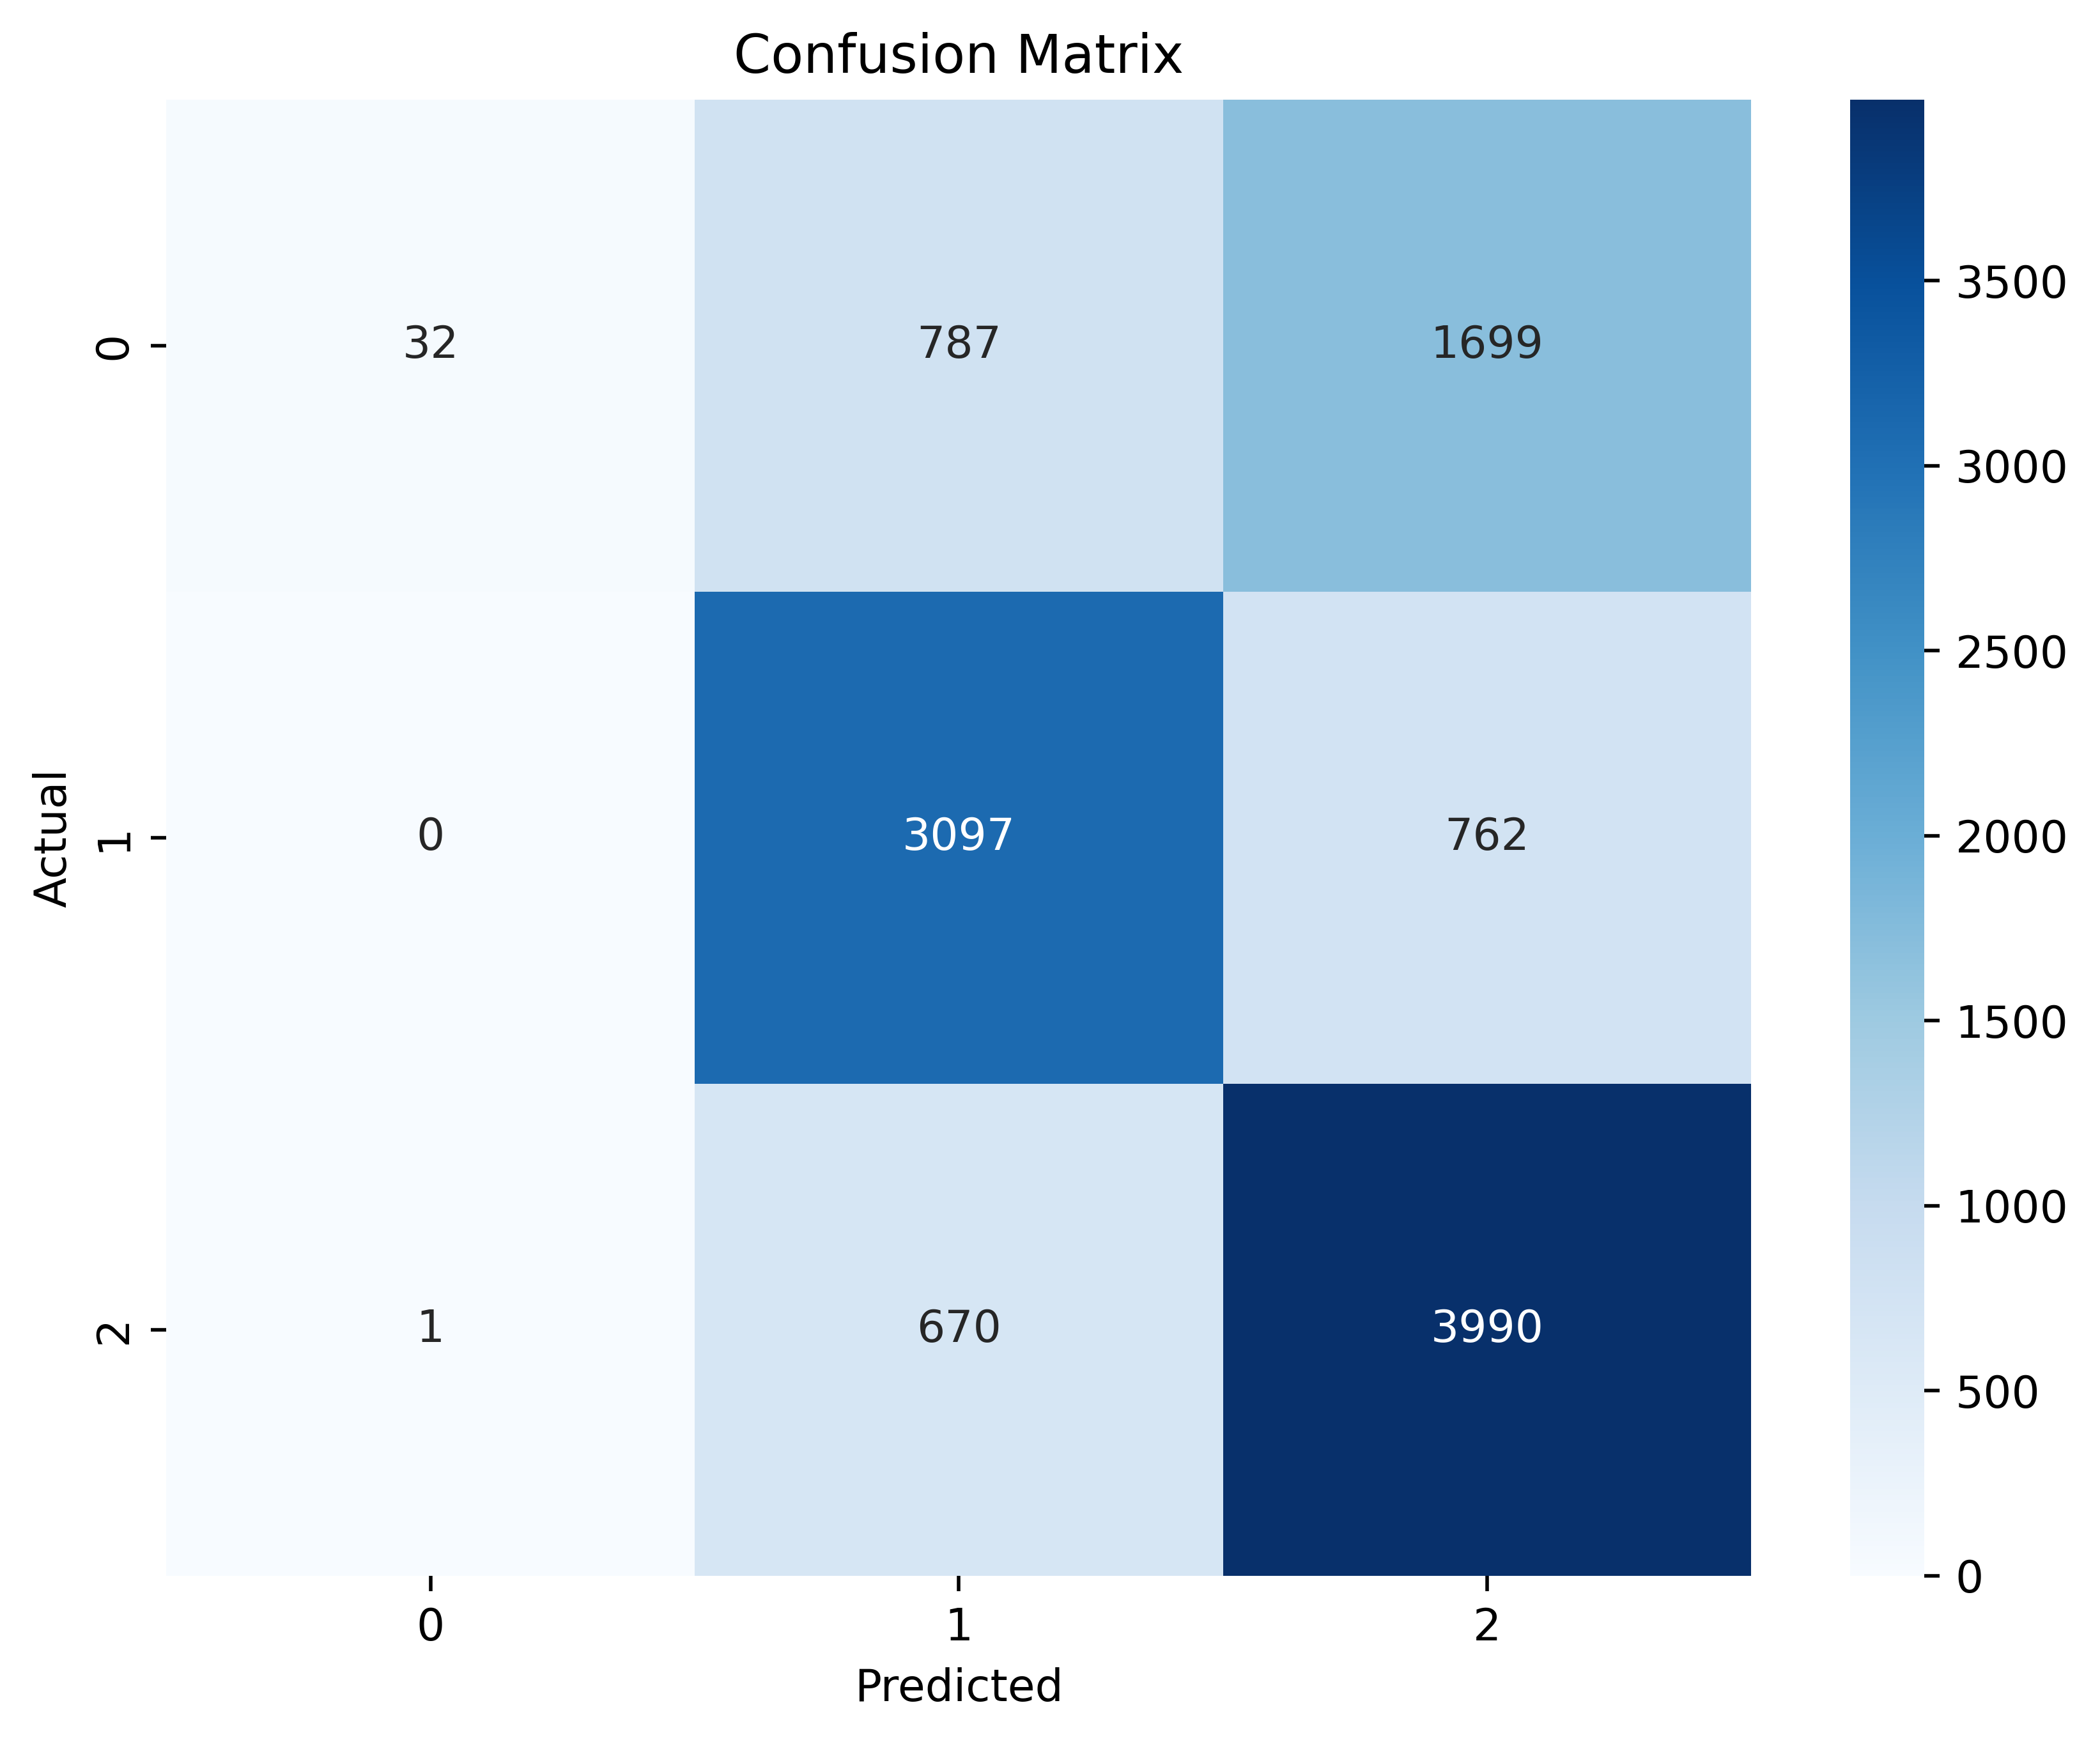

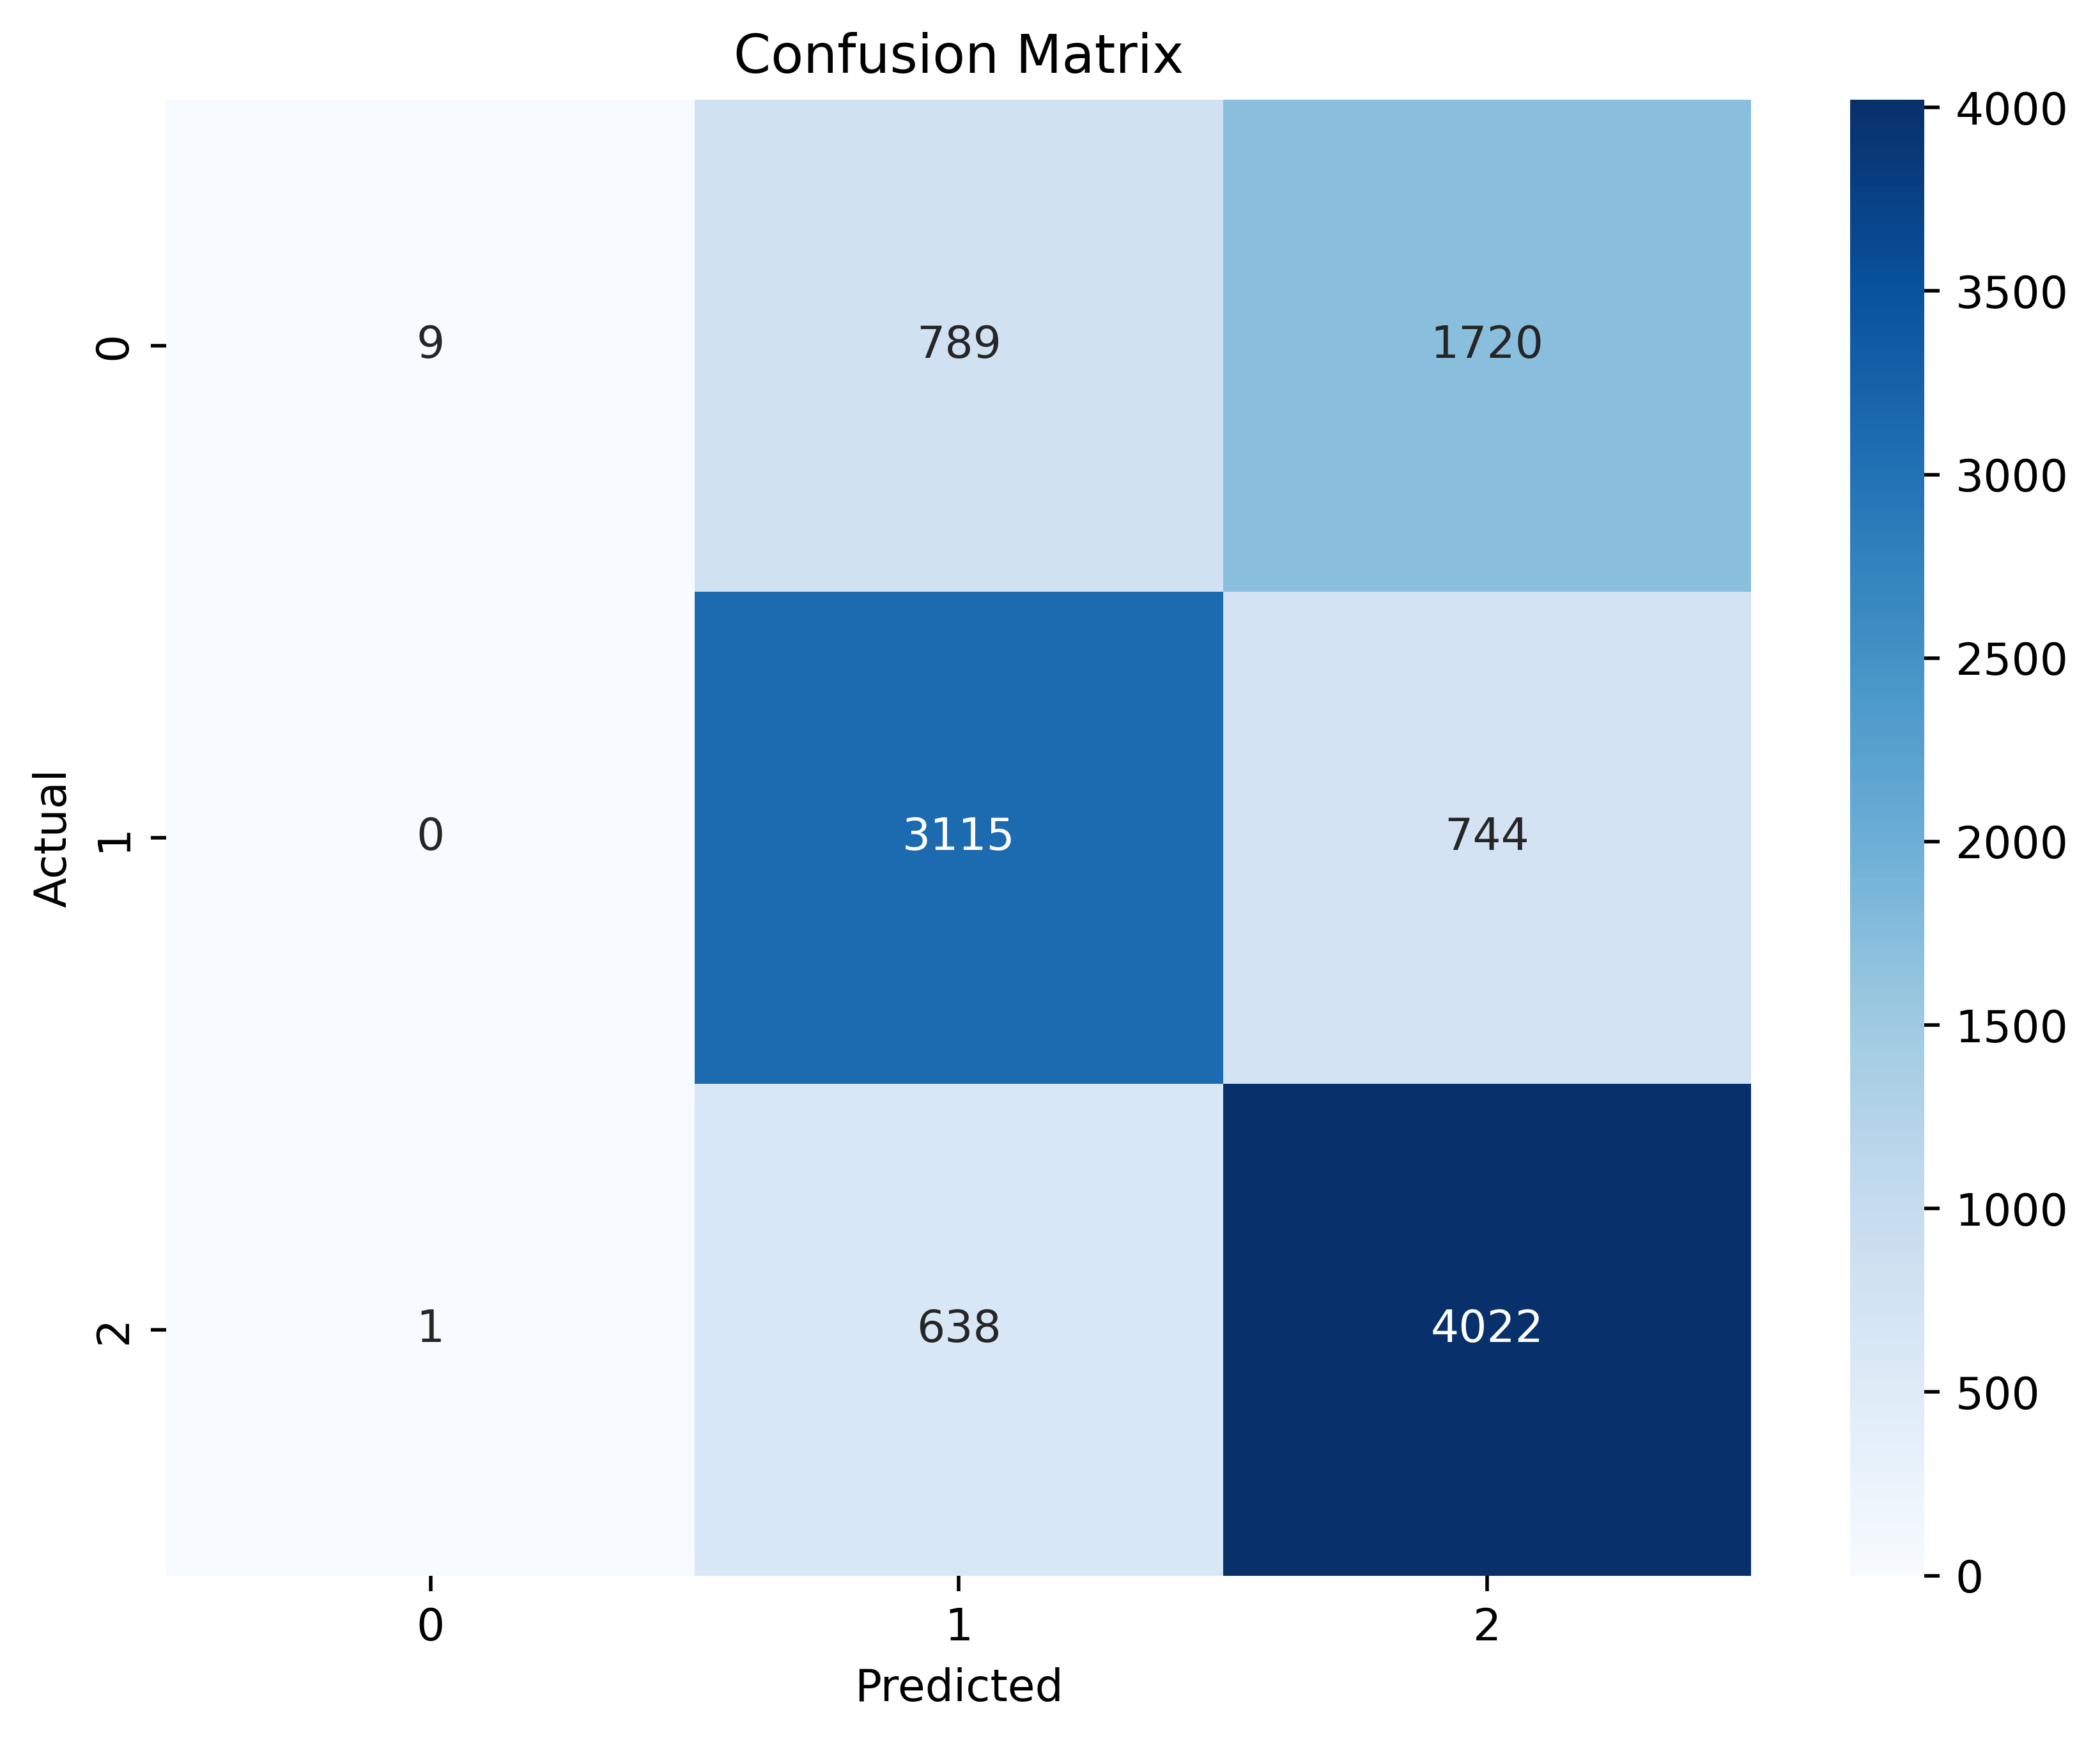

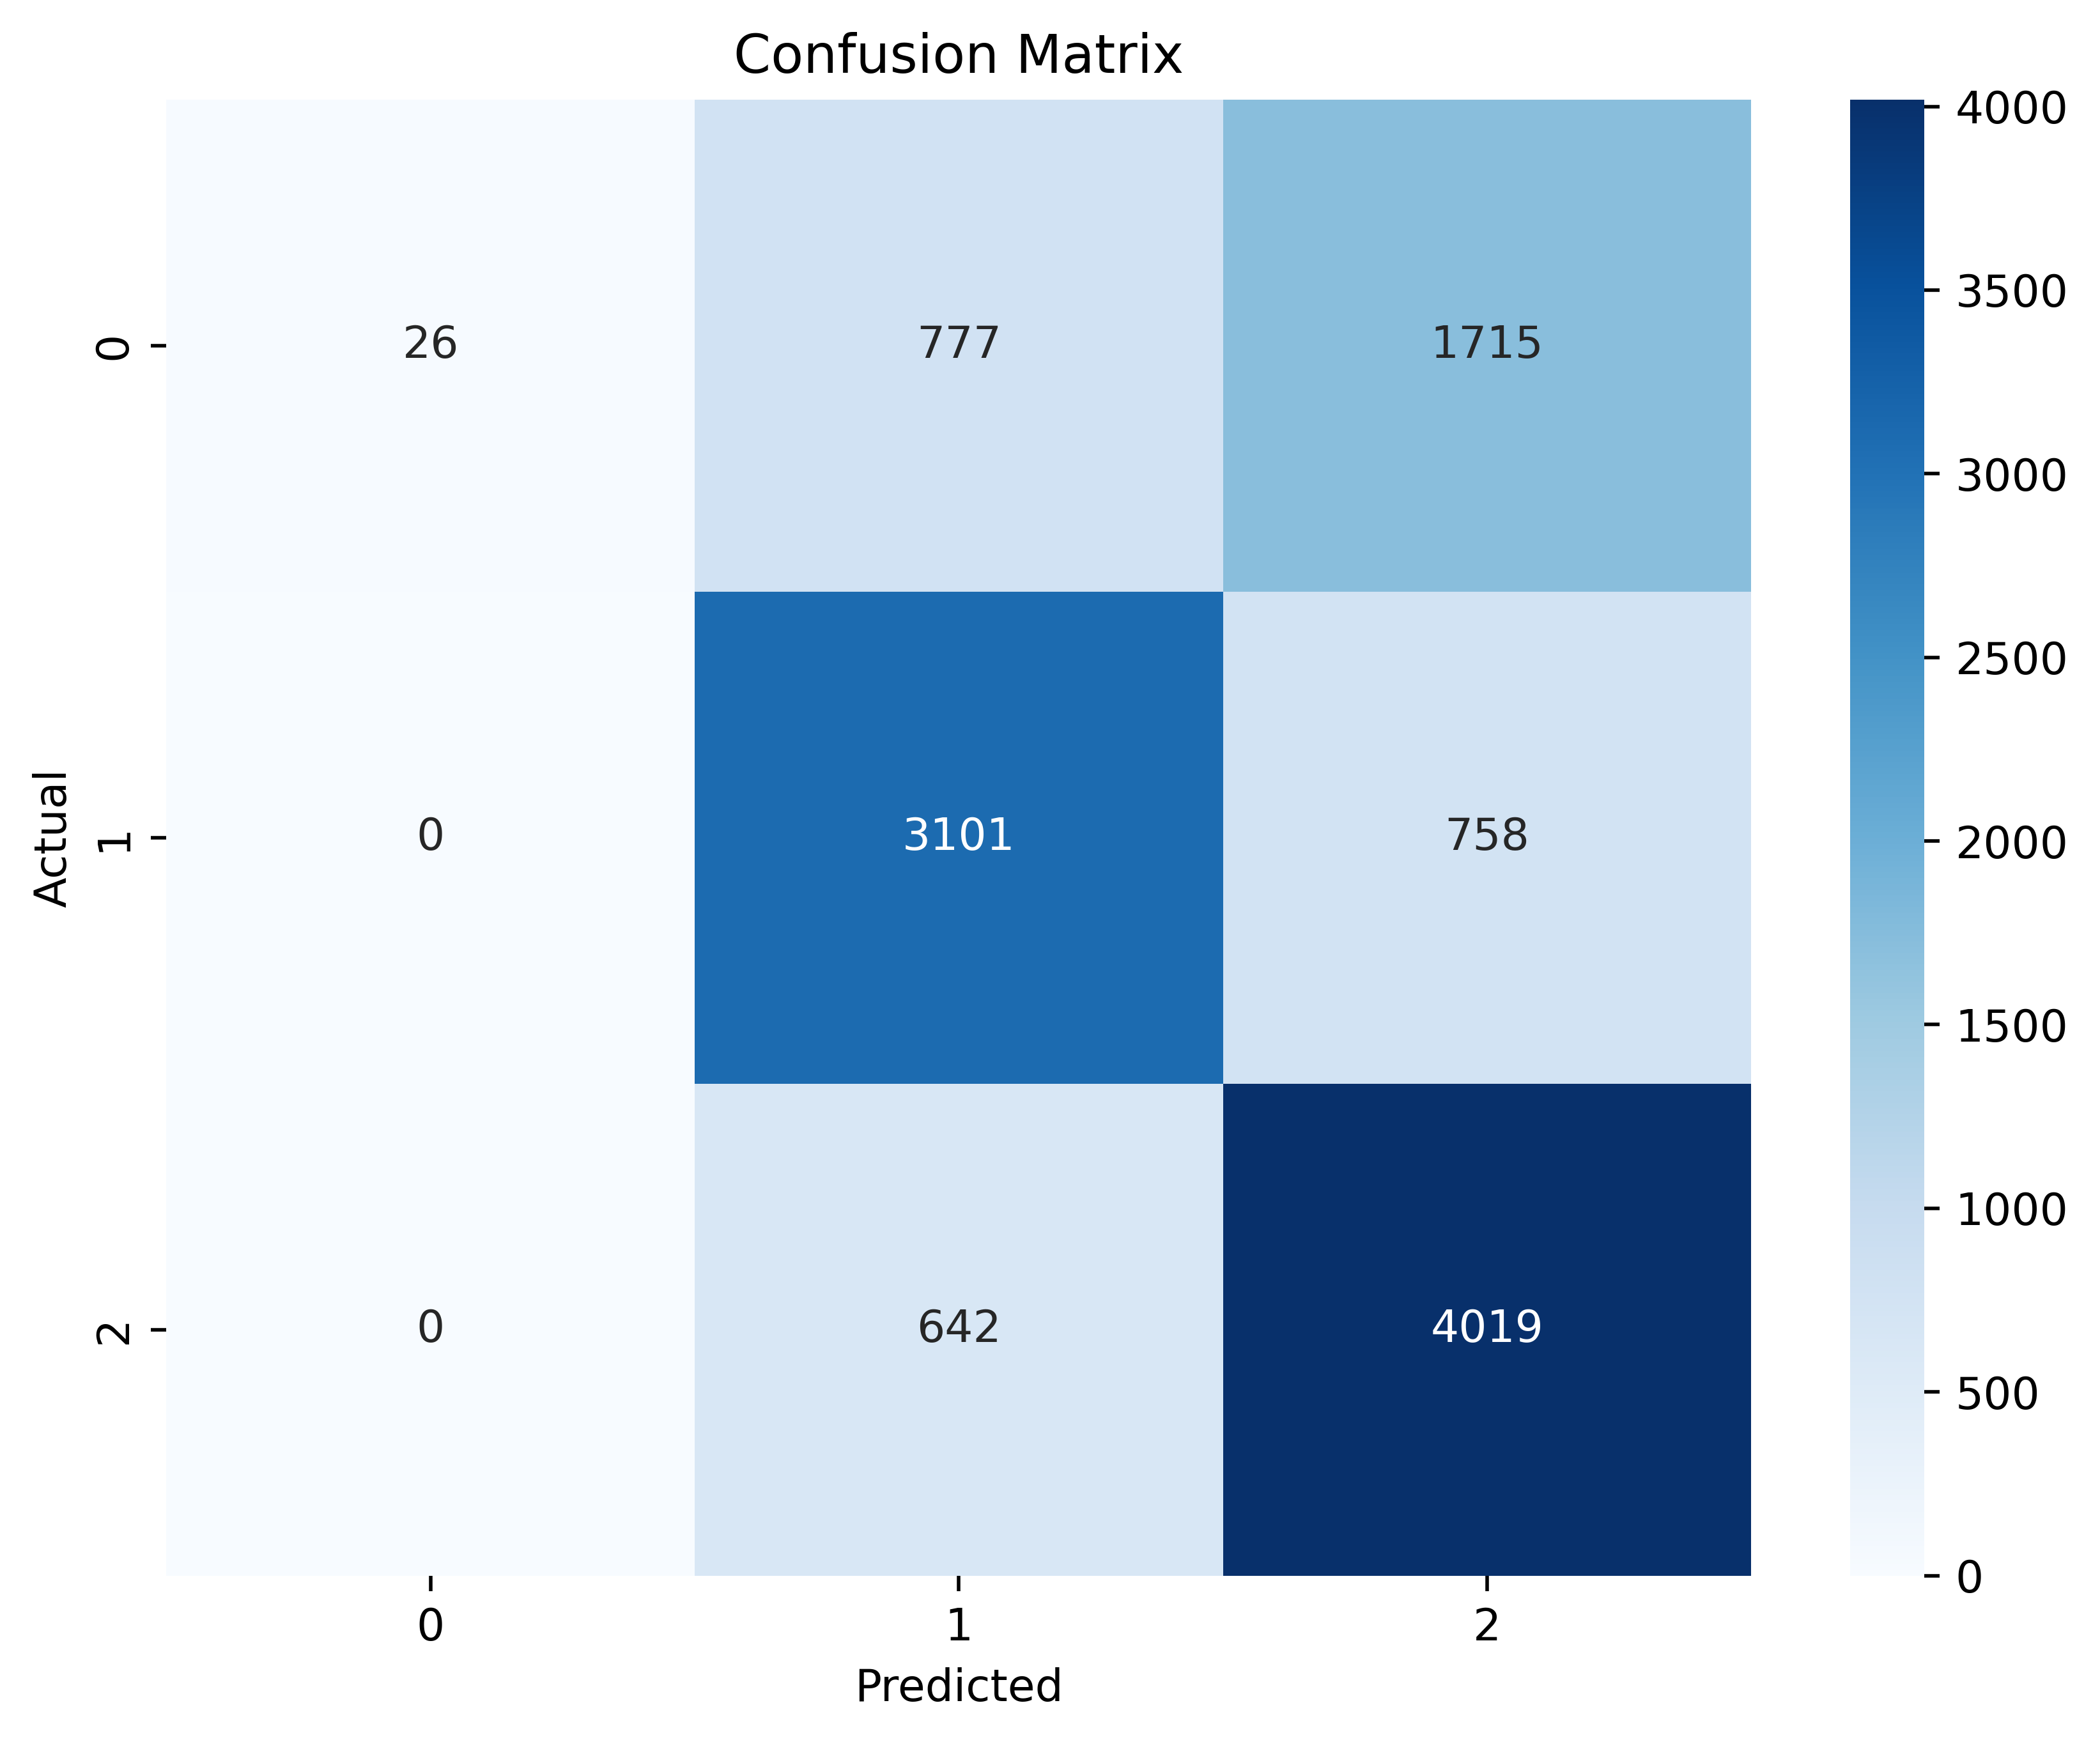

In [46]:
def run_experiment_max_features(max_features):
    ngram_range = (1,3)
    vectorizer = CountVectorizer(ngram_range=ngram_range, max_features=max_features)

    X_train, X_test, y_train, y_test = train_test_split(df['clean_comment'], df['category'],test_size=0.3, random_state=42)

    X_train = vectorizer.fit_transform(X_train)
    X_test  = vectorizer.transform(X_test)

    with mlflow.start_run(nested=True) as run:
        mlflow.set_tag("mlflow.runName", f"BOW_Unigram_max_features_{max_features}")
        mlflow.set_tag("experiment_type", "feauture_engineering")
        mlflow.set_tag("model_type", "RandomForessestCalssifier")

        mlflow.set_tag('description', f"RandomForest with BoW Unigram max_features ={max_features}")

        mlflow.log_param('vectorizer_type', "BoW")
        mlflow.log_param('ngram_range', ngram_range)
        mlflow.log_param('vectorizer_max_features',max_features)

        n_estimators = 200
        max_depth    = 15

        mlflow.log_param('n_estimators',n_estimators)
        mlflow.log_param('max_depth', max_depth)

        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        balance_acc = balanced_accuracy_score(y_test, y_pred)
        mlflow.log_metric('Balanced Accuracy', balance_acc)

        recal_scr = recall_score(y_test, y_pred, average="weighted")
        mlflow.log_metric('Recall Score', recal_scr)

        precision_scr = precision_score(y_test, y_pred, average="weighted")
        mlflow.log_metric('Precision Score', precision_scr)

        f1_scr = f1_score(y_test, y_pred, average="weighted")
        mlflow.log_metric('F1 Score', f1_scr)  # Fixed metric name

        roc_score = roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr', average="weighted")
        mlflow.log_metric('ROC-AUC Score', roc_score)

        classification_rep = classification_report(y_test, y_pred, output_dict=True)

        for label, metrics in classification_rep.items():
            if isinstance(metrics, dict):
                for metric, value in metrics.items():
                    mlflow.log_metric(f"{label}_{metric}", value)
                
        conf_matrix = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6), dpi=500)
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')

        plt.savefig('confusion_matrix.png')
        mlflow.log_artifact("confusion_matrix.png")

        # Fixed model saving - use log_model instead of load_model
        # Fixed f-string formatting in the model name
        mlflow.sklearn.log_model(model, f"random_forest_model_bow_unigram_{max_features}")
        
        # Return metrics to be used outside the function
        return balance_acc, recal_scr, precision_scr, f1_scr, roc_score
    
max_features_values = [x for x in range(1000,11000,1000)]

for max_features  in max_features_values:
    run_experiment_max_features(max_features)
    mlflow.end_run()

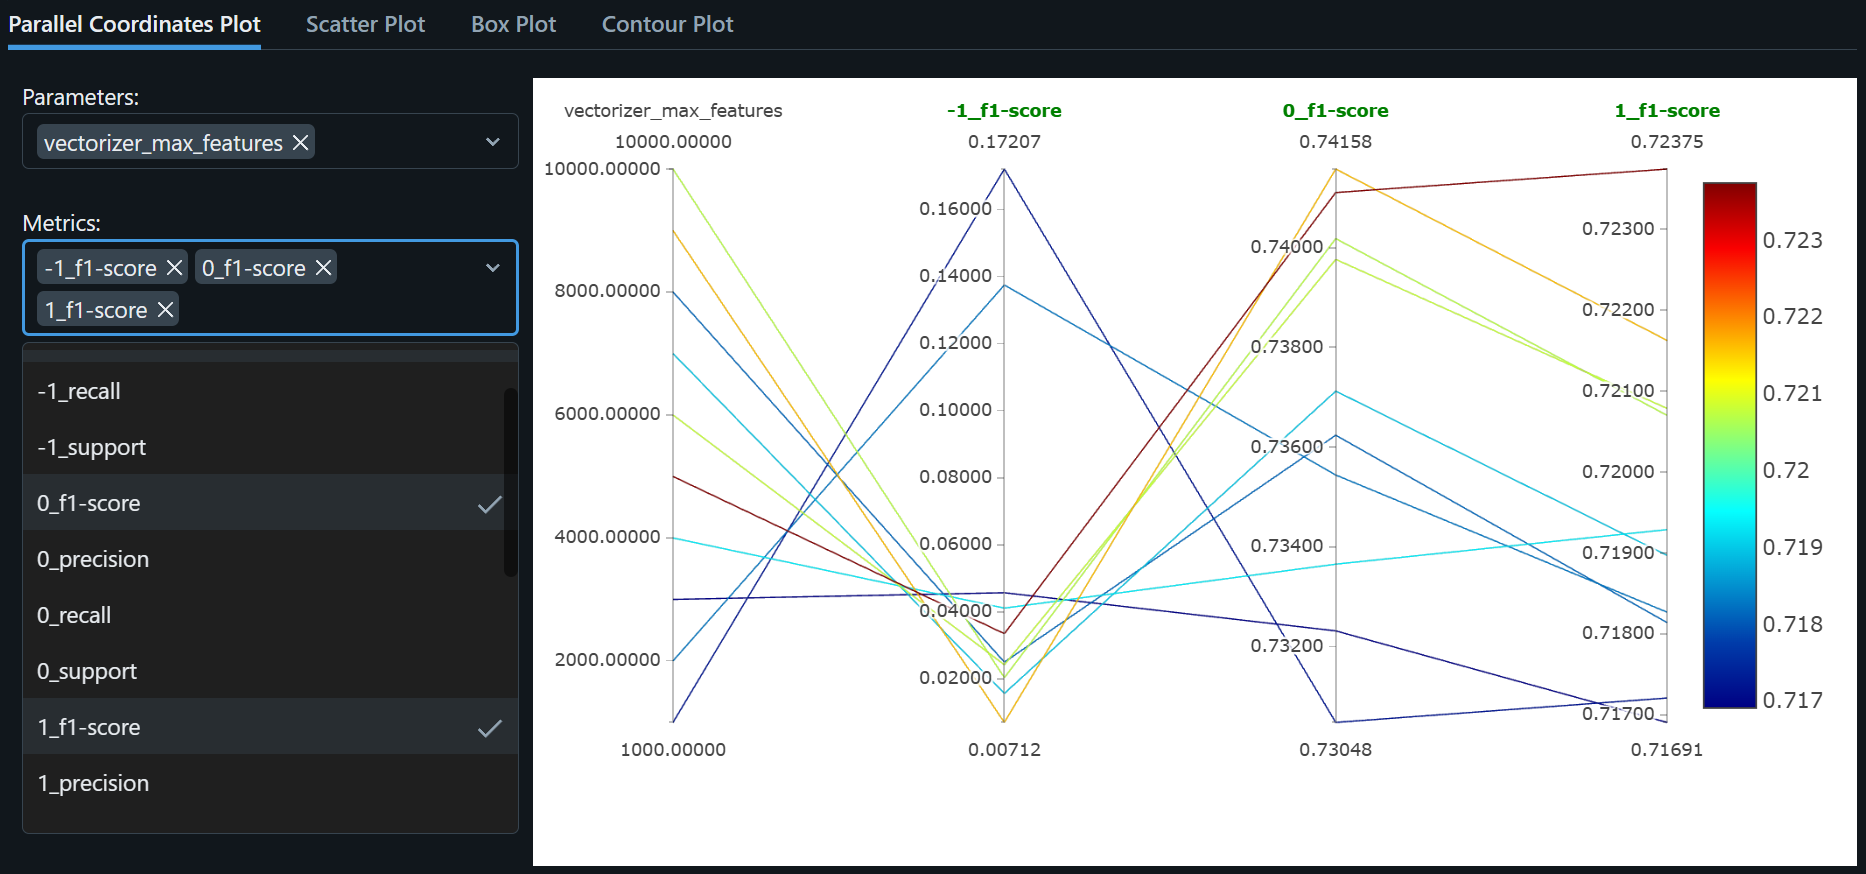

# Handling Imbalance

In [48]:
mlflow.set_experiment('Experiment 4 - Handling Imbalance')

2025/04/22 23:40:59 INFO mlflow.tracking.fluent: Experiment with name 'Experiment 4 - Handling Imbalance' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/147400155326876902', creation_time=1745340059901, experiment_id='147400155326876902', last_update_time=1745340059901, lifecycle_stage='active', name='Experiment 4 - Handling Imbalance', tags={}>

In [50]:
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

In [57]:
def run_imbalance_experiment(imbalance_method):
    ngram_range = (1,1)
    max_features = 1000

    X_train, X_test, y_train, y_test = train_test_split(df['clean_comment'],df['category'], test_size=0.3, random_state=42)

    vectorizer = CountVectorizer(ngram_range=ngram_range, max_features=max_features)
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec  = vectorizer.transform(X_test)

    if imbalance_method=='class_weights':
        class_weight = 'balanced'
    else:
        class_weight=None

        if imbalance_method=='oversampling':
            smote = SMOTE(random_state=42)
            X_train_vec, y_train = smote.fit_resample(X_train_vec, y_train)
        elif imbalance_method=='adasyn':
            adasyn = ADASYN(random_state=42)
            X_train_vec, y_train = adasyn.fit_resample(X_train_vec, y_train)
        elif imbalance_method=='undersampling':
            rus  = RandomUnderSampler(random_state=42)
            X_train_vec, y_train = rus.fit_resample(X_train_vec, y_train)
        elif imbalance_method=='smote_enn':
            smote_enn  = SMOTEENN(random_state=42)
            X_train_vec, y_train = smote_enn.fit_resample(X_train_vec, y_train)
    
    with mlflow.start_run(nested=True) as run:
        mlflow.set_tag('mlflow.runName', f"Imbalance_{imbalance_method}_RandomForest_BoW_Unigram")
        mlflow.set_tag('experiment_type','imblanace_handling')
        mlflow.set_tag('model_type','RandomForesetClassifier')

        mlflow.set_tag('description', f"RandomForest with BoW Unigram, Imbalance Handiling method={imbalance_method}")
        
        mlflow.log_param('vectorizer_type','BoW')
        mlflow.log_param('ngram_range',ngram_range)
        mlflow.log_param('vectorizer_max_features',max_features)

        n_estimators=200
        max_depth=15


        mlflow.log_param('n_estimator',n_estimators)
        mlflow.log_param('max_depth',max_depth)
        mlflow.log_param('imbalance_method',imbalance_method)

        model = RandomForestClassifier(random_state=42, n_estimators=n_estimators, max_depth=max_depth,class_weight=class_weight)
        model.fit(X_train_vec, y_train)

        y_pred=model.predict(X_test_vec)

        balance_acc = balanced_accuracy_score(y_test, y_pred)
        mlflow.log_metric('Balanced Accuracy', balance_acc)

        recal_scr = recall_score(y_test, y_pred, average="weighted")
        mlflow.log_metric('Recall Score', recal_scr)

        precision_scr = precision_score(y_test, y_pred, average="weighted")
        mlflow.log_metric('Precision Score', precision_scr)

        f1_scr = f1_score(y_test, y_pred, average="weighted")
        mlflow.log_metric('F1 Score', f1_scr)  # Fixed metric name

        # roc_score = roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr', average="weighted")
        # mlflow.log_metric('ROC-AUC Score', roc_score)

        classification_rep = classification_report(y_test, y_pred, output_dict=True)

        for label, metrics in classification_rep.items():
            if isinstance(metrics, dict):
                for metric, value in metrics.items():
                    mlflow.log_metric(f"{label}_{metric}", value)
                
        conf_matrix = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6), dpi=500)
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')

        plt.savefig('confusion_matrix.png')
        mlflow.log_artifact("confusion_matrix.png")

        # Fixed model saving - use log_model instead of load_model
        # Fixed f-string formatting in the model name
        mlflow.sklearn.log_model(model, f"radom_forest_model_bow_unigram_imbalance_{imbalance_method}")
        
        # Return metrics to be used outside the function
        return balance_acc, recal_scr, precision_scr, f1_scr, roc_score

2025/04/22 23:56:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Imbalance_class_weight_RandomForest_BoW_Unigram at: http://localhost:8080/#/experiments/147400155326876902/runs/ad6910402a4445b48836ddfb54fb07c0
🧪 View experiment at: http://localhost:8080/#/experiments/147400155326876902


2025/04/22 23:56:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Imbalance_oversampling_RandomForest_BoW_Unigram at: http://localhost:8080/#/experiments/147400155326876902/runs/fd3063dfc79342faa14aa5ae9196884f
🧪 View experiment at: http://localhost:8080/#/experiments/147400155326876902


2025/04/22 23:57:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Imbalance_adasyn_RandomForest_BoW_Unigram at: http://localhost:8080/#/experiments/147400155326876902/runs/8fd5f15333a34f5a88750bd372bc3de8
🧪 View experiment at: http://localhost:8080/#/experiments/147400155326876902


2025/04/22 23:57:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Imbalance_undersampling_RandomForest_BoW_Unigram at: http://localhost:8080/#/experiments/147400155326876902/runs/ab6c797ec6a84ce2800b062375f9bbb8
🧪 View experiment at: http://localhost:8080/#/experiments/147400155326876902


2025/04/22 23:57:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Imbalance_smote_enn_RandomForest_BoW_Unigram at: http://localhost:8080/#/experiments/147400155326876902/runs/8999babfde3e4c169f50a4d88cd75d04
🧪 View experiment at: http://localhost:8080/#/experiments/147400155326876902


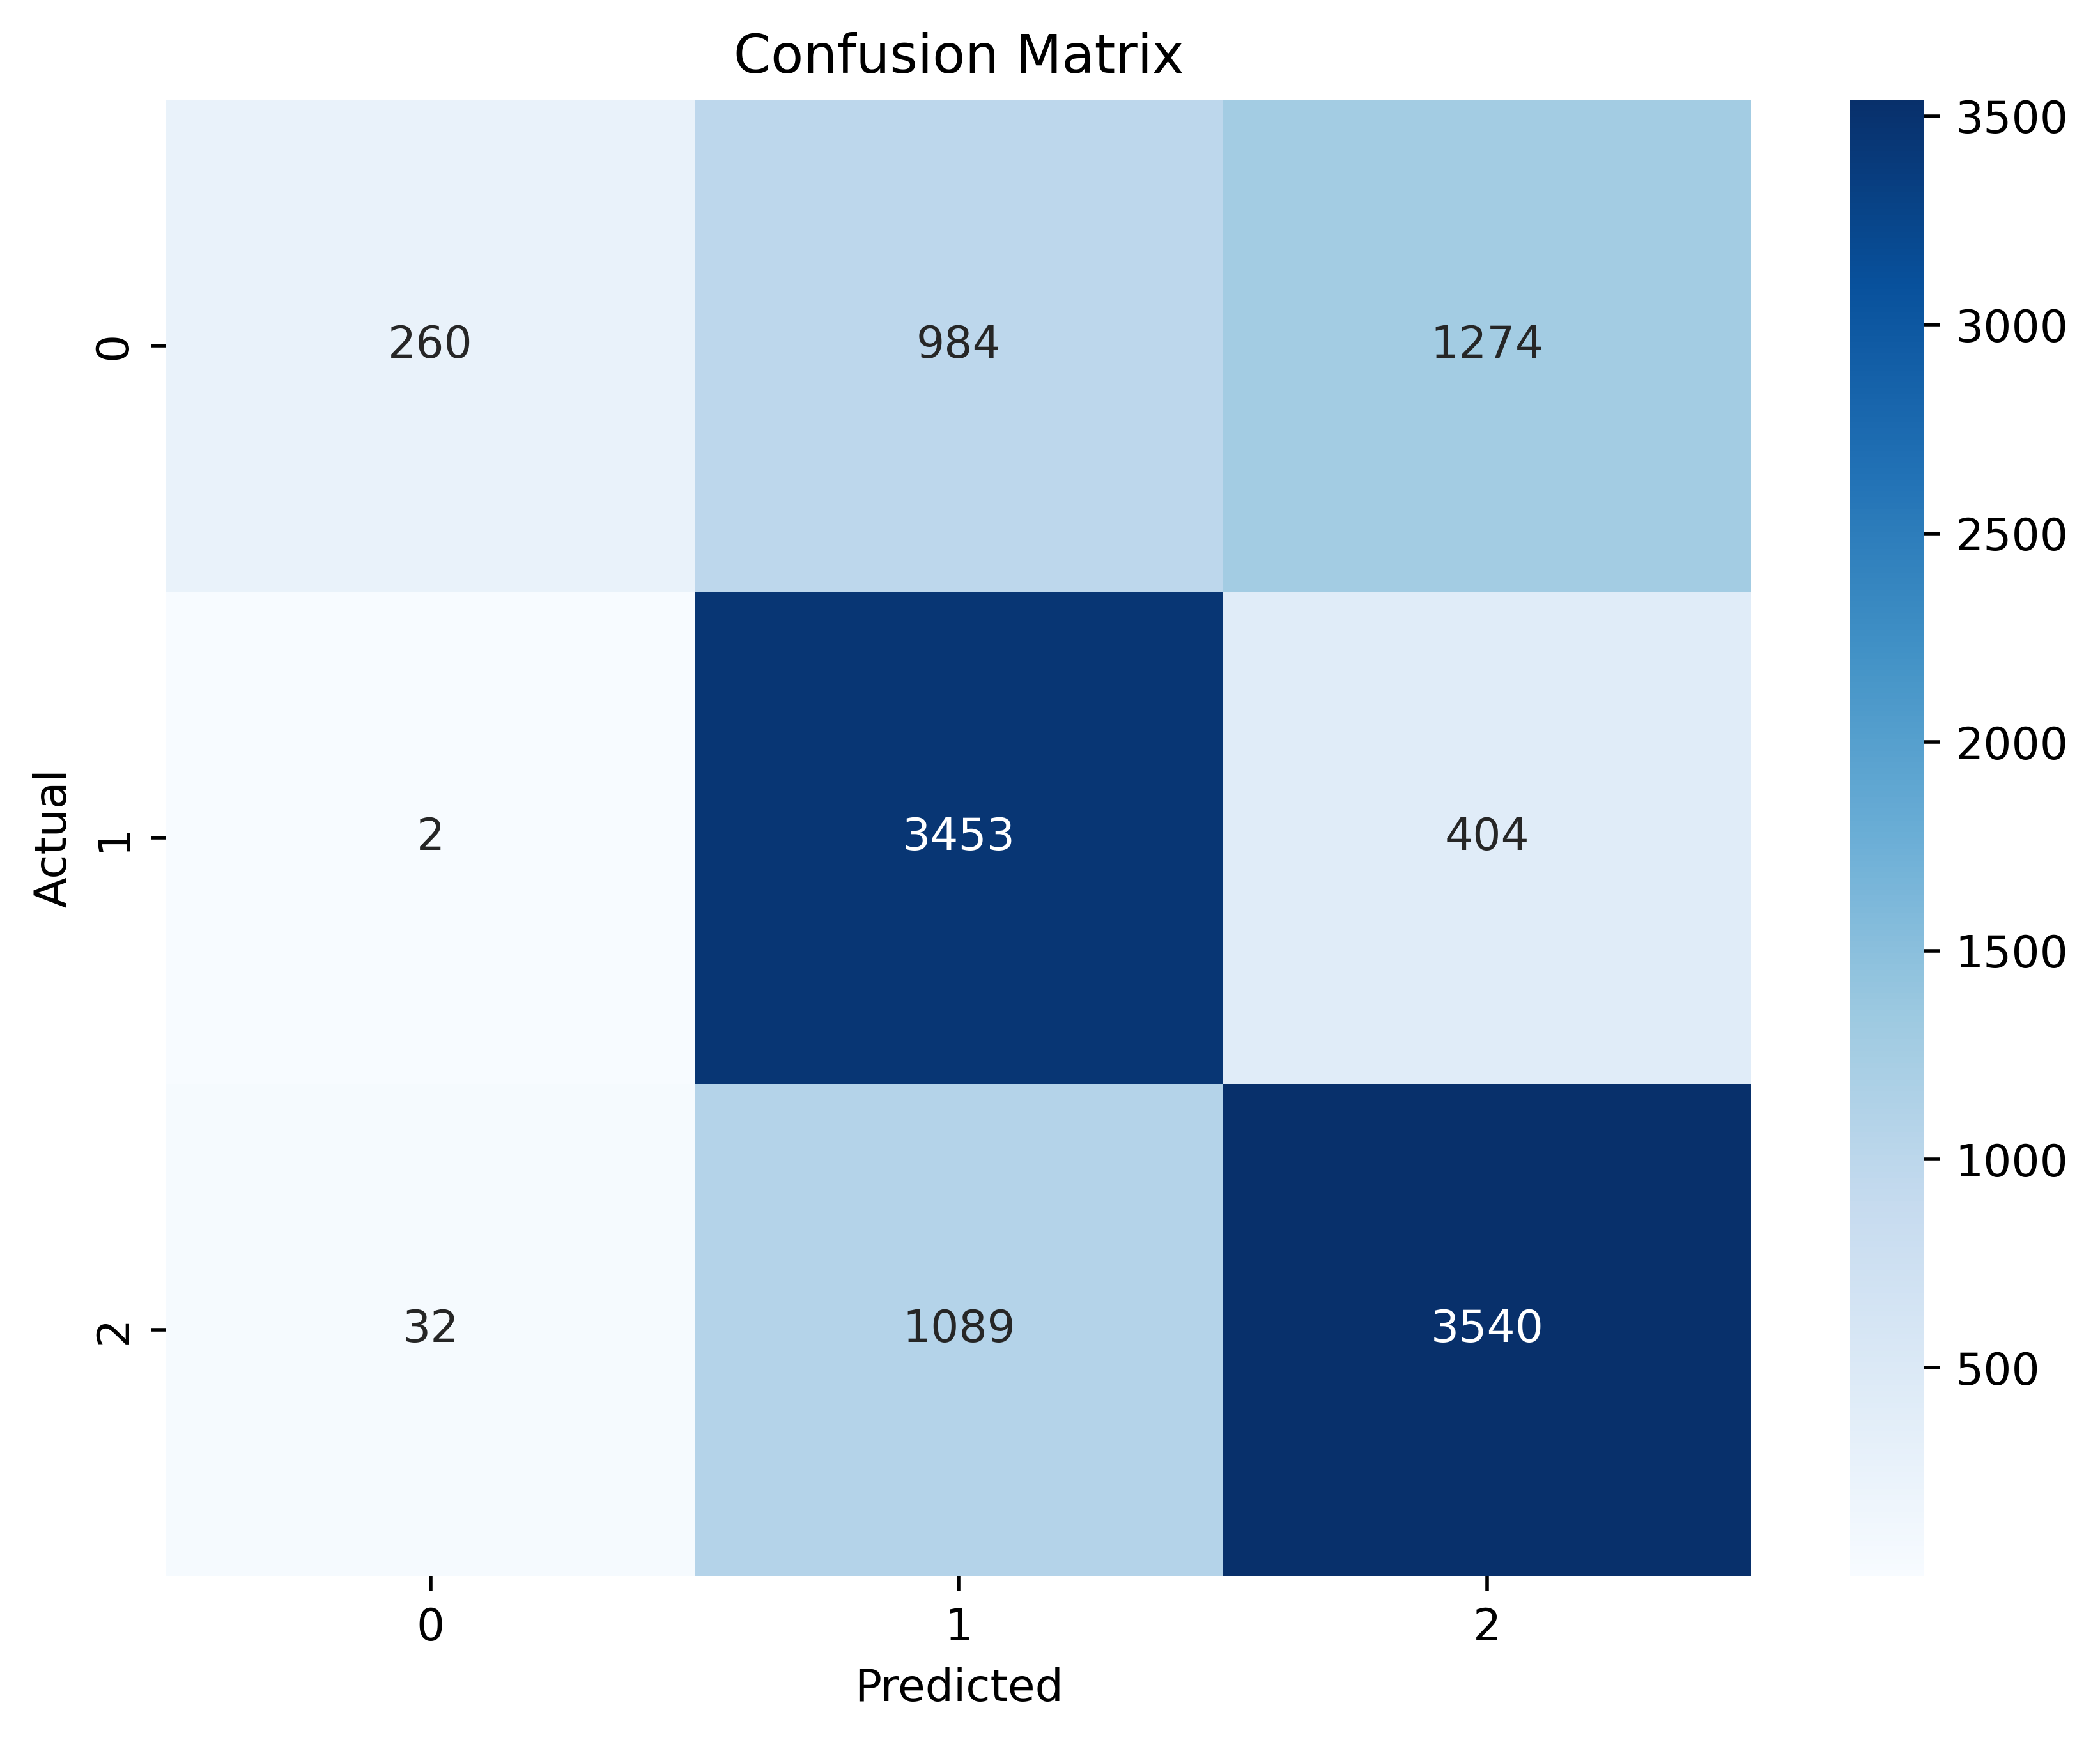

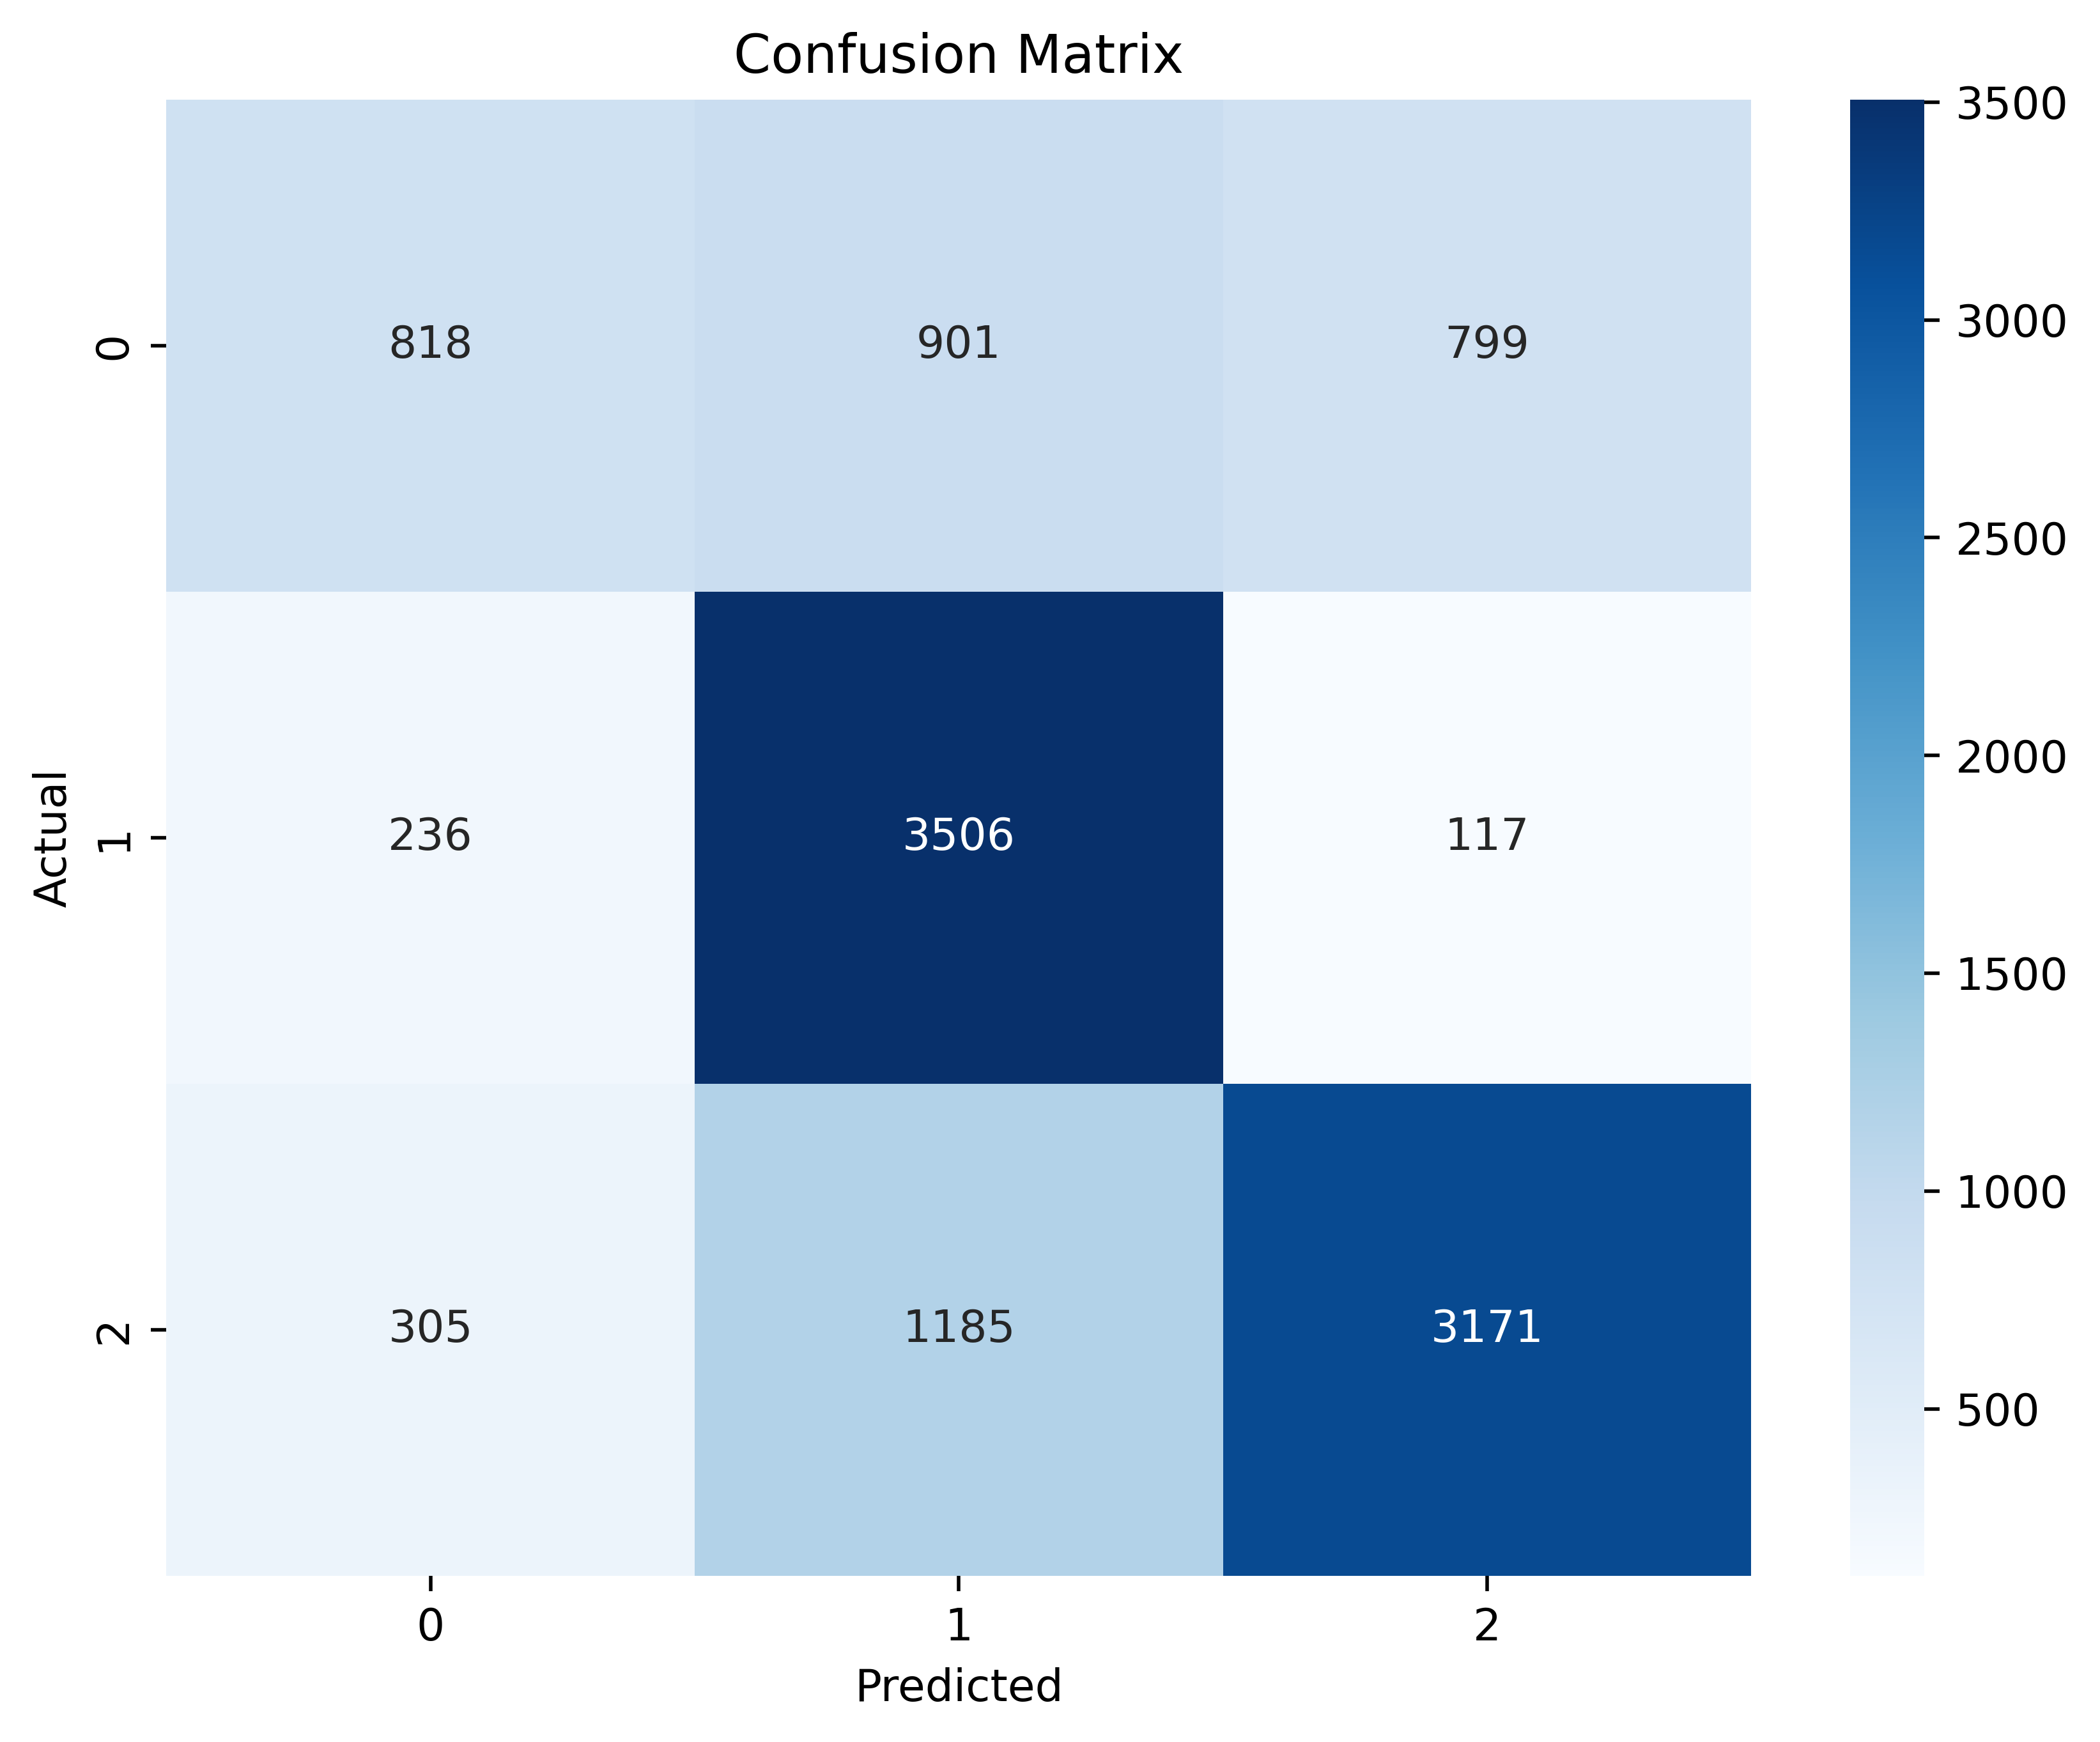

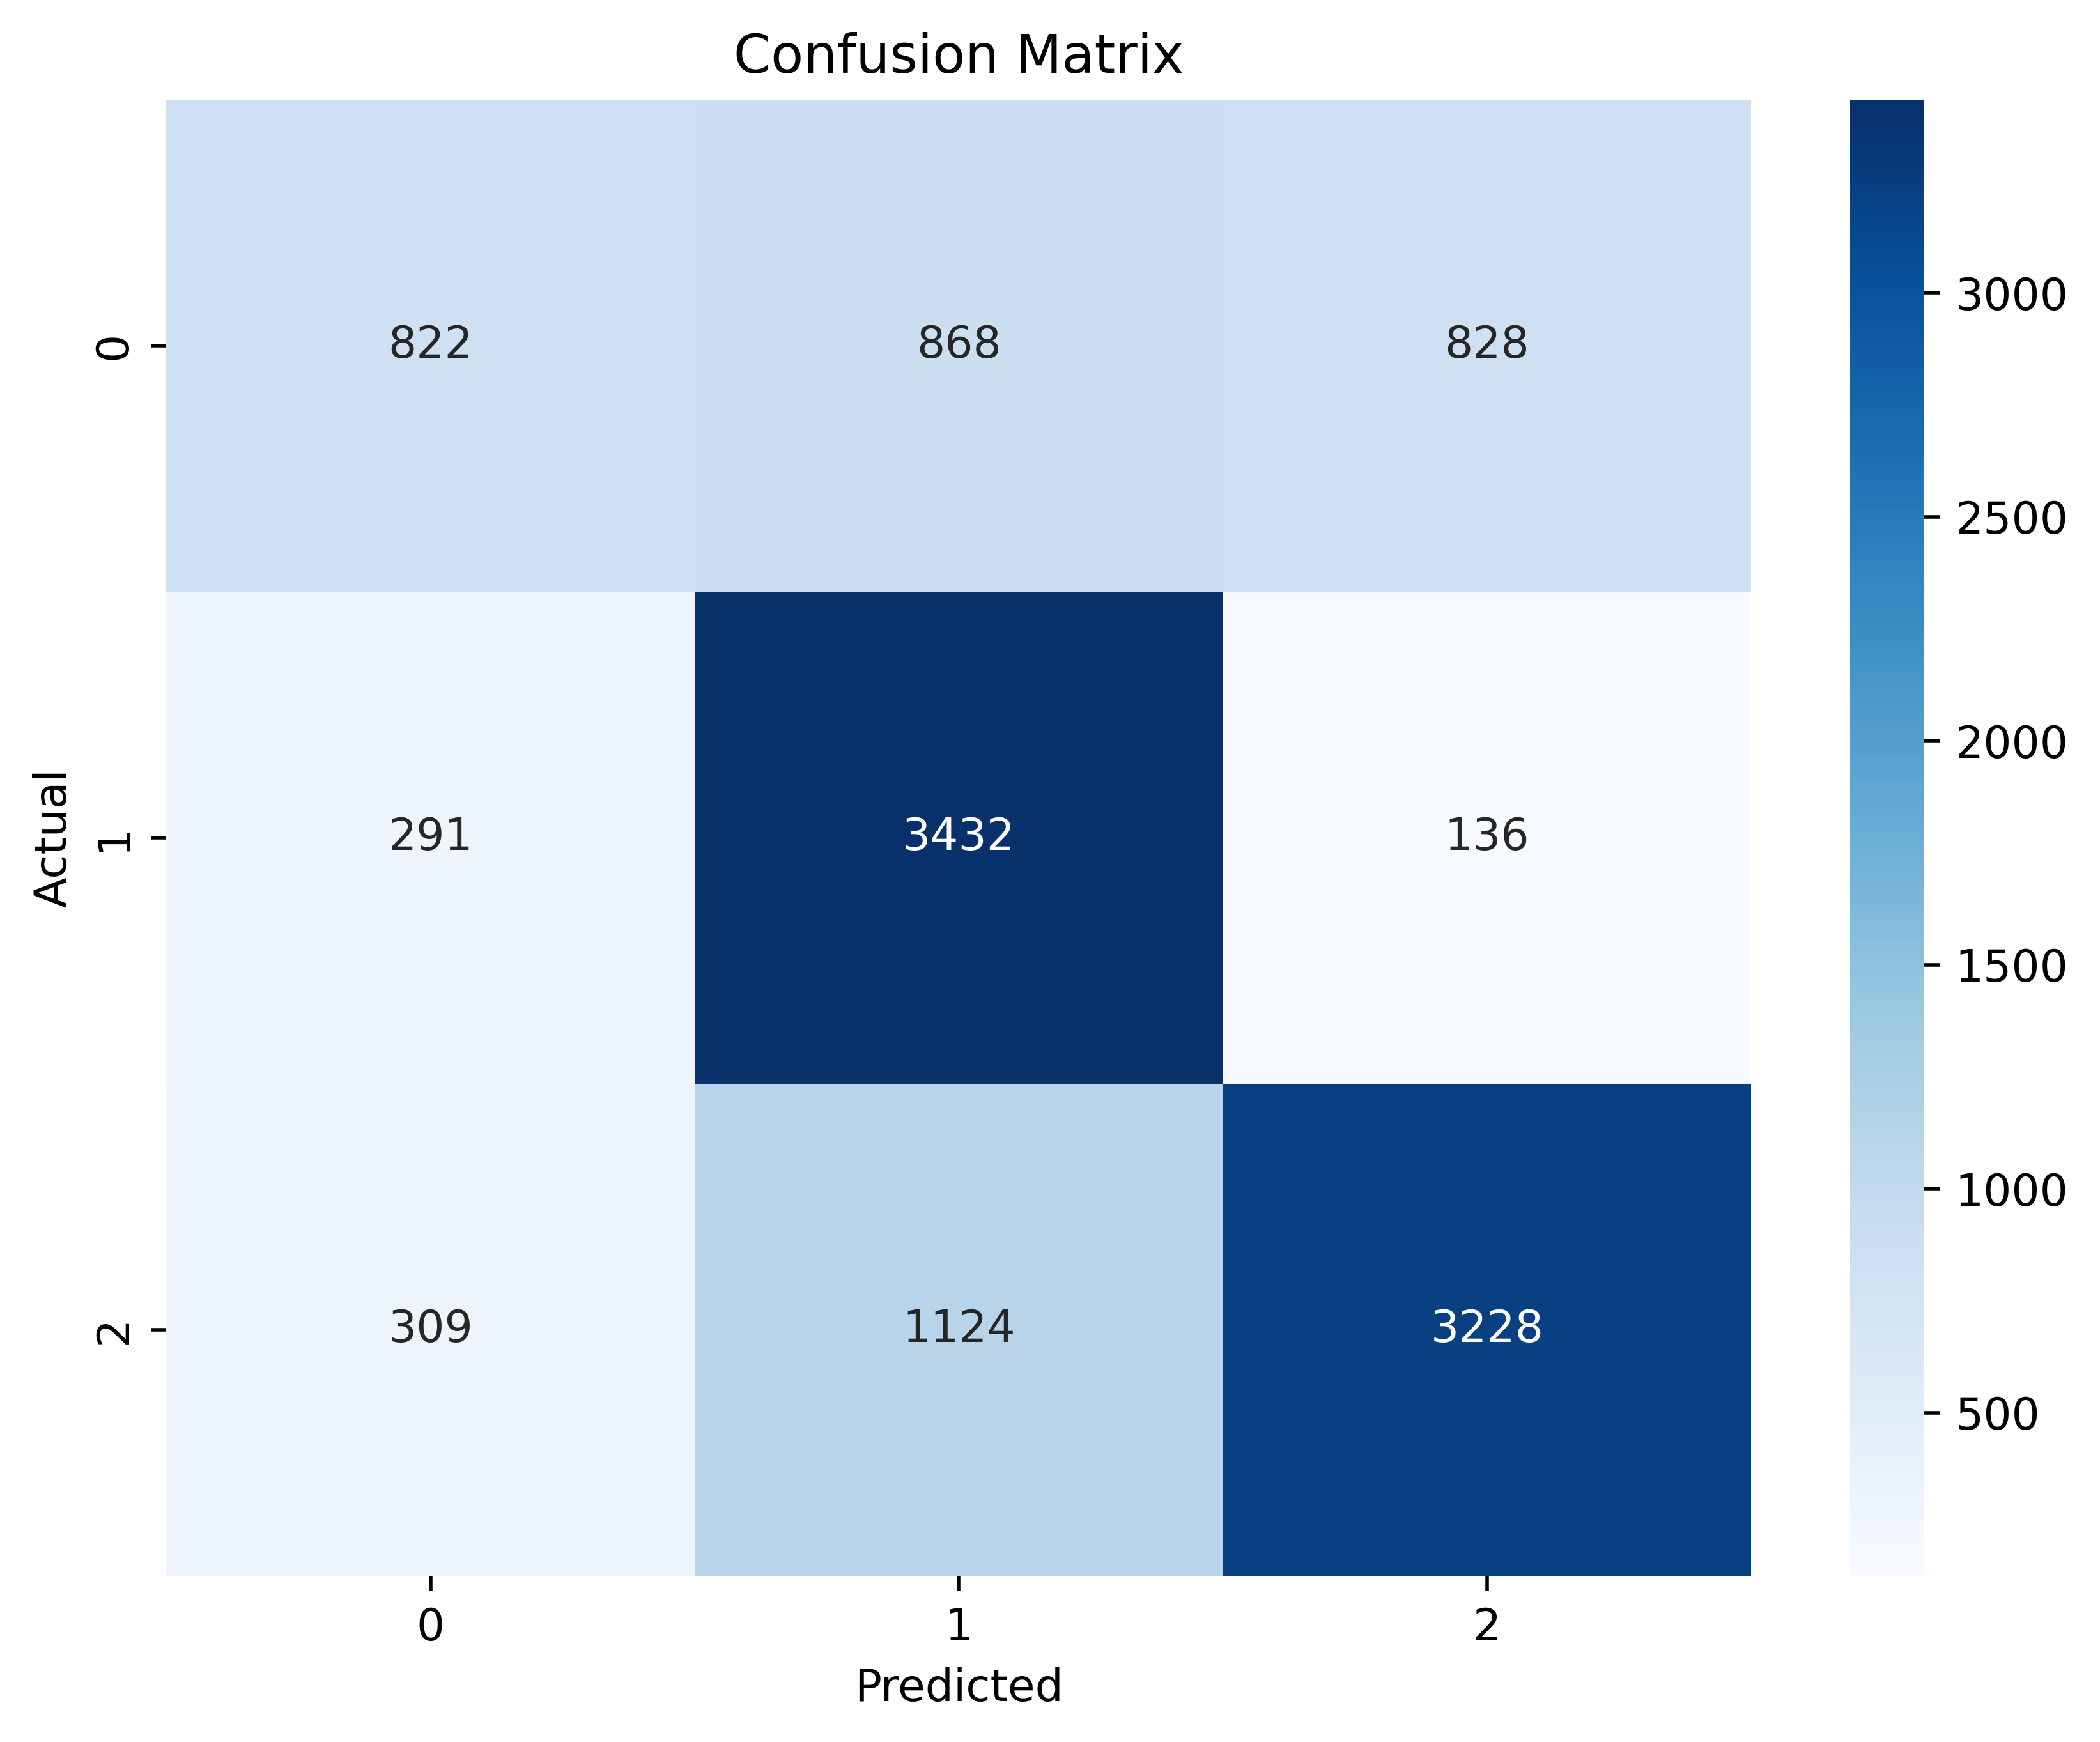

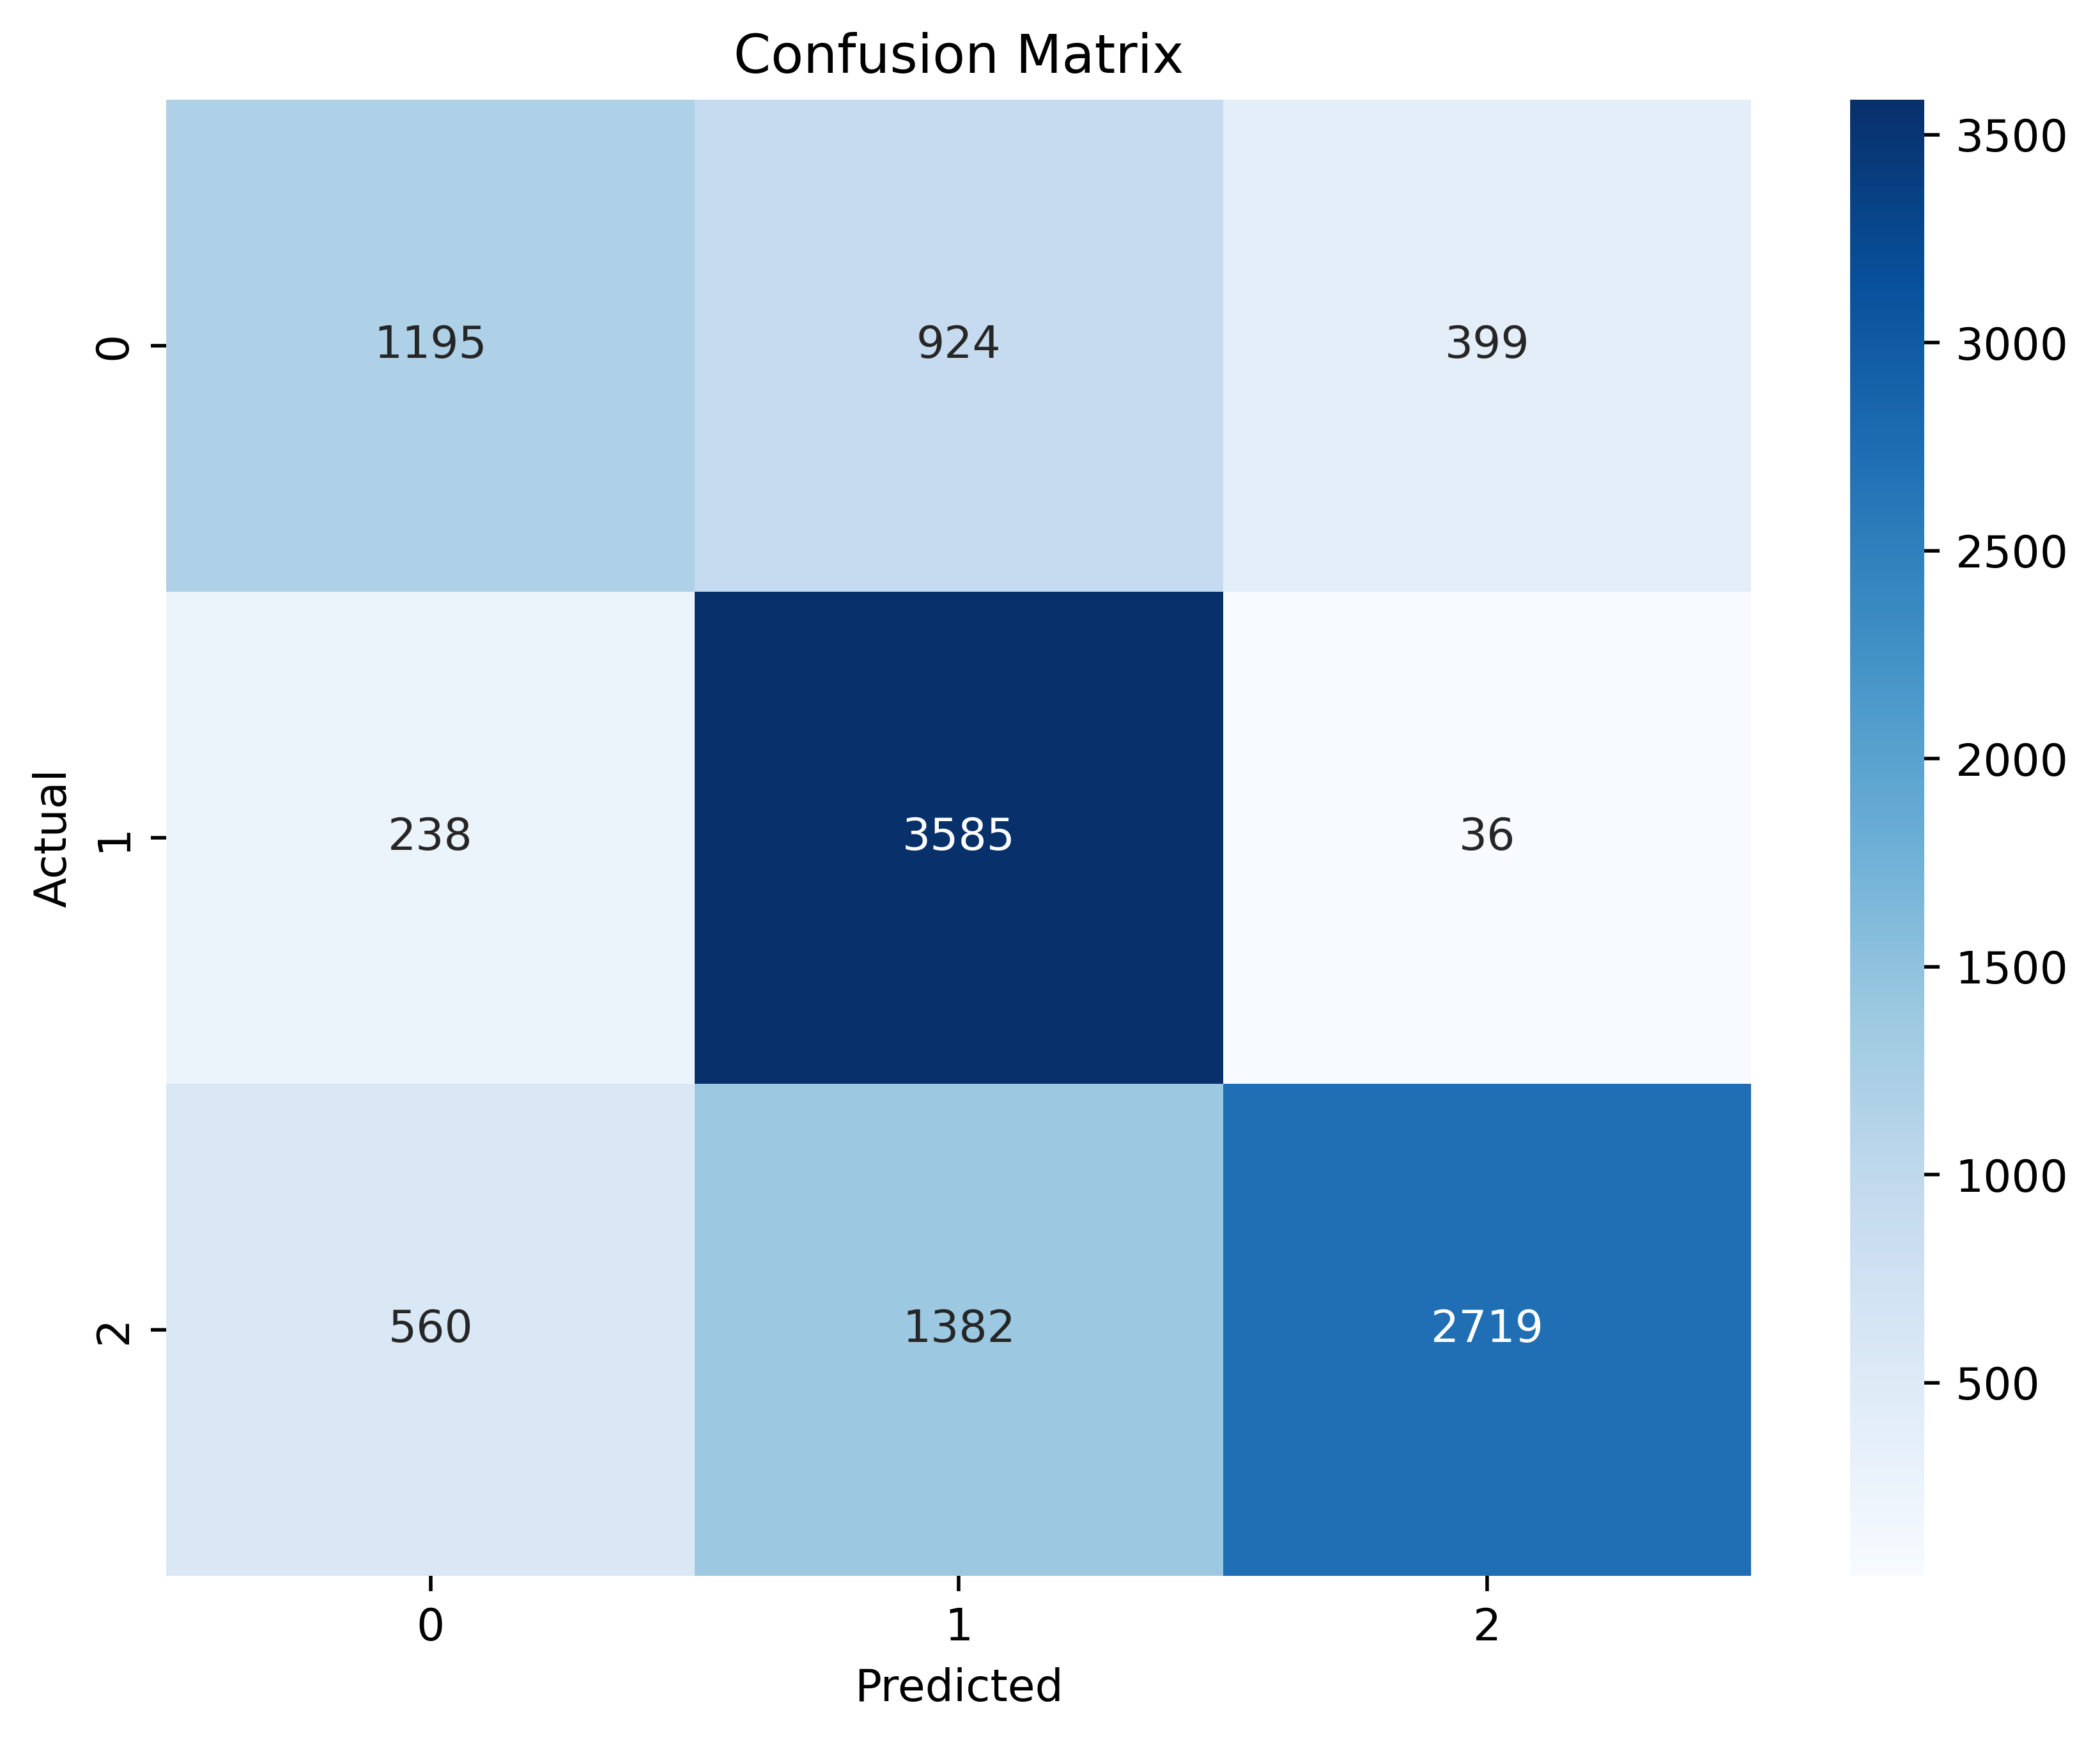

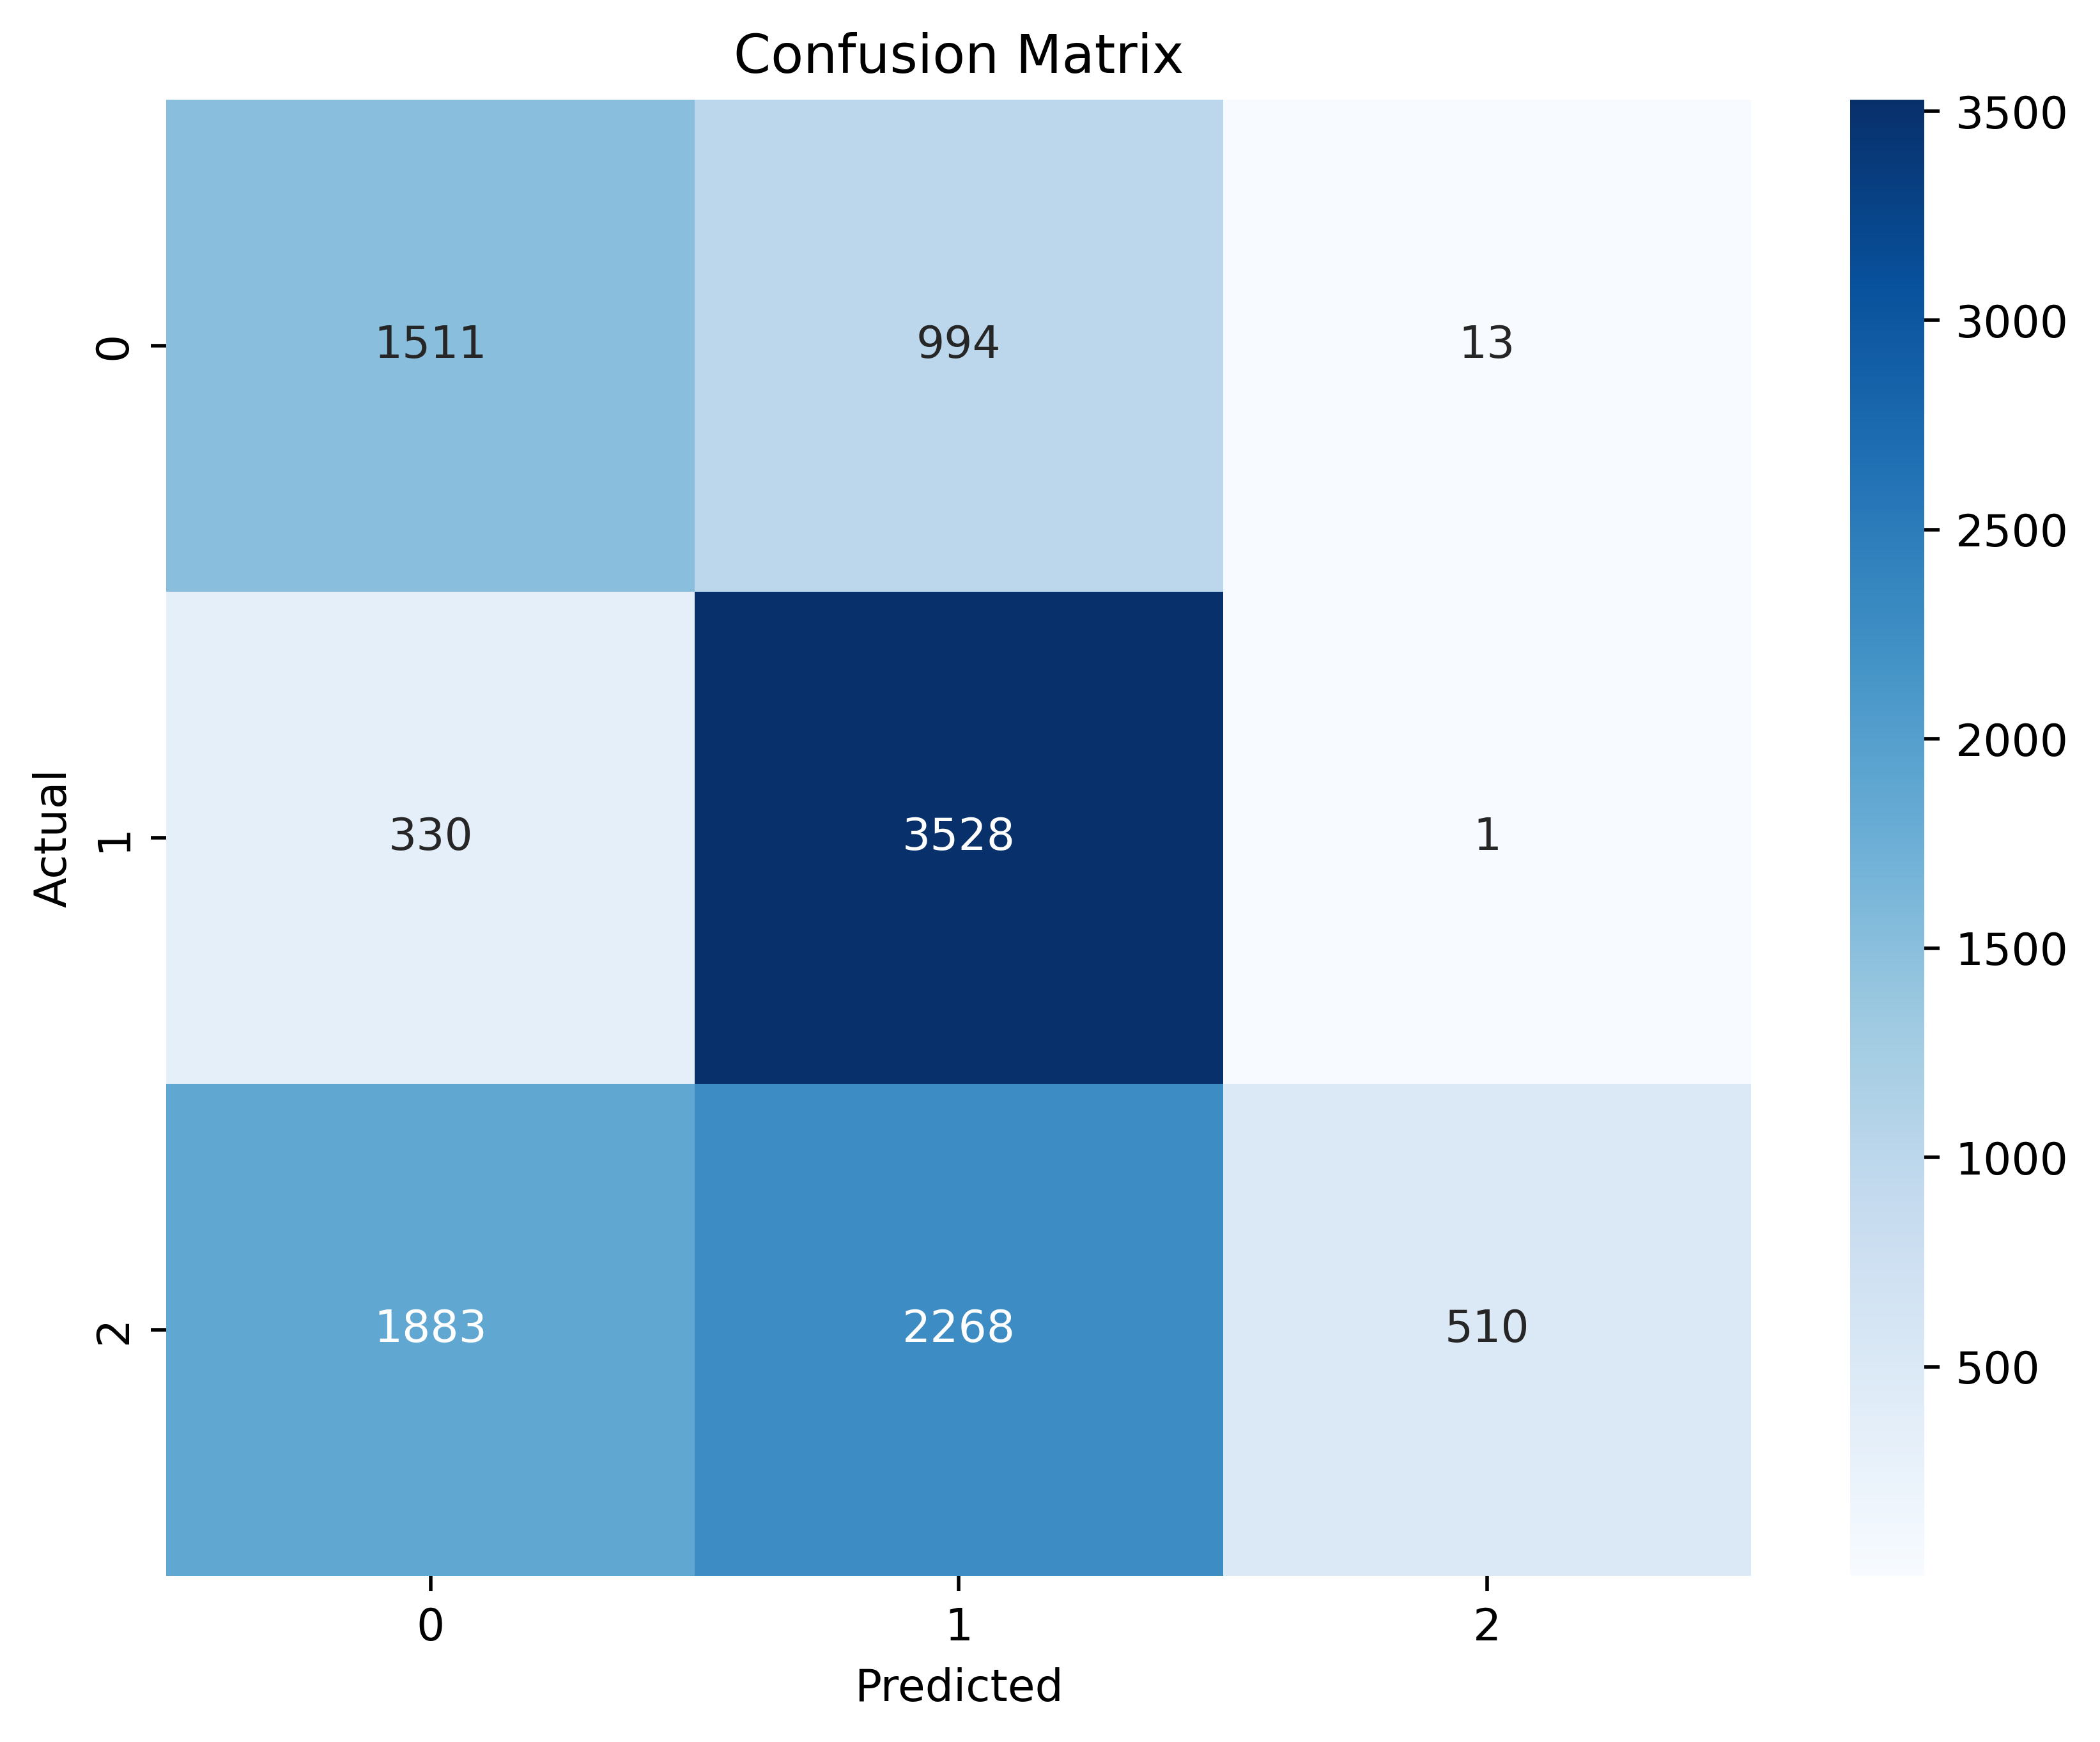

In [58]:
imbalance_methods = ['class_weight','oversampling','adasyn','undersampling','smote_enn']

for method in imbalance_methods:
    run_imbalance_experiment(method)

Oversampling

# Training Different Model

In [60]:
mlflow.set_experiment('Experiment 5 - ML Algos with HyperParameter Tuning')

2025/04/23 12:43:20 INFO mlflow.tracking.fluent: Experiment with name 'Experiment 5 - ML Algos with HyperParameter Tuning' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/751372578703991277', creation_time=1745387000798, experiment_id='751372578703991277', last_update_time=1745387000798, lifecycle_stage='active', name='Experiment 5 - ML Algos with HyperParameter Tuning', tags={}>

In [63]:
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB

In [64]:
#redfine category
df['category'] = df['category'].map({-1:2,0:0,1:1})

df['category'].unique()

array([1, 2, 0])

[I 2025-04-23 13:04:37,957] A new study created in memory with name: no-name-ae22405e-9e57-433f-ada9-d4c1ed516ebe
[I 2025-04-23 13:04:38,906] Trial 0 finished with value: 0.540103829480132 and parameters: {'n_estimators': 140, 'learning_rate': 0.0020116500119300618, 'max_depth': 4}. Best is trial 0 with value: 0.540103829480132.
[I 2025-04-23 13:04:40,333] Trial 1 finished with value: 0.5616262280931451 and parameters: {'n_estimators': 159, 'learning_rate': 0.001444512817928713, 'max_depth': 6}. Best is trial 1 with value: 0.5616262280931451.
[I 2025-04-23 13:04:41,048] Trial 2 finished with value: 0.6012329378062726 and parameters: {'n_estimators': 118, 'learning_rate': 0.012379999992810121, 'max_depth': 5}. Best is trial 2 with value: 0.6012329378062726.
[I 2025-04-23 13:04:41,710] Trial 3 finished with value: 0.6590507497062975 and parameters: {'n_estimators': 117, 'learning_rate': 0.04424167065247938, 'max_depth': 5}. Best is trial 3 with value: 0.6590507497062975.
[I 2025-04-23 13

🏃 View run XGBoost_smote_BoW_unigram at: http://localhost:8080/#/experiments/751372578703991277/runs/ffd80cd35afa47d884c7461023c76668
🧪 View experiment at: http://localhost:8080/#/experiments/751372578703991277


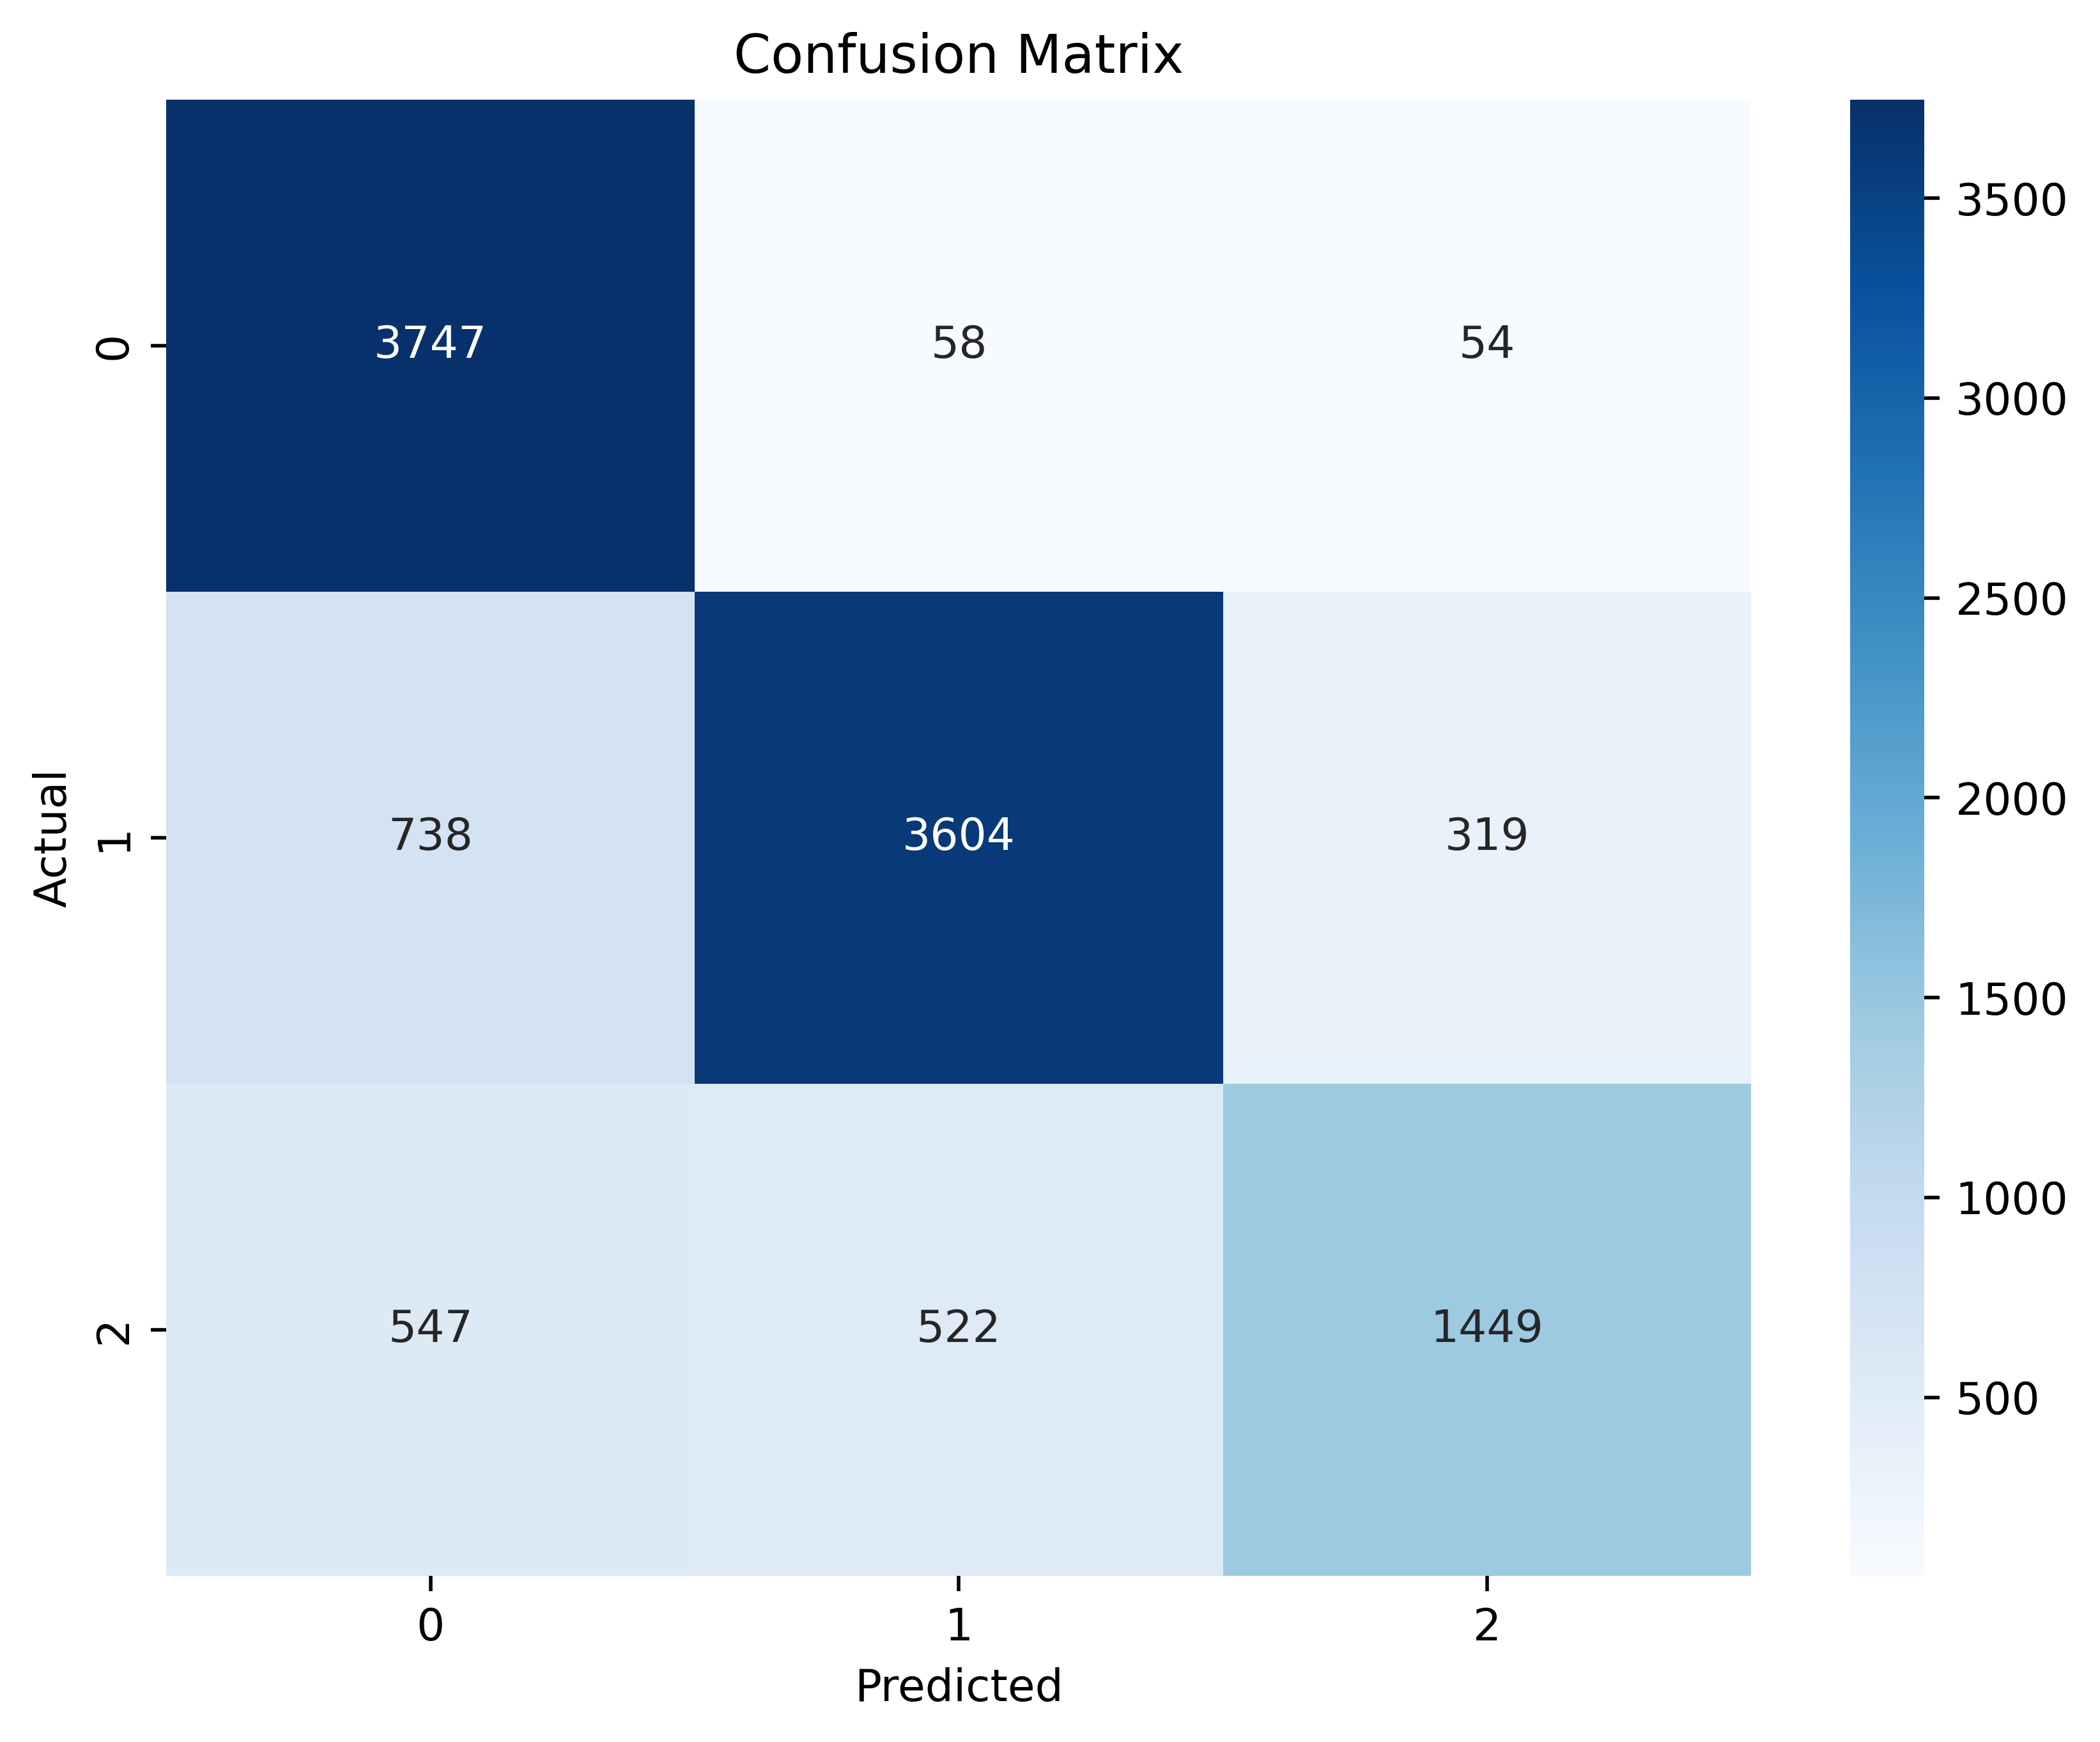

In [65]:
ngram_range = (1,1)
max_features = 1000

X_train, X_test, y_train, y_test = train_test_split(df['clean_comment'],df['category'],test_size=0.3,random_state=42)

vectorizer = CountVectorizer(ngram_range=ngram_range, max_features=max_features)

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec  = vectorizer.transform(X_test)

smote = SMOTE(random_state=42)
X_train_vec, y_train = smote.fit_resample(X_train_vec, y_train)

def log_mlflow(model_name, model, X_train, X_test, y_train, y_test):
    with mlflow.start_run(nested=True):
        mlflow.set_tag('mlflow.runName', f"{model_name}_smote_BoW_unigram")
        mlflow.set_tag("experiment_type", "algorithm_comparison")

        mlflow.log_param("algo_name", model_name)

        model.fit(X_train,y_train)

        y_pred=model.predict(X_test)
        
        balance_acc = balanced_accuracy_score(y_test, y_pred)
        mlflow.log_metric('Balanced Accuracy', balance_acc)

        recal_scr = recall_score(y_test, y_pred, average="weighted")
        mlflow.log_metric('Recall Score', recal_scr)

        precision_scr = precision_score(y_test, y_pred, average="weighted")
        mlflow.log_metric('Precision Score', precision_scr)

        f1_scr = f1_score(y_test, y_pred, average="weighted")
        mlflow.log_metric('F1 Score', f1_scr)  # Fixed metric name

        # roc_score = roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr', average="weighted")
        # mlflow.log_metric('ROC-AUC Score', roc_score)

        classification_rep = classification_report(y_test, y_pred, output_dict=True)

        for label, metrics in classification_rep.items():
            if isinstance(metrics, dict):
                for metric, value in metrics.items():
                    mlflow.log_metric(f"{label}_{metric}", value)
                
        conf_matrix = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6), dpi=500)
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')

        plt.savefig('confusion_matrix.png')
        mlflow.log_artifact("confusion_matrix.png")

        # Fixed model saving - use log_model instead of load_model
        # Fixed f-string formatting in the model name
        mlflow.sklearn.log_model(model, f"{model_name}_model")

def objective_xgboost(trial):
    n_estimators    = trial.suggest_int('n_estimators',50,300)
    learning_rate   = trial.suggest_float('learning_rate',1e-4,1e-1, log=True)
    max_depth       = trial.suggest_int('max_depth',3,10)

    model           = XGBClassifier(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, random_state=42)
    return          balanced_accuracy_score(y_test, model.fit(X_train_vec,y_train).predict(X_test_vec))

def run_optuna_experiment():
    #maximize the metrics
    study = optuna.create_study(direction="maximize")
    study.optimize(objective_xgboost, n_trials=30)

    best_params = study.best_params
    best_model  = XGBClassifier(n_estimators=best_params['n_estimators'],learning_rate=best_params['learning_rate'],max_depth=best_params['max_depth'],random_state=42)
    log_mlflow("XGBoost", best_model, X_train_vec, X_test_vec, y_train,y_test)

run_optuna_experiment()

In [66]:
# For RandomForest
def objective_randomforest(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    return balanced_accuracy_score(y_test, model.fit(X_train_vec, y_train).predict(X_test_vec))

# For LightGBM 
def objective_lightgbm(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    num_leaves = trial.suggest_int('num_leaves', 10, 100)
    
    model = LGBMClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        num_leaves=num_leaves,
        random_state=42
    )
    return balanced_accuracy_score(y_test, model.fit(X_train_vec, y_train).predict(X_test_vec))

# For LogisticRegression
def objective_logistic(trial):
    C = trial.suggest_float('C', 1e-3, 10, log=True)
    solver = trial.suggest_categorical('solver', ['liblinear', 'lbfgs', 'saga'])
    max_iter = trial.suggest_int('max_iter', 100, 500)
    
    model = LogisticRegression(
        C=C,
        solver=solver,
        max_iter=max_iter,
        random_state=42,
        multi_class='auto'
    )
    return balanced_accuracy_score(y_test, model.fit(X_train_vec, y_train).predict(X_test_vec))

# For KNeighborsClassifier
def objective_knn(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 20)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])
    
    model = KNeighborsClassifier(
        n_neighbors=n_neighbors,
        weights=weights,
        metric=metric
    )
    return balanced_accuracy_score(y_test, model.fit(X_train_vec, y_train).predict(X_test_vec))

# For MultinomialNB
def objective_naive_bayes(trial):
    alpha = trial.suggest_float('alpha', 1e-3, 10, log=True)
    fit_prior = trial.suggest_categorical('fit_prior', [True, False])
    
    model = MultinomialNB(
        alpha=alpha,
        fit_prior=fit_prior
    )
    return balanced_accuracy_score(y_test, model.fit(X_train_vec, y_train).predict(X_test_vec))

def run_optuna_experiment_all():
    # Dictionary to store best models and their metrics
    best_models = {}
    model_results = {
        'Model': [],
        'Balanced Accuracy': [],
        'Recall Score': [],
        'Precision Score': [],
        'F1 Score': []
    }
    
    # XGBoost
    study_xgb = optuna.create_study(direction="maximize")
    study_xgb.optimize(objective_xgboost, n_trials=30)
    best_params_xgb = study_xgb.best_params
    xgb_model = XGBClassifier(
        n_estimators=best_params_xgb['n_estimators'],
        learning_rate=best_params_xgb['learning_rate'],
        max_depth=best_params_xgb['max_depth'],
        random_state=42
    )
    best_models["XGBoost"] = xgb_model
    
    # RandomForest
    study_rf = optuna.create_study(direction="maximize")
    study_rf.optimize(objective_randomforest, n_trials=30)
    best_params_rf = study_rf.best_params
    rf_model = RandomForestClassifier(
        n_estimators=best_params_rf['n_estimators'],
        max_depth=best_params_rf['max_depth'],
        min_samples_split=best_params_rf['min_samples_split'],
        min_samples_leaf=best_params_rf['min_samples_leaf'],
        random_state=42
    )
    best_models["RandomForest"] = rf_model
    
    # LogisticRegression
    study_lr = optuna.create_study(direction="maximize")
    study_lr.optimize(objective_logistic, n_trials=30)
    best_params_lr = study_lr.best_params
    lr_model = LogisticRegression(
        C=best_params_lr['C'],
        solver=best_params_lr['solver'],
        max_iter=best_params_lr['max_iter'],
        random_state=42,
        multi_class='auto'
    )
    best_models["LogisticRegression"] = lr_model
    
    # KNN
    study_knn = optuna.create_study(direction="maximize")
    study_knn.optimize(objective_knn, n_trials=30)
    best_params_knn = study_knn.best_params
    knn_model = KNeighborsClassifier(
        n_neighbors=best_params_knn['n_neighbors'],
        weights=best_params_knn['weights'],
        metric=best_params_knn['metric']
    )
    best_models["KNN"] = knn_model
    
    # MultinomialNB
    study_nb = optuna.create_study(direction="maximize")
    study_nb.optimize(objective_naive_bayes, n_trials=30)
    best_params_nb = study_nb.best_params
    nb_model = MultinomialNB(
        alpha=best_params_nb['alpha'],
        fit_prior=best_params_nb['fit_prior']
    )
    best_models["MultinomialNB"] = nb_model
    
    # Log all models to MLflow and collect metrics
    for model_name, model in best_models.items():
        # Fit the model
        model.fit(X_train_vec, y_train)
        y_pred = model.predict(X_test_vec)
        
        # Calculate metrics
        balanced_acc = balanced_accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred, average="weighted")
        precision = precision_score(y_test, y_pred, average="weighted")
        f1 = f1_score(y_test, y_pred, average="weighted")
        
        # Store metrics for comparison
        model_results['Model'].append(model_name)
        model_results['Balanced Accuracy'].append(balanced_acc)
        model_results['Recall Score'].append(recall)
        model_results['Precision Score'].append(precision)
        model_results['F1 Score'].append(f1)
        
        # Log to MLflow
        with mlflow.start_run(nested=True):
            mlflow.set_tag('mlflow.runName', f"{model_name}_smote_BoW_unigram")
            mlflow.set_tag("experiment_type", "algorithm_comparison")
            mlflow.log_param("algo_name", model_name)
            
            # Log best parameters
            if model_name == "XGBoost":
                for param, value in best_params_xgb.items():
                    mlflow.log_param(param, value)
            elif model_name == "RandomForest":
                for param, value in best_params_rf.items():
                    mlflow.log_param(param, value)
            elif model_name == "LogisticRegression":
                for param, value in best_params_lr.items():
                    mlflow.log_param(param, value)
            elif model_name == "KNN":
                for param, value in best_params_knn.items():
                    mlflow.log_param(param, value)
            elif model_name == "MultinomialNB":
                for param, value in best_params_nb.items():
                    mlflow.log_param(param, value)
            
            # Log metrics
            mlflow.log_metric('Balanced Accuracy', balanced_acc)
            mlflow.log_metric('Recall Score', recall)
            mlflow.log_metric('Precision Score', precision)
            mlflow.log_metric('F1 Score', f1)
            
            # Log detailed classification report
            classification_rep = classification_report(y_test, y_pred, output_dict=True)
            for label, metrics in classification_rep.items():
                if isinstance(metrics, dict):
                    for metric, value in metrics.items():
                        mlflow.log_metric(f"{label}_{metric}", value)
            
            # Create and log confusion matrix
            conf_matrix = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(8, 6), dpi=500)
            sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.title(f'Confusion Matrix - {model_name}')
            plt.savefig(f'confusion_matrix_{model_name}.png')
            mlflow.log_artifact(f"confusion_matrix_{model_name}.png")
            plt.close()
            
            # Log model
            mlflow.sklearn.log_model(model, f"{model_name}_model")
    
    # Create comparison DataFrame
    comparison_df = pd.DataFrame(model_results)
    comparison_df.sort_values('Balanced Accuracy', ascending=False, inplace=True)
    
    # Display the comparison DataFrame
    print("\nModel Performance Comparison:")
    print(comparison_df)
    
    # Optionally save to CSV
    comparison_df.to_csv('model_comparison.csv', index=False)
    
    return comparison_df

# Run the experiment and get the comparison DataFrame
model_comparison = run_optuna_experiment_all()

[I 2025-04-23 13:10:10,078] A new study created in memory with name: no-name-33f9230a-26c6-41b3-a645-8c87036cf61e
[I 2025-04-23 13:10:11,351] Trial 0 finished with value: 0.529367972778526 and parameters: {'n_estimators': 265, 'learning_rate': 0.000109002883889241, 'max_depth': 4}. Best is trial 0 with value: 0.529367972778526.
[I 2025-04-23 13:10:14,726] Trial 1 finished with value: 0.6024848260018867 and parameters: {'n_estimators': 213, 'learning_rate': 0.0018178072052671725, 'max_depth': 9}. Best is trial 1 with value: 0.6024848260018867.
[I 2025-04-23 13:10:15,537] Trial 2 finished with value: 0.7136498607194349 and parameters: {'n_estimators': 97, 'learning_rate': 0.08295379204331486, 'max_depth': 7}. Best is trial 2 with value: 0.7136498607194349.
[I 2025-04-23 13:10:15,994] Trial 3 finished with value: 0.5532830245423289 and parameters: {'n_estimators': 65, 'learning_rate': 0.0029578762429219637, 'max_depth': 5}. Best is trial 2 with value: 0.7136498607194349.
[I 2025-04-23 13:

🏃 View run XGBoost_smote_BoW_unigram at: http://localhost:8080/#/experiments/751372578703991277/runs/470b5b8df5f74ff6b04b56b034e1a82e
🧪 View experiment at: http://localhost:8080/#/experiments/751372578703991277


2025/04/23 13:17:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForest_smote_BoW_unigram at: http://localhost:8080/#/experiments/751372578703991277/runs/ee5414a812c84ed8a94be894df0ff6ff
🧪 View experiment at: http://localhost:8080/#/experiments/751372578703991277


2025/04/23 13:17:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LogisticRegression_smote_BoW_unigram at: http://localhost:8080/#/experiments/751372578703991277/runs/ac09dade94424f3085ab9064b8b28948
🧪 View experiment at: http://localhost:8080/#/experiments/751372578703991277


2025/04/23 13:17:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run KNN_smote_BoW_unigram at: http://localhost:8080/#/experiments/751372578703991277/runs/2298887e0f9241cc9a634a280bad3cec
🧪 View experiment at: http://localhost:8080/#/experiments/751372578703991277


2025/04/23 13:17:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run MultinomialNB_smote_BoW_unigram at: http://localhost:8080/#/experiments/751372578703991277/runs/ebad30a765b34a238fe39f54682742cd
🧪 View experiment at: http://localhost:8080/#/experiments/751372578703991277

Model Performance Comparison:
                Model  Balanced Accuracy  Recall Score  Precision Score  \
2  LogisticRegression           0.777711      0.792082         0.795672   
0             XGBoost           0.770909      0.794437         0.804010   
4       MultinomialNB           0.694951      0.702935         0.714501   
1        RandomForest           0.655872      0.692698         0.697145   
3                 KNN           0.503291      0.469650         0.623175   

   F1 Score  
2  0.790504  
0  0.788332  
4  0.706820  
1  0.679225  
3  0.444995  


# Create Stacking Model

In [67]:
logreg = LogisticRegression(max_iter=409, C=2.777881512619246, solver='liblinear',random_state=42)
xgb    = XGBClassifier(learning_rate=0.9,max_depth=7,n_estimators=296, random_state=42)

In [73]:
from sklearn.ensemble import StackingClassifier

stacking_model = StackingClassifier(
    estimators=[
        ('logistic_regression',logreg)
    ],
    final_estimator=xgb,
    cv=5
)

In [74]:
stacking_model.fit(X_train_vec, y_train)
y_pred = stacking_model.predict(X_test_vec)


Stacking Model Performance:
                         Model  Balanced Accuracy  Recall Score  \
0  Stacking (XGBoost + LogReg)           0.708046      0.725947   

   Precision Score  F1 Score  
0         0.728752  0.726774  


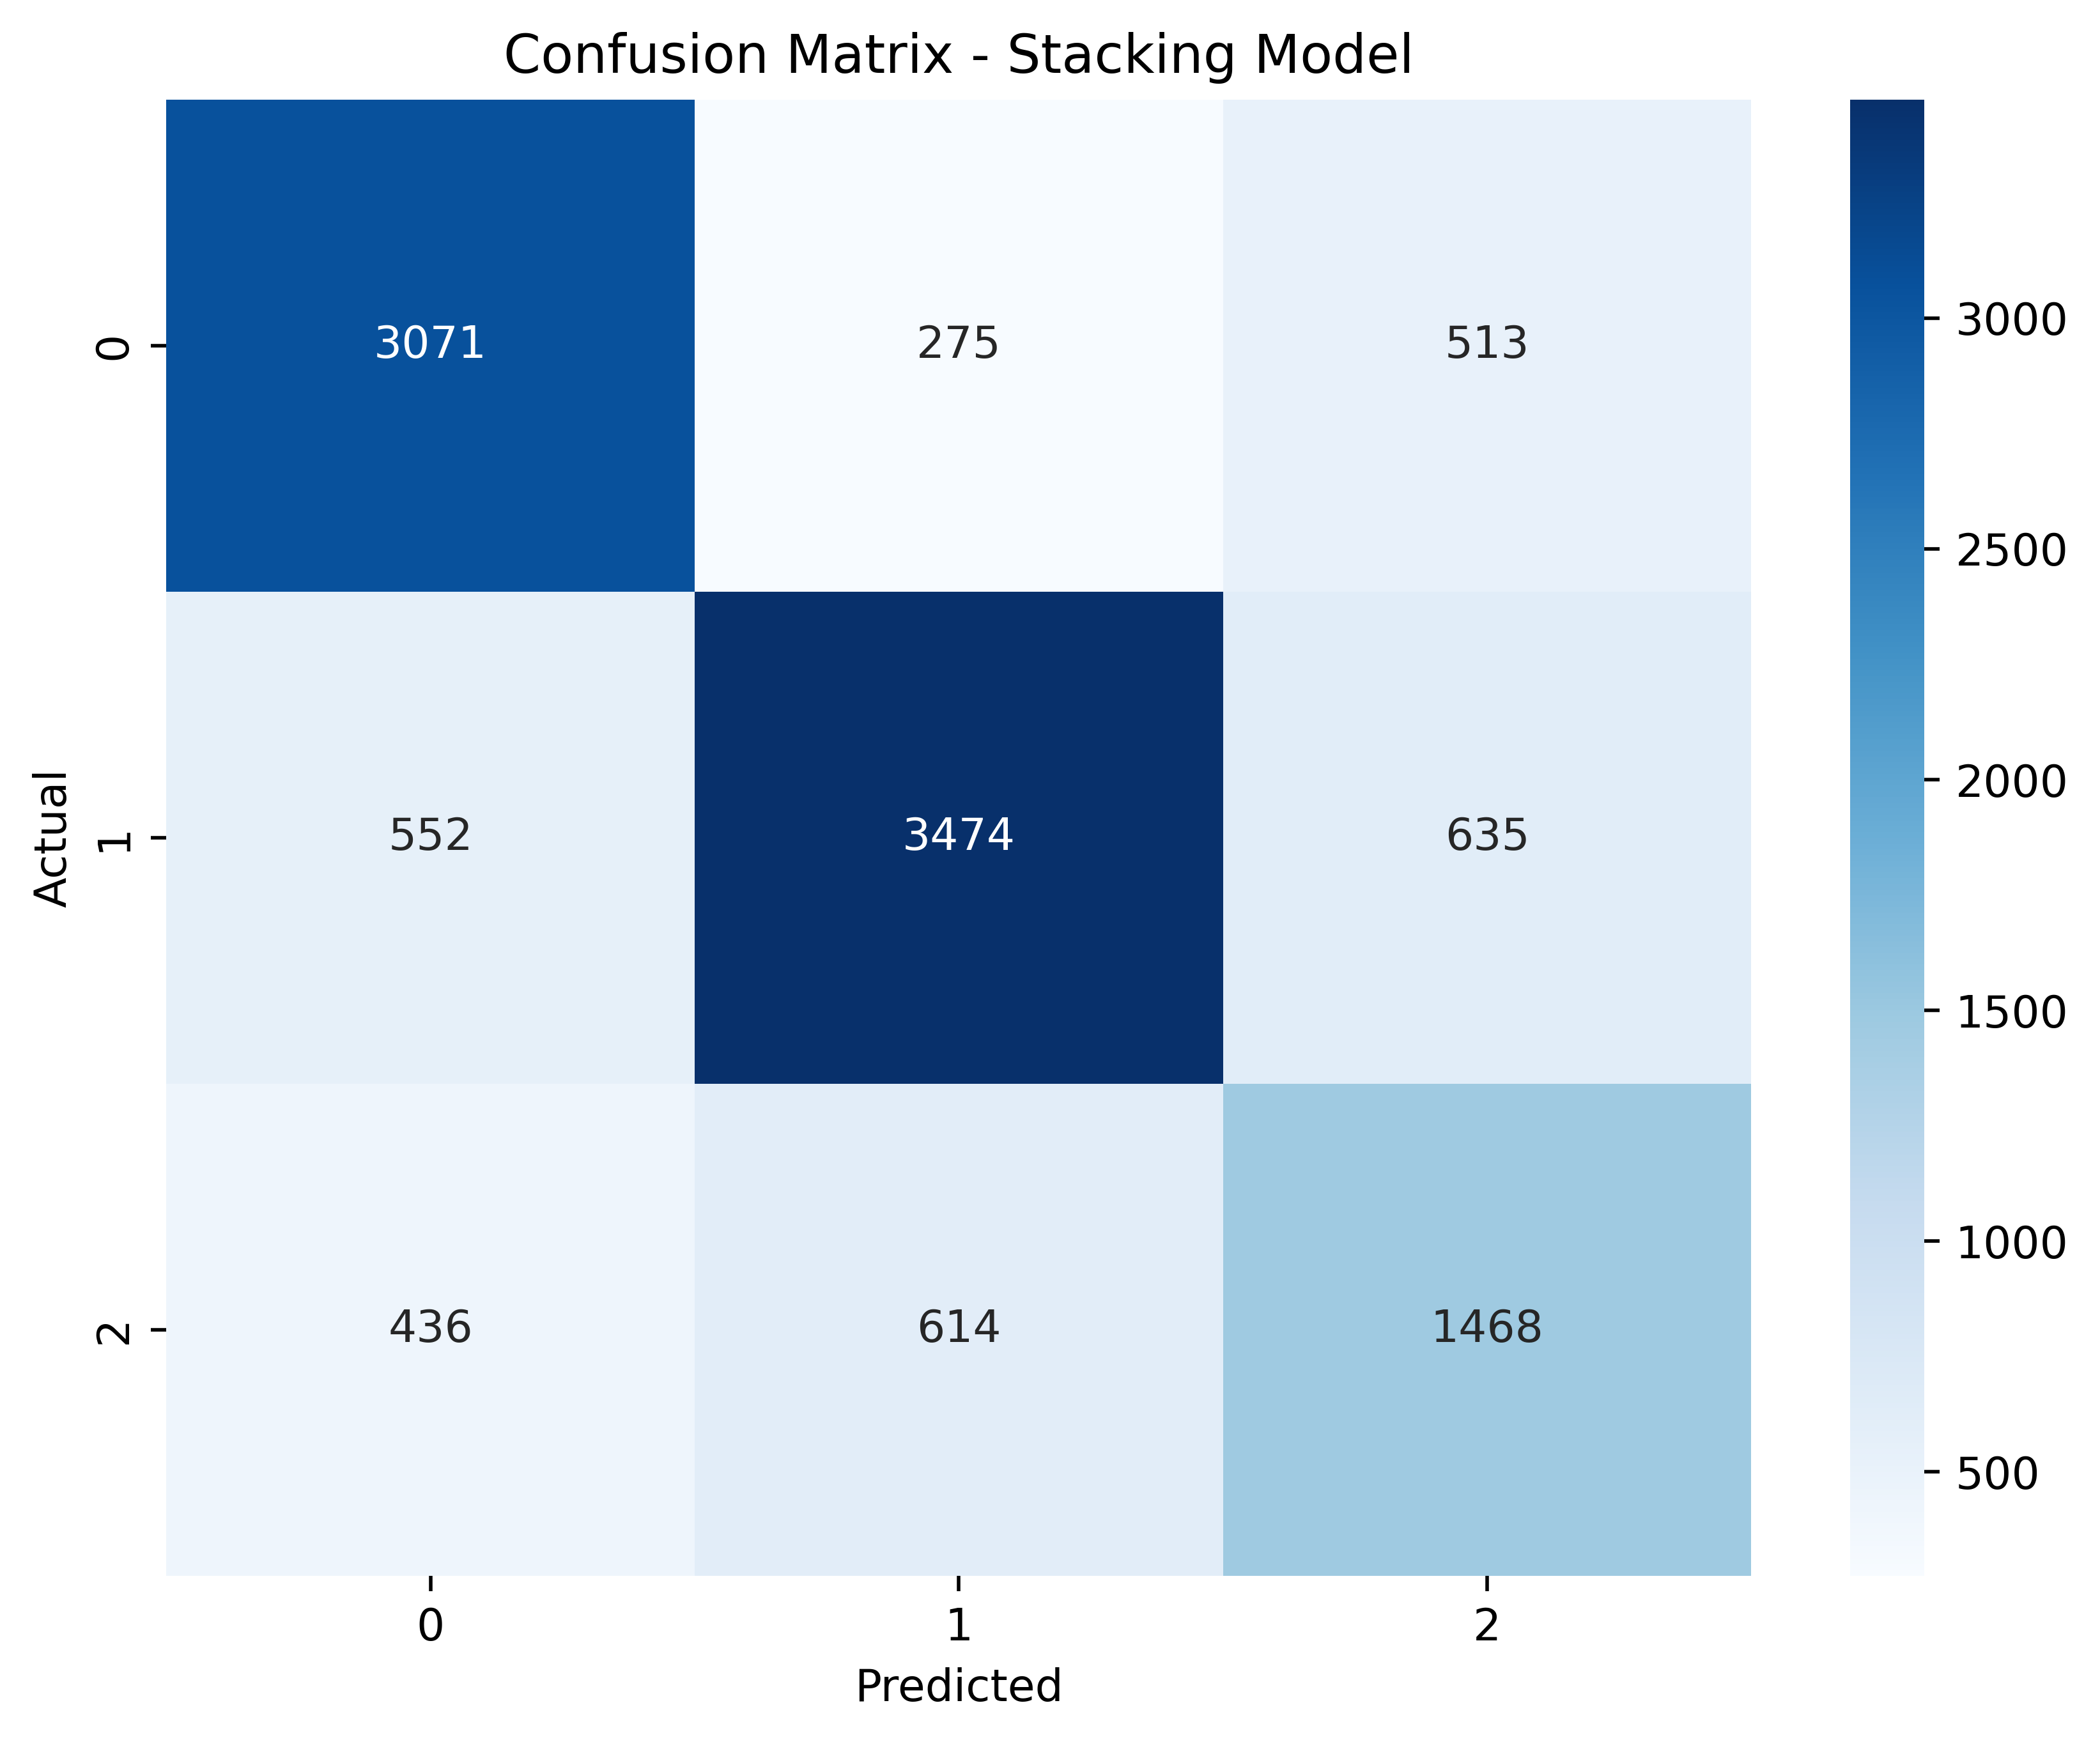

In [75]:
balanced_acc = balanced_accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average="weighted")
precision = precision_score(y_test, y_pred, average="weighted")
f1 = f1_score(y_test, y_pred, average="weighted")

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6), dpi=500)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Stacking Model')



class_report = classification_report(y_test, y_pred, output_dict=True)

# Create a DataFrame for the performance metrics
performance_metrics = pd.DataFrame({
    'Model': ['Stacking (XGBoost + LogReg)'],
    'Balanced Accuracy': [balanced_acc],
    'Recall Score': [recall],
    'Precision Score': [precision],
    'F1 Score': [f1]
})

# Display the metrics
print("\nStacking Model Performance:")
print(performance_metrics)

performance not improve, will using logistic regression